In [77]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from multipole_signal import Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [78]:
# Redshift bins

z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95 ])

#z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55 ])


# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.677,
    'As' : 2.05e-9,
    'ns' : 0.965,
    'Ob' : 0.0490, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

# JOINT ANALYSIS. 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [79]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [80]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [81]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [82]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [83]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

In [84]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50 = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias50[:4])], axis=2)
dsignal_dgbias30 = np.concatenate([np.zeros_like(dsignal_dgbias30[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [85]:
dsignal_dtheta_multi = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50, dsignal_dgbias30, dsignal_dcosmic])

np.shape(dsignal_dtheta_multi)

(29, 19, 648)

## Covariance Matrix

In [86]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (29, 29))

In [87]:
# Load the Covariance Matrix of the multipoles

Cov_Multipoles_Joint50x30_ = fm.cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4, contributions='all')

Inv_Cov_Multipoles_Joint50x30_ = np.array([np.linalg.pinv(Cov_Multipoles_Joint50x30_[i]) for i,_ in enumerate(z_bins)])

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]


 ... Loading Covariance Matrices (Joint-splittings Analysis) [all] [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 



In [88]:
# Check if Inverse Cov Matrices are symmetric:

for n, z in enumerate(z_bins):
    print(n, np.allclose(Inv_Cov_Multipoles_Joint50x30_[n], Inv_Cov_Multipoles_Joint50x30_[n].T, rtol = 1e-1), np.allclose(Inv_Cov_Multipoles_Joint50x30[n], Inv_Cov_Multipoles_Joint50x30[n].T, rtol = 1e-3))

0 False True
1 False True
2 False True
3 False True
4 False True
5 False True
6 False True
7 False True
8 False True
9 False True
10 False True
11 False True
12 False True
13 False True
14 False True
15 False True
16 False True
17 False True
18 False True


In [89]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(29, 29)

In [90]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[:8,:8]]))

62747.07394749656	22550.14106054469	-83252.9227396791	144964.4342295327	-27256.011412869622	-8936.813016994425	38924.36454623809	-69975.18786284777
22550.14106054469	14041.029632731701	-16123.079648476758	24552.857784976808	-8936.813016994425	-5419.4035994382975	6957.46625232385	-11315.64592971093
-83252.92273967911	-16123.079648476754	144968.28808488618	-265394.5985752956	38924.364546238074	6957.466252323849	-69975.18786284776	130160.53379185307
144964.4342295327	24552.857784976804	-265394.59857529553	496528.1845806599	-69975.18786284779	-11315.645929710934	130160.53379185313	-245418.74740613918
-27256.011412868294	-8936.813016994207	38924.36454623563	-69975.18786284313	19394.765715384434	6791.081662571692	-26513.227169256905	47157.54099901688
-8936.813016994205	-5419.403599438252	6957.466252323473	-11315.645929710234	6791.0816625716925	4361.512908474298	-4826.363258232905	7789.084360993823
38924.36454623566	6957.466252323475	-69975.18786284319	130160.53379184447	-26513.227169256897	-

In [91]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[8:16,8:16]]))

66924.17308323362	34035.460885551234	-54194.225225084585	63063.97965905136	2218.617285133266	1077.4171497151124	5934.83720856078	1404.108707550257
34035.46088555124	22100.81300782302	-18560.491062115663	18387.536075292544	1077.4171497151126	659.6922253770645	2218.617285133266	606.1985991551994
-54194.22522508463	-18560.491062115674	63720.39050374003	-84299.20451107257	-1884.8740844756994	-646.8673322157354	-6642.922832063474	-1349.7400323236102
63063.979659051474	18387.53607529257	-84299.20451107269	253880.3233989604	2186.627487516114	638.5705445348634	9033.563338436945	1647.029063241423
2218.6172851332817	1077.4171497151176	-1884.8740844757208	2186.6274875161466	90.25070314833339	41.76921671350548	248.9022746865063	58.169830343097324
1077.4171497151171	659.6922253770664	-646.8673322157396	638.5705445348694	41.76921671350549	24.210597508410334	90.18735075741336	24.194419063363004
5934.837208560862	2218.617285133283	-6642.922832063609	9033.563338437169	248.9022746865066	90.1873507574134

In [92]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:,16:]]))

264059475.9572432	51502572.09035246	196473465.50158498	21098529.363728248	-100195015.80130817	-21366734.133955568	-392385523.7074986	-56738031.01434221	1791952.3542005364	924160.5295968377	-796937.2629450968	-5365131.803174092	-3094157.125696751
51502572.090352446	14752323.700702025	21098529.36372824	1467063.4040991494	-21366734.13395558	-6931424.867508292	-56738031.01434224	-10499256.596331174	644960.104477406	320106.6005995172	-248069.499919305	-1964295.2365073455	-644640.8500424647
195684537.1955391	20933651.179270573	421862734.86061007	67636267.32458094	-37592336.559554376	56146.092155253544	-622465309.1064808	-95106280.09300025	285455.7470373466	69925.3474441276	115588.66139737278	-1123291.4007956947	2666768.9448250965
20933651.17927058	1440093.122723074	67636267.32458094	14393732.054673055	56146.09215525341	1520547.99879809	-95106280.09300026	-18324758.169470217	4885.677184156711	-20292.294381838867	69152.62275323895	-86791.26956510893	606660.0907035219
-105319231.78029016	-21683

In [93]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[16:24,16:24]]))

264059475.9572432	51502572.09035246	196473465.50158498	21098529.363728248	-100195015.80130817	-21366734.133955568	-392385523.7074986	-56738031.01434221
51502572.090352446	14752323.700702025	21098529.36372824	1467063.4040991494	-21366734.13395558	-6931424.867508292	-56738031.01434224	-10499256.596331174
195684537.1955391	20933651.179270573	421862734.86061007	67636267.32458094	-37592336.559554376	56146.092155253544	-622465309.1064808	-95106280.09300025
20933651.17927058	1440093.122723074	67636267.32458094	14393732.054673055	56146.09215525341	1520547.99879809	-95106280.09300026	-18324758.169470217
-105319231.78029016	-21683455.10809007	-43904900.41206513	-401887.74679800036	68009599.88001108	16651765.17688237	76636244.0131047	2967253.991519053
-21683455.10809007	-6942909.167892729	-401887.74679799494	1491672.705195785	16651765.176882364	5962712.105175508	2967253.9915190246	-1478486.308935919
-397504420.4627781	-57016291.48291718	-629594573.3329374	-95692505.63859512	71275011.52296776	2613

In [94]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[24:,24:]]))

6512199.896173946	2107840.777543173	732104.9838282926	-24455315.103426337	8474573.359226324
2107840.7778191087	725778.3153191303	159845.12884682592	-7598482.601778865	2646462.3892168505
732104.9824690236	159845.12848618132	343565.91897880426	-2829844.546015099	1855816.0445409708
-24455315.097114284	-7598482.59682572	-2829844.5550530455	99648767.2270529	-30696885.613992207
8474573.349887902	2646462.388254623	1855816.0446114738	-30696885.52967405	17368713.10308521


In [98]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-1))

False


In [99]:
print(np.allclose(Fisher_Matrix_Joint50x30[:-5,:-5], Fisher_Matrix_Joint50x30[:-5,:-5].T, rtol=1e-6))

False


In [100]:
np.linalg.det(Fisher_Matrix_Joint50x30)

3.6309605334211825e+125

In [101]:
Fisher_Matrix_Joint50x30__ = 0.5 * (Fisher_Matrix_Joint50x30 + Fisher_Matrix_Joint50x30.T)

In [102]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30__[16:,16:]]))

264059475.9572432	51502572.09035245	196079001.34856203	21016090.271499414	-102757123.79079917	-21525094.62102282	-394944972.0851383	-56877161.24862969	1893888.5353424447	984938.4492813535	-863747.9439165262	-5725806.806689162	-3826397.638594443
51502572.09035245	14752323.700702025	21016090.271499407	1453578.2634111117	-21525094.621022824	-6937167.01770051	-56877161.24862971	-10501006.073077057	651125.4718491267	323785.6599069458	-252218.7890518707	-1986560.2184610725	-699922.1915555927
196079001.34856203	21016090.271499407	421862734.86061007	67636267.32458094	-40748618.48580976	-172870.8273213707	-626029941.2197092	-95399392.8657977	401791.11537552235	139288.88981167314	39335.95936206213	-1534931.4755934211	1830656.558753314
21016090.271499414	1453578.2634111117	67636267.32458094	14393732.054673055	-172870.82732137348	1506110.3519969375	-95399392.8657977	-18348719.109558884	11915.073573846312	-16097.604506907599	64421.018186998306	-112179.86047429034	543549.983185998
-102757123.7907991

In [103]:
np.linalg.det(Fisher_Matrix_Joint50x30[:-5, :-5])

1.3205842623519085e+97

In [104]:
np.linalg.det(Fisher_Matrix_Joint50x30__[:-5, :-5])

1.2335035640483958e+97

In [105]:
np.linalg.det(Fisher_Matrix_Joint50x30__)

3.3468197160671883e+125

In [106]:
np.linalg.det(Fisher_Matrix_Joint50x30)

3.6309605334211825e+125

## Constraints

In [107]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [25.24310712 14.24889505 20.58830379 19.6252366 ]

sB_30 =  [31.05747112 35.09634374 43.03883382 21.23596657]

s_model =  [33.69469233 16.5471027  40.29761391 49.81665676]

number =  [39.6642439  26.11845367 19.29554174 27.29488894]

gbias_50 =  [0.1205257  0.3039489  0.11071667 0.21082258]

gbias_30 =  [0.13460702 0.36223614 0.10065939 0.20871926]

cosmic =  [1.09221572 0.60427459 0.8608494  1.24322338 0.40104583]



In [108]:
np.linalg.det(Fisher_Matrix_Joint50x30), np.linalg.det(Sigma_Matrix_Joint50x30)

(3.6309605334211825e+125, 2.7540921769782184e-126)

In [109]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [110]:
print(isPSD(Fisher_Matrix_Joint50x30[:-5,:-5], tol=1e-10))

(array([1.64179712e+09, 1.88157824e+08, 4.79214675e+07, 9.07625621e+06,
       3.53676912e+06, 3.06171597e+06, 9.17693163e+05, 8.72871470e+05,
       2.68186523e+05, 1.16327247e+05, 8.79499816e+04, 4.21788751e+04,
       2.78453788e+04, 1.31567341e+04, 2.11712600e+03, 4.49295909e+02,
       3.56448950e+02, 7.87008913e+01, 2.75659639e+01, 1.41012147e+01,
       7.25250553e+00, 8.94907914e-01, 3.46395056e-02, 1.14602407e-01]), True)


In [111]:
print(isPSD(Sigma_Matrix_Joint50x30, tol=1e-10))

(array([2.88688411e+01, 8.72585978e+00, 1.11750983e+00, 1.37895420e-01,
       7.09184224e-02, 3.62785628e-02, 1.27076879e-02, 2.80588482e-03,
       2.22809082e-03, 4.75196067e-04, 4.46344232e-04, 7.61146083e-05,
       3.60185030e-05, 2.43959110e-05, 1.71310146e-05, 1.13749643e-05,
       9.13968694e-06, 3.72762084e-06, 2.30588637e-06, 1.08975211e-06,
       1.15643188e-06, 4.16154313e-07, 2.79873372e-07, 1.82593824e-07,
       1.06624049e-07, 6.09053978e-10, 5.31029472e-09, 8.51998063e-09,
       2.02981144e-08]), True)


In [112]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [1.64194456e+09 1.88332096e+08 1.17371155e+08 4.93056085e+07
 9.40868999e+06 5.47721061e+06 3.60505250e+06 2.39215061e+06
 9.17639630e+05 8.61743646e+05 4.31892451e+05 2.68263318e+05
 1.09392295e+05 8.79119395e+04 5.83291594e+04 4.09895973e+04
 2.77635030e+04 1.31380826e+04 2.24025922e+03 2.10437841e+03
 4.48814733e+02 3.56393812e+02 7.86925210e+01 2.75644878e+01
 1.41007085e+01 7.25187250e+00 8.94846712e-01 1.14601887e-01
 3.46394230e-02]
Condition number of A: 47401036547.72272


In [113]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [114]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

True

In [115]:
np.linalg.det(A_plus), np.linalg.det(Sigma_Matrix_Joint50x30)

(2.7540921698403858e-126, 2.7540921769782184e-126)

In [116]:
np.prod(s), np.linalg.det(Fisher_Matrix_Joint50x30)

(3.630960542828609e+125, 3.6309605334211825e+125)

## Triangle Plots

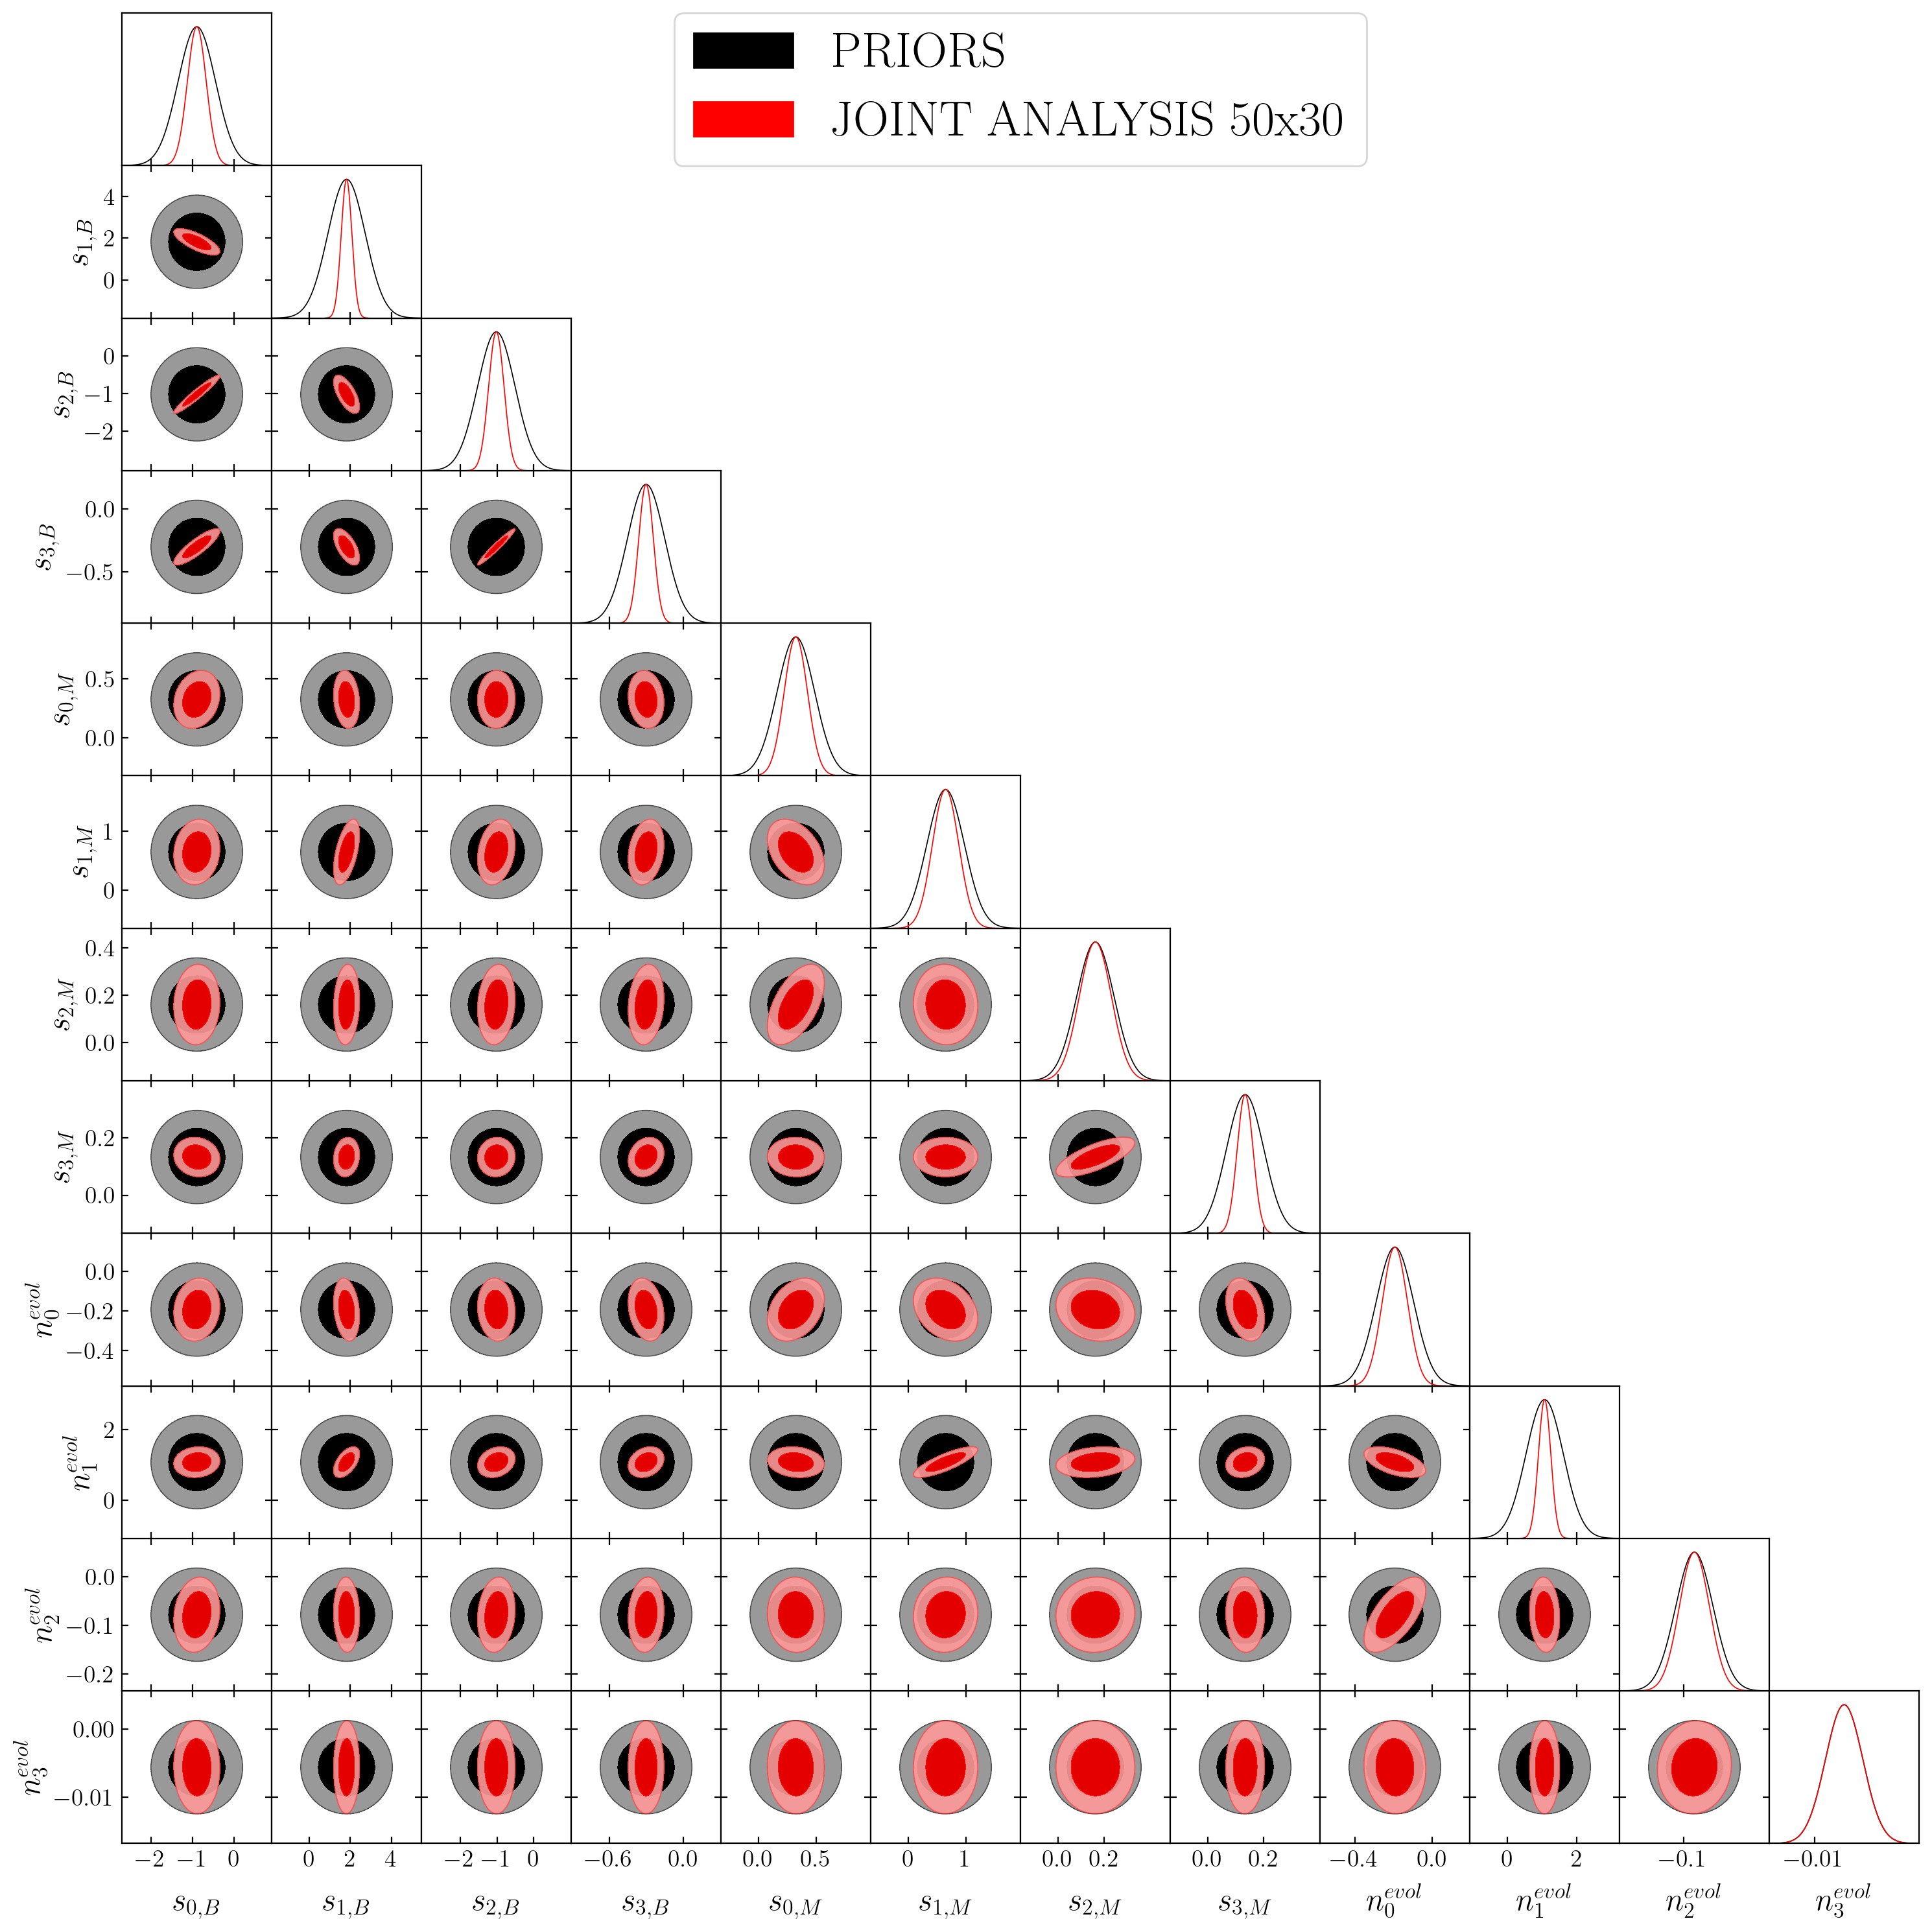

In [117]:
# Triangle plot

mean = params_fid[:-13]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit30))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_sbias_nevol_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[:-13,:-13], labels = labels, names = param_names)
GaussDist_priors_sbias_nevol_fit = GaussianND(mean, Cov_prior_all, labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_priors_sbias_nevol_fit, GaussDist_sbias_nevol_fit], param_names, 
                filled=True, 
                legend_labels=['PRIORS', 'JOINT ANALYSIS 50x30'],
                contour_colors=['black', 'red'])

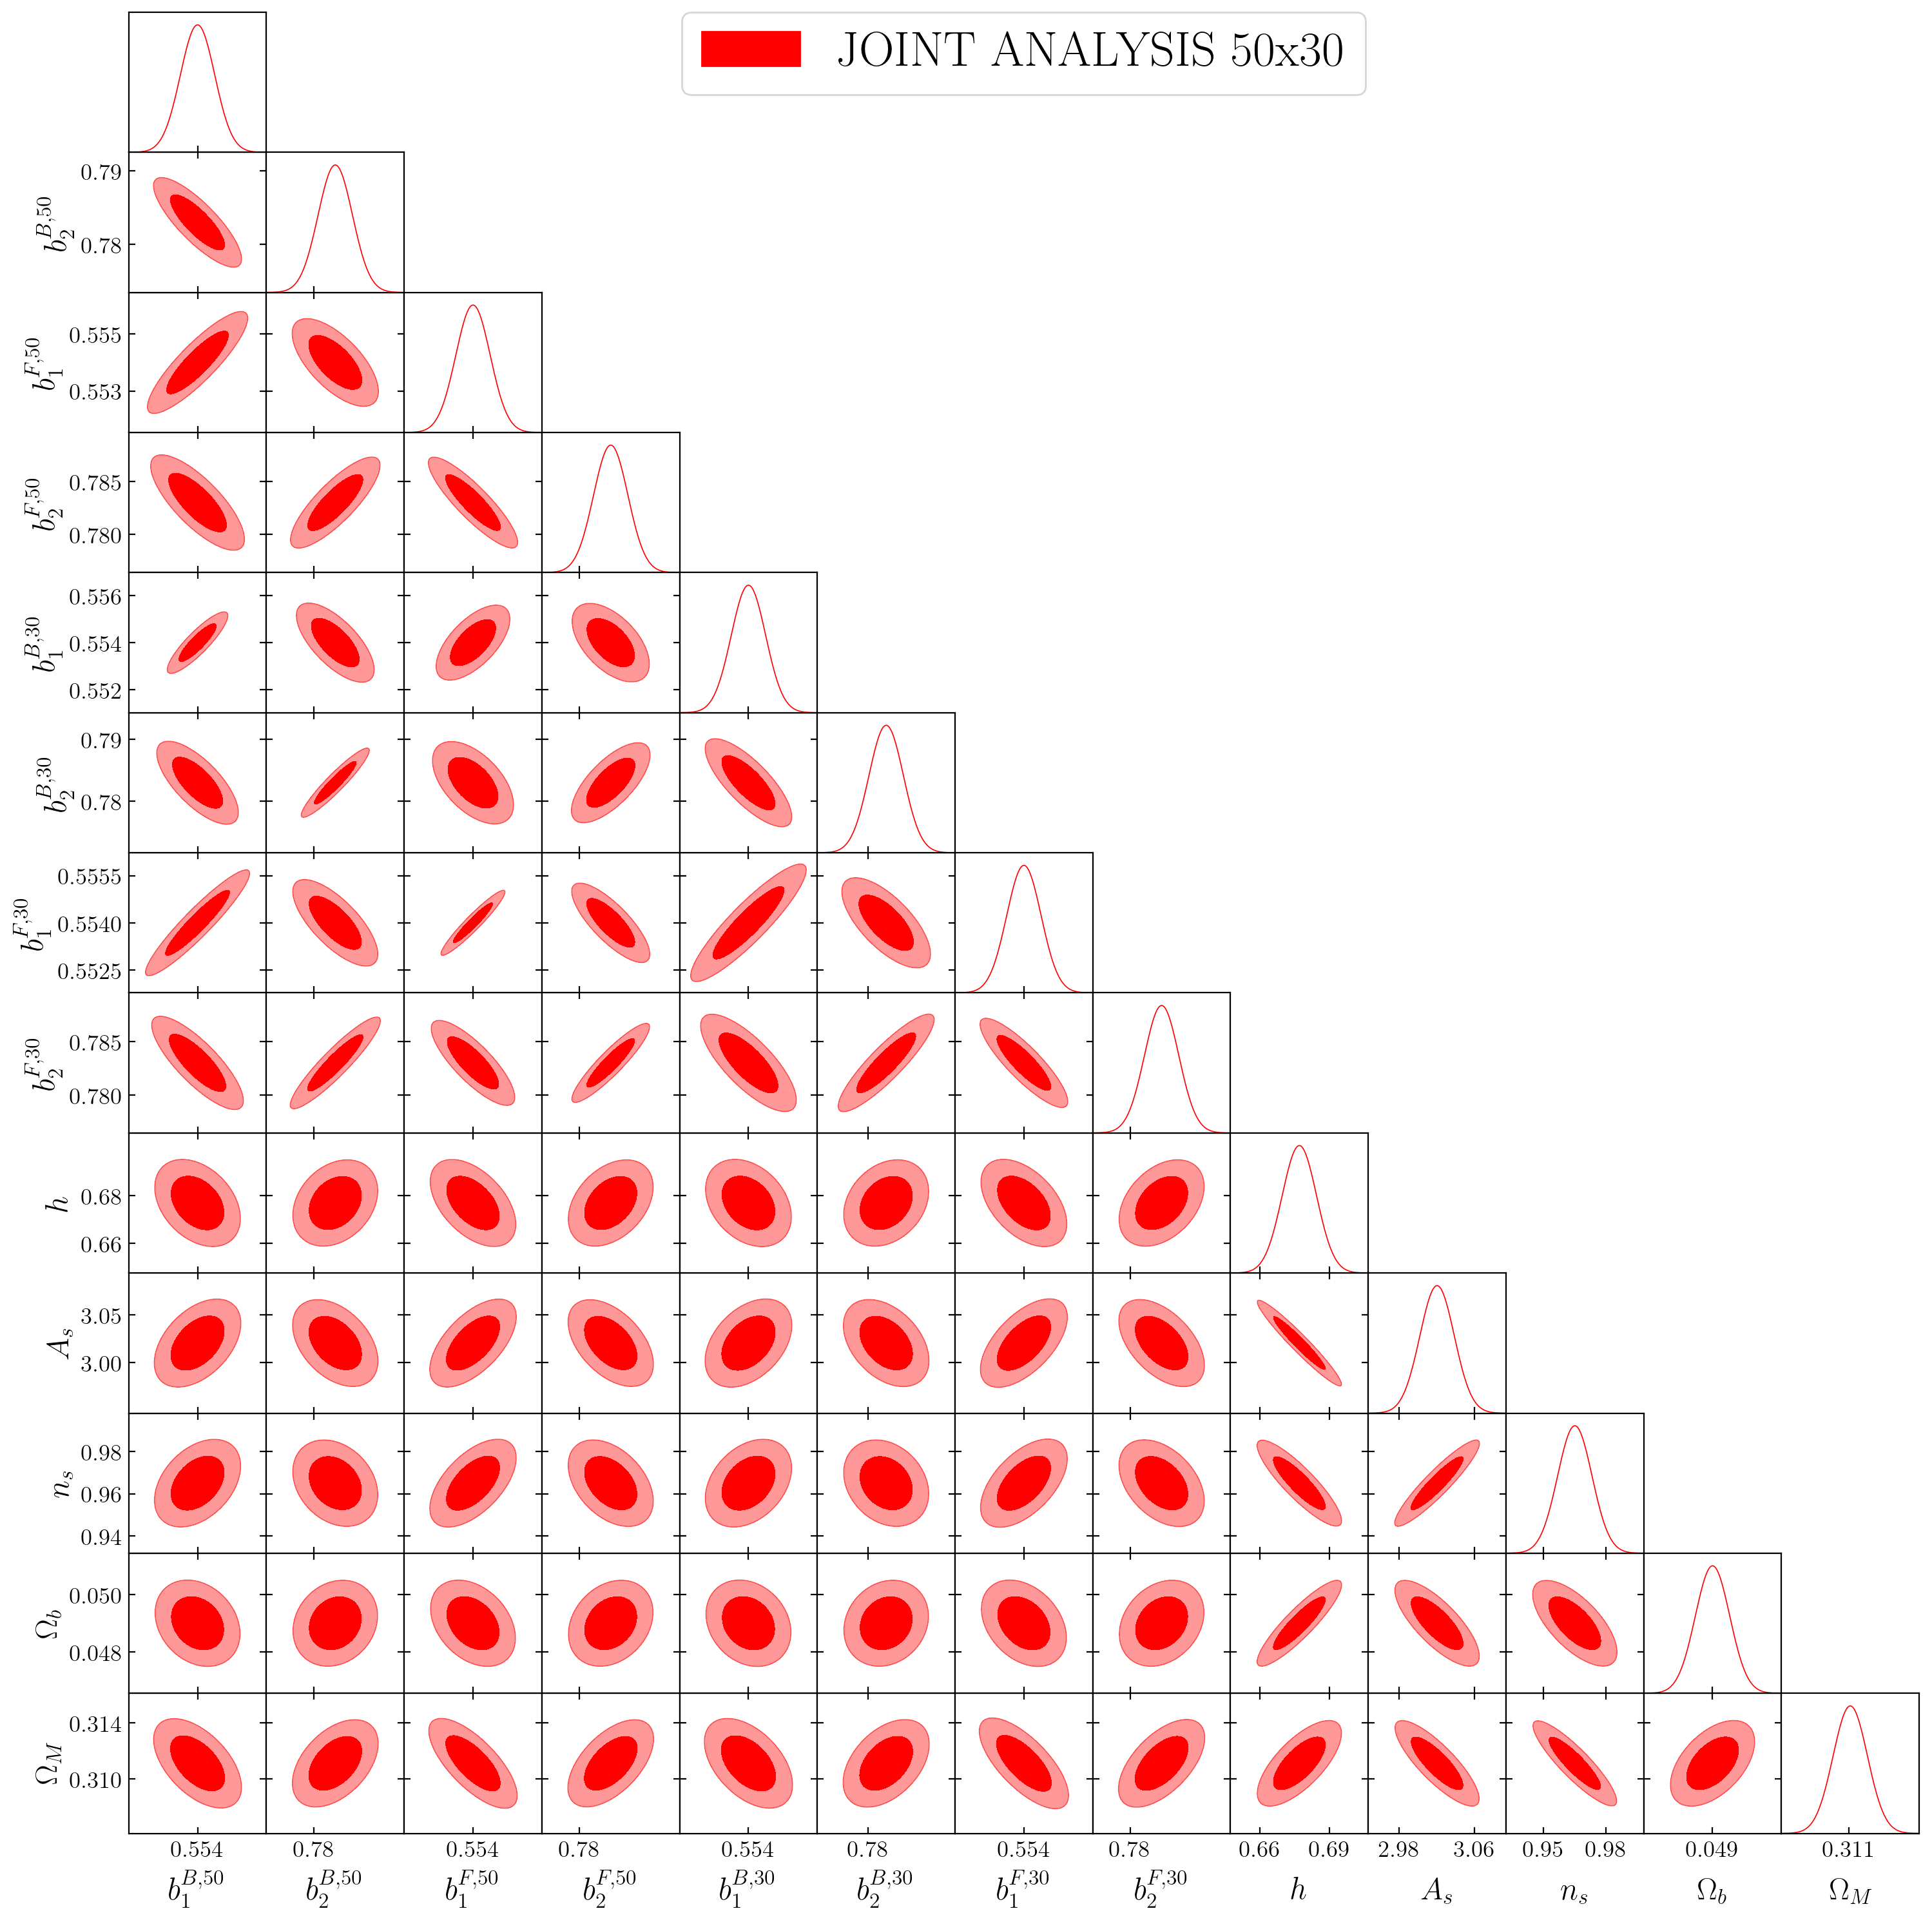

In [118]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean = params_fid[16:]

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1'] + ['b1B_m2', 'b2B_m2', 'b1F_m2', 'b2F_m2']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B,50}', r'b_2^{B,50}', r'b_1^{F,50}', r'b_2^{F,50}'] + [r'b_1^{B,30}', r'b_2^{B,30}', r'b_1^{F,30}', r'b_2^{F,30}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[16:,16:], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot(GaussDist_gbias_cosmic_fit, param_names, 
                filled=True, 
                legend_labels=['JOINT ANALYSIS 50x30'],
                contour_colors=['red'])

In [119]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_Joint50x30[24:,24:]]))

6512199.896173946	2107840.777543173	732104.9838282926	-24455315.103426337	8474573.359226324
2107840.7778191087	725778.3153191303	159845.12884682592	-7598482.601778865	2646462.3892168505
732104.9824690236	159845.12848618132	343565.91897880426	-2829844.546015099	1855816.0445409708
-24455315.097114284	-7598482.59682572	-2829844.5550530455	99648767.2270529	-30696885.613992207
8474573.349887902	2646462.388254623	1855816.0446114738	-30696885.52967405	17368713.10308521


In [120]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x30[24:,24:]]))

5.467567875588217e-05	-0.00012972032145299885	-5.37974539163451e-05	4.025100480634574e-06	6.486508235644015e-06
-0.00012975135757682172	0.0003331230984422852	0.00013975033735538623	-8.504409286199994e-06	-1.8866681528606762e-05
-5.372634412991555e-05	0.00013949136977527122	6.900951741017283e-05	-3.3984103410320717e-06	-9.167621240244616e-06
4.021523278345193e-06	-8.491826635555737e-06	-3.3975436685016083e-06	3.7109960705534004e-07	3.8229353116271187e-07
6.5038116516295194e-06	-1.8910918151189155e-05	-9.209406658783507e-06	3.8417914277778583e-07	1.5566394368707507e-06


In [121]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Joint50x30[16:24,16:24]]))

4.458398110727092e-07	-1.3008210267004473e-06	3.5585086280684426e-07	-8.45468917916064e-07	4.367213940053526e-07	-1.3523906337928952e-06	3.478495613933325e-07	-8.845607713846899e-07
-1.2418761058024409e-06	5.664018496549138e-06	-9.630774505515975e-07	3.214275373012589e-06	-1.2158696327002504e-06	6.3173521460701e-06	-9.601711084337276e-07	3.57245834466532e-06
3.079330017024126e-07	-9.055739103000131e-07	3.762232094433474e-07	-8.869796467062937e-07	2.8790368408046204e-07	-9.323810024096419e-07	3.246275382530531e-07	-8.119226031376677e-07
-7.049347118414772e-07	3.0115483873988354e-06	-8.544624196293707e-07	2.724945188367741e-06	-6.679550838435695e-07	3.251734148367949e-06	-7.280352659772253e-07	2.460136984767897e-06
5.001288224258846e-07	-1.4200373030929676e-06	3.9101416925767355e-07	-9.269413224665627e-07	5.561025935998233e-07	-1.6339138725766629e-06	3.7426639959033775e-07	-9.292941657865915e-07
-1.4338925461371687e-06	6.629644727371284e-06	-1.1093653673520739e-06	3.7041557279565285e-06	

In [123]:
np.allclose(Sigma_Matrix_Joint50x30[16:24,16:24], Sigma_Matrix_Joint50x30[16:24,16:24].T, rtol=1e-1)

False

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [124]:
len(dsignal_dgbias50[1,1])/2

324.0

In [125]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50[:,:,:324], dsignal_dcosmic50])

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 324)

In [126]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [127]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [128]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [129]:
np.linalg.det(Fisher_Matrix_50)

1.895167651343227e+78

In [130]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [29.96562105 19.65421466 25.09354168 24.1440115 ]

smodel =  [39.32415803 28.18124742 45.13538145 49.94441659]

number =  [41.26958199 30.59051957 25.60699765 30.6620992 ]

gbias =  [0.25908924 0.38871751 0.237073   0.30779066]

cosmic =  [1.32237596 0.74757498 1.11488564 1.39619211 0.55642466]


In [131]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [132]:
np.linalg.det(Sigma_Matrix_50)

5.276578034091118e-79

In [133]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [9.81374355e+07 7.54170157e+07 5.29395903e+06 1.89782931e+06
 1.15098256e+06 3.37941194e+05 3.01888063e+05 1.35390102e+05
 9.04898413e+04 8.10574855e+04 6.83924847e+04 1.79116316e+04
 1.43067549e+03 7.49909971e+02 1.82874304e+02 1.72920376e+01
 1.01668865e+01 5.70070015e+00 4.27497198e-01 6.46945439e-02
 3.28065395e-02]
Condition number of A: 2991398578.5650406


In [134]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [135]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [136]:
len(dsignal_dgbias30[1,1])/2

324.0

In [137]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30[:,:,324:], dsignal_dcosmic30])

np.shape(dsignal_dtheta_fit_all30)

(21, 19, 324)

In [138]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [139]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = fm.inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True, rtol=1e-10)

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_30)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [140]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-9)

True

In [141]:
np.linalg.det(Fisher_Matrix_30)

8.533248359712198e+78

In [142]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [32.91545734 37.55909747 43.61157626 21.46062873]

smodel =  [37.87849226 18.60522994 46.48970423 49.95712123]

number =  [40.22811877 27.81768051 23.87182321 29.72725482]

gbias =  [0.28551142 0.40989638 0.21292049 0.26888336]

cosmic =  [1.1320548  0.61848122 0.9196463  1.27750669 0.42123413]


In [143]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [144]:
np.linalg.det(Sigma_Matrix_30)

1.1718866694671498e-79

In [145]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [2.97699979e+01 1.23952118e+01 1.70435374e+00 7.58016153e-02
 5.82896451e-02 1.33002998e-02 4.72599277e-03 2.14006875e-03
 4.76093173e-04 1.12279776e-04 2.20221225e-05 1.87169848e-05
 1.47711446e-05 1.06596176e-05 4.68392965e-06 3.80999489e-06
 9.89698896e-07 3.87169765e-07 1.78400739e-07 9.56295462e-09
 7.74584298e-09]
(Log)-Condition number of A: 9.584710115782977


In [146]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [147]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 1.1718866694624888e-79


In [148]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [149]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [25.24310712 14.24889505 20.58830379 19.6252366 ]

sB_30 =  [31.05747112 35.09634374 43.03883382 21.23596657]

s_model =  [33.69469233 16.5471027  40.29761391 49.81665676]

number =  [39.6642439  26.11845367 19.29554174 27.29488894]

gbias_50 =  [0.1205257  0.3039489  0.11071667 0.21082258]

gbias_30 =  [0.13460702 0.36223614 0.10065939 0.20871926]

cosmic =  [1.09221572 0.60427459 0.8608494  1.24322338 0.40104583]



# Numerical comparison

In [150]:
cosmic50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [151]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [152]:
np.shape(par_errors_all_Joint)

(29,)

In [153]:
gbias50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [154]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [155]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint/gbias50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic50x50) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic30x70) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [15.75977327 27.50208897 17.95377449 18.71592422] 

 Dgbias =  [53.48100956 21.80725399 53.29848988 31.50455614] 

 Dsmodel =  [14.31554031 41.2832851  10.71834863  0.25580402] 

 Dnum =  [ 3.88988211 14.61912372 24.64738739 10.98166906] 

 Dcosmic =  [17.40505306 19.1686978  22.78585627 10.95613818 27.92450547] 


 Difference Joint vs 30x70 

 DsB =  [5.64472249 6.55700987 1.31328075 1.04685733] 

 Dgbias =  [52.85406885 11.62738595 52.72442423 22.37553962] 

 Dsmodel =  [11.045318   11.06208977 13.31927236  0.28117006] 

 Dnum =  [ 1.40169336  6.10844188 19.17022185  8.18227549] 

 Dcosmic =  [3.51918269 2.29701865 6.39342549 2.68361146 4.79265488] 



In [156]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50/cosmic30x70) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [  8.96185722  47.67122753  42.46128246 -12.50374722] 

 Dgbias =  [  9.25433256   5.16688335 -11.34344291 -14.469955  ] 

 Dsmodel =  [-3.81658743e+00 -5.14694928e+01  2.91316713e+00  2.54310917e-02] 

 Dnum =  [-2.58889366 -9.96790173 -7.26871352 -3.14473833] 

 Dcosmic =  [-16.81200955 -20.87270487 -21.22982913  -9.29039526 -32.09391867] 



# Triangle Plots

In [157]:
np.shape(params_fid), np.shape(params_fid_50)

((29,), (21,))

In [158]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [159]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

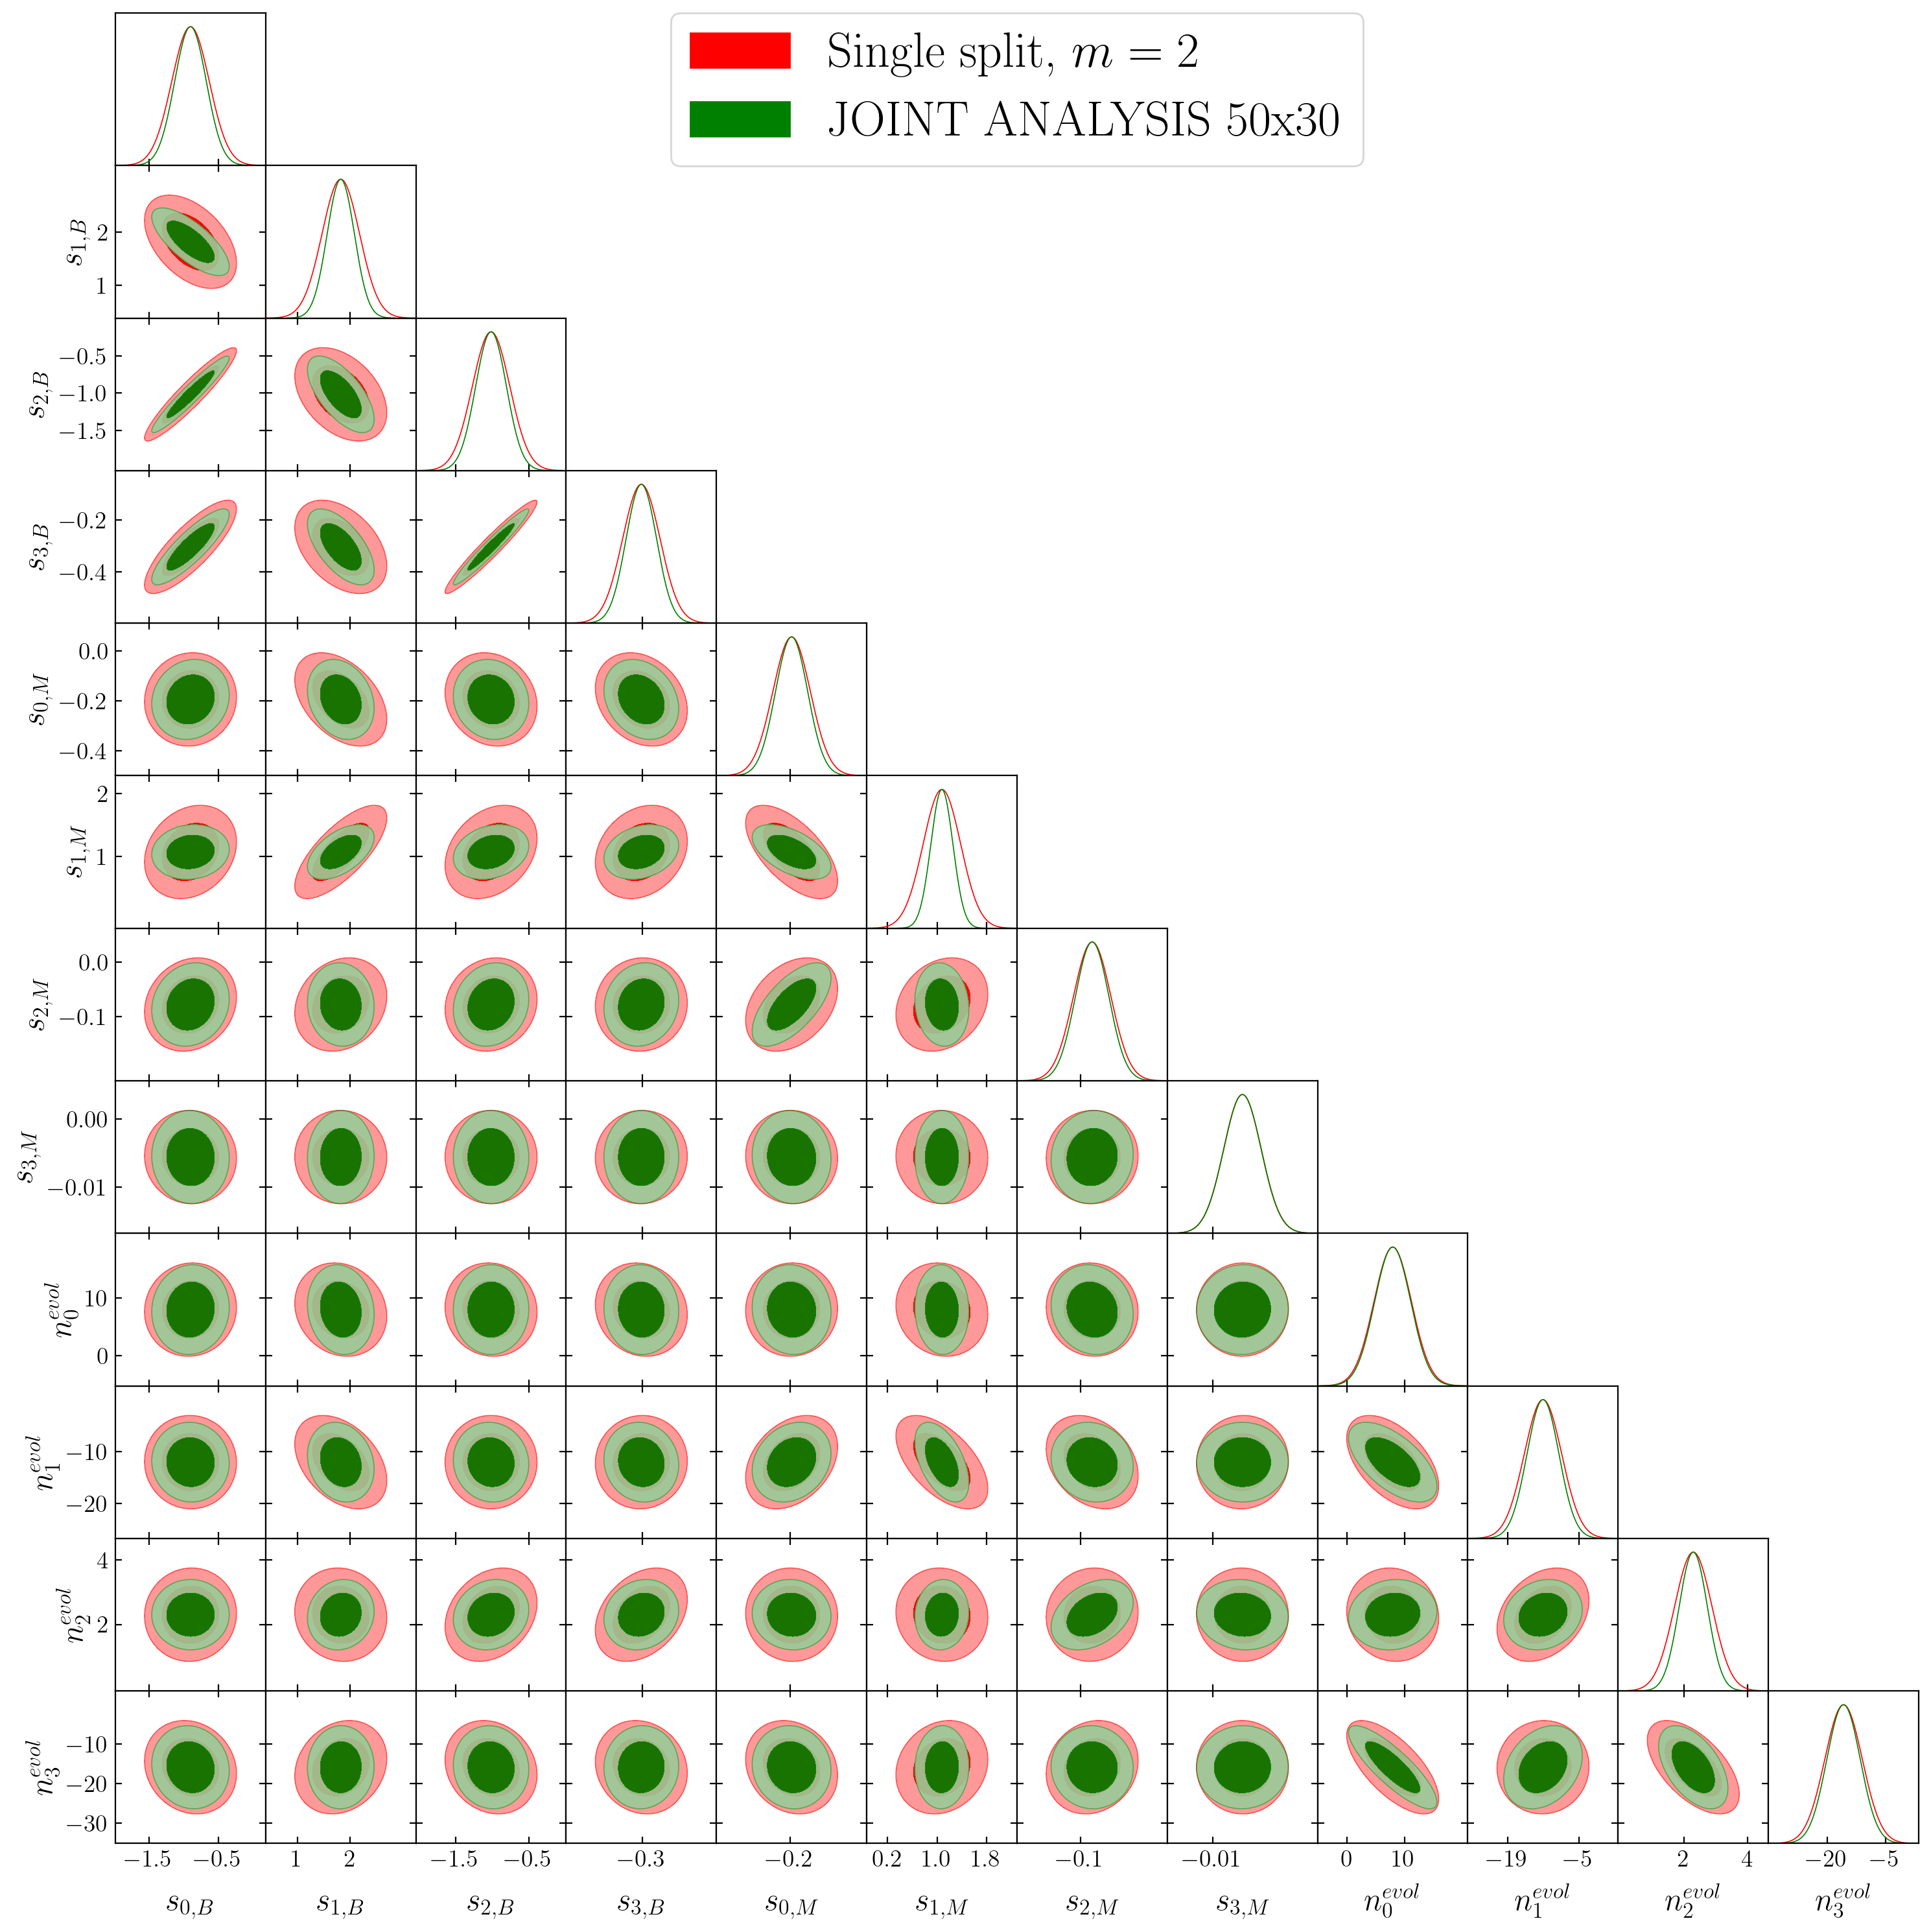

In [160]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [161]:
np.shape(params_fid), np.shape(params_fid_30)

((29,), (21,))

In [162]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [163]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

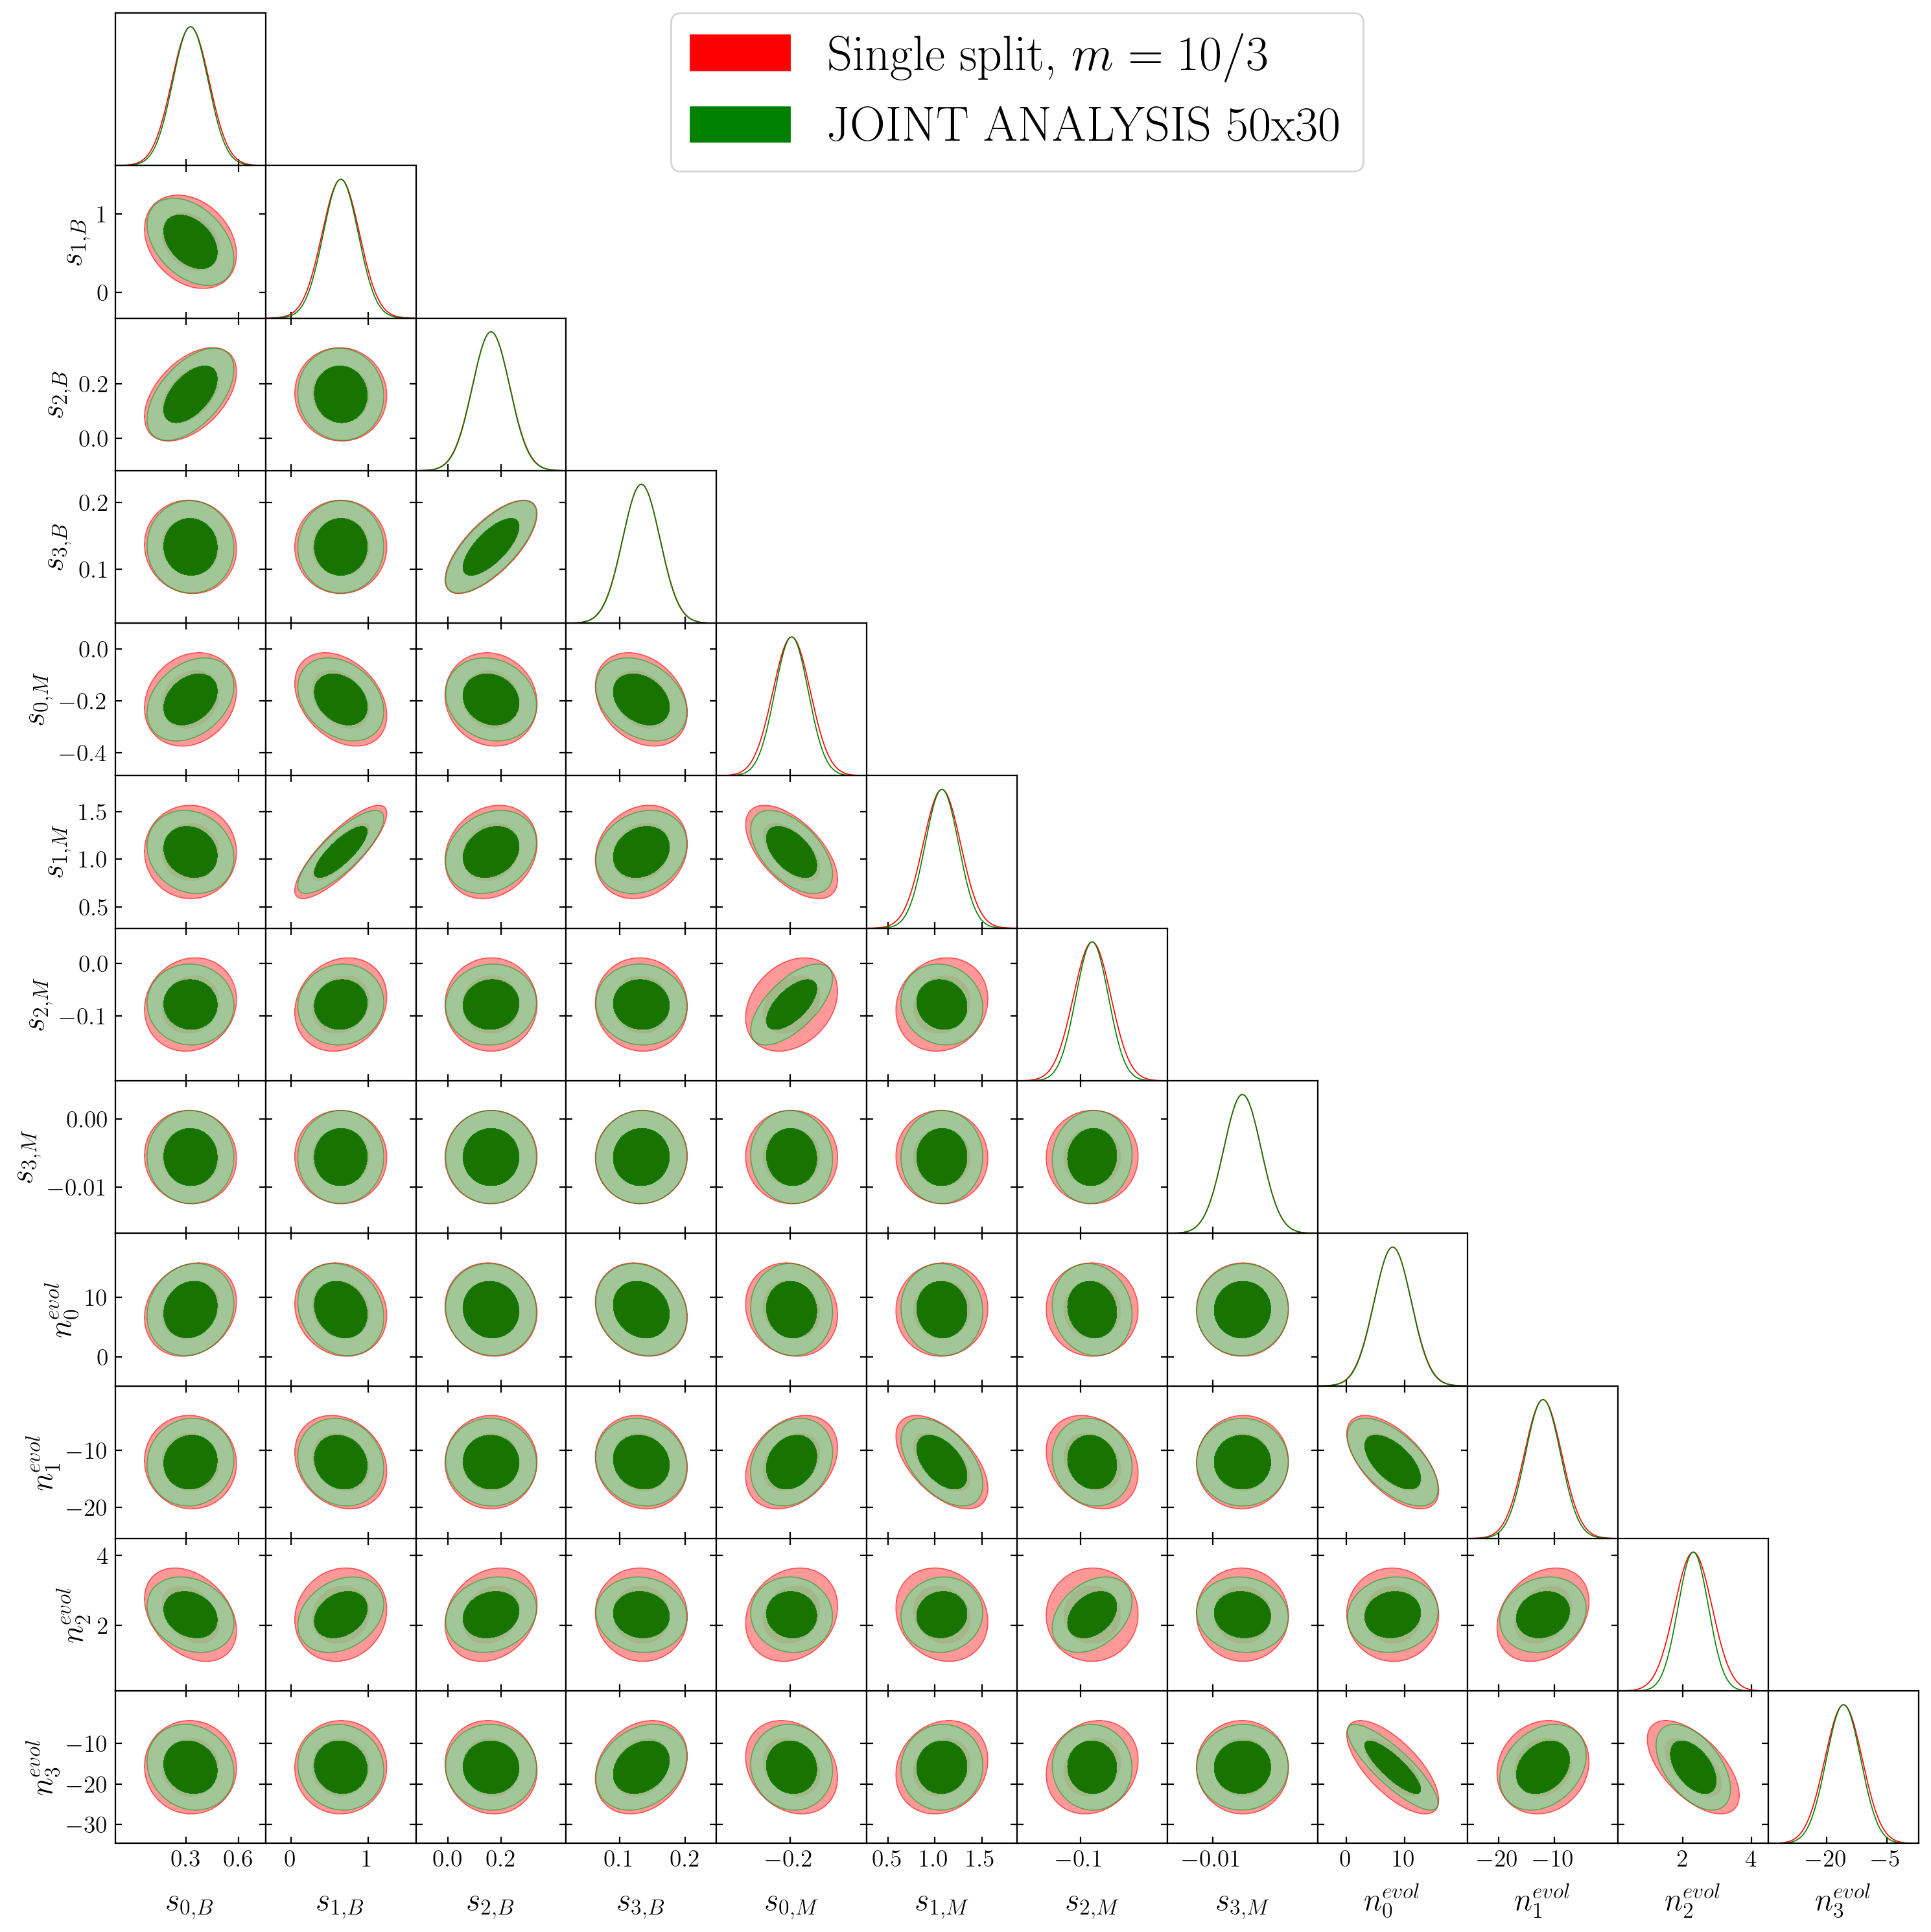

In [164]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [165]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(20,24))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(9, 9)

In [166]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(9,)

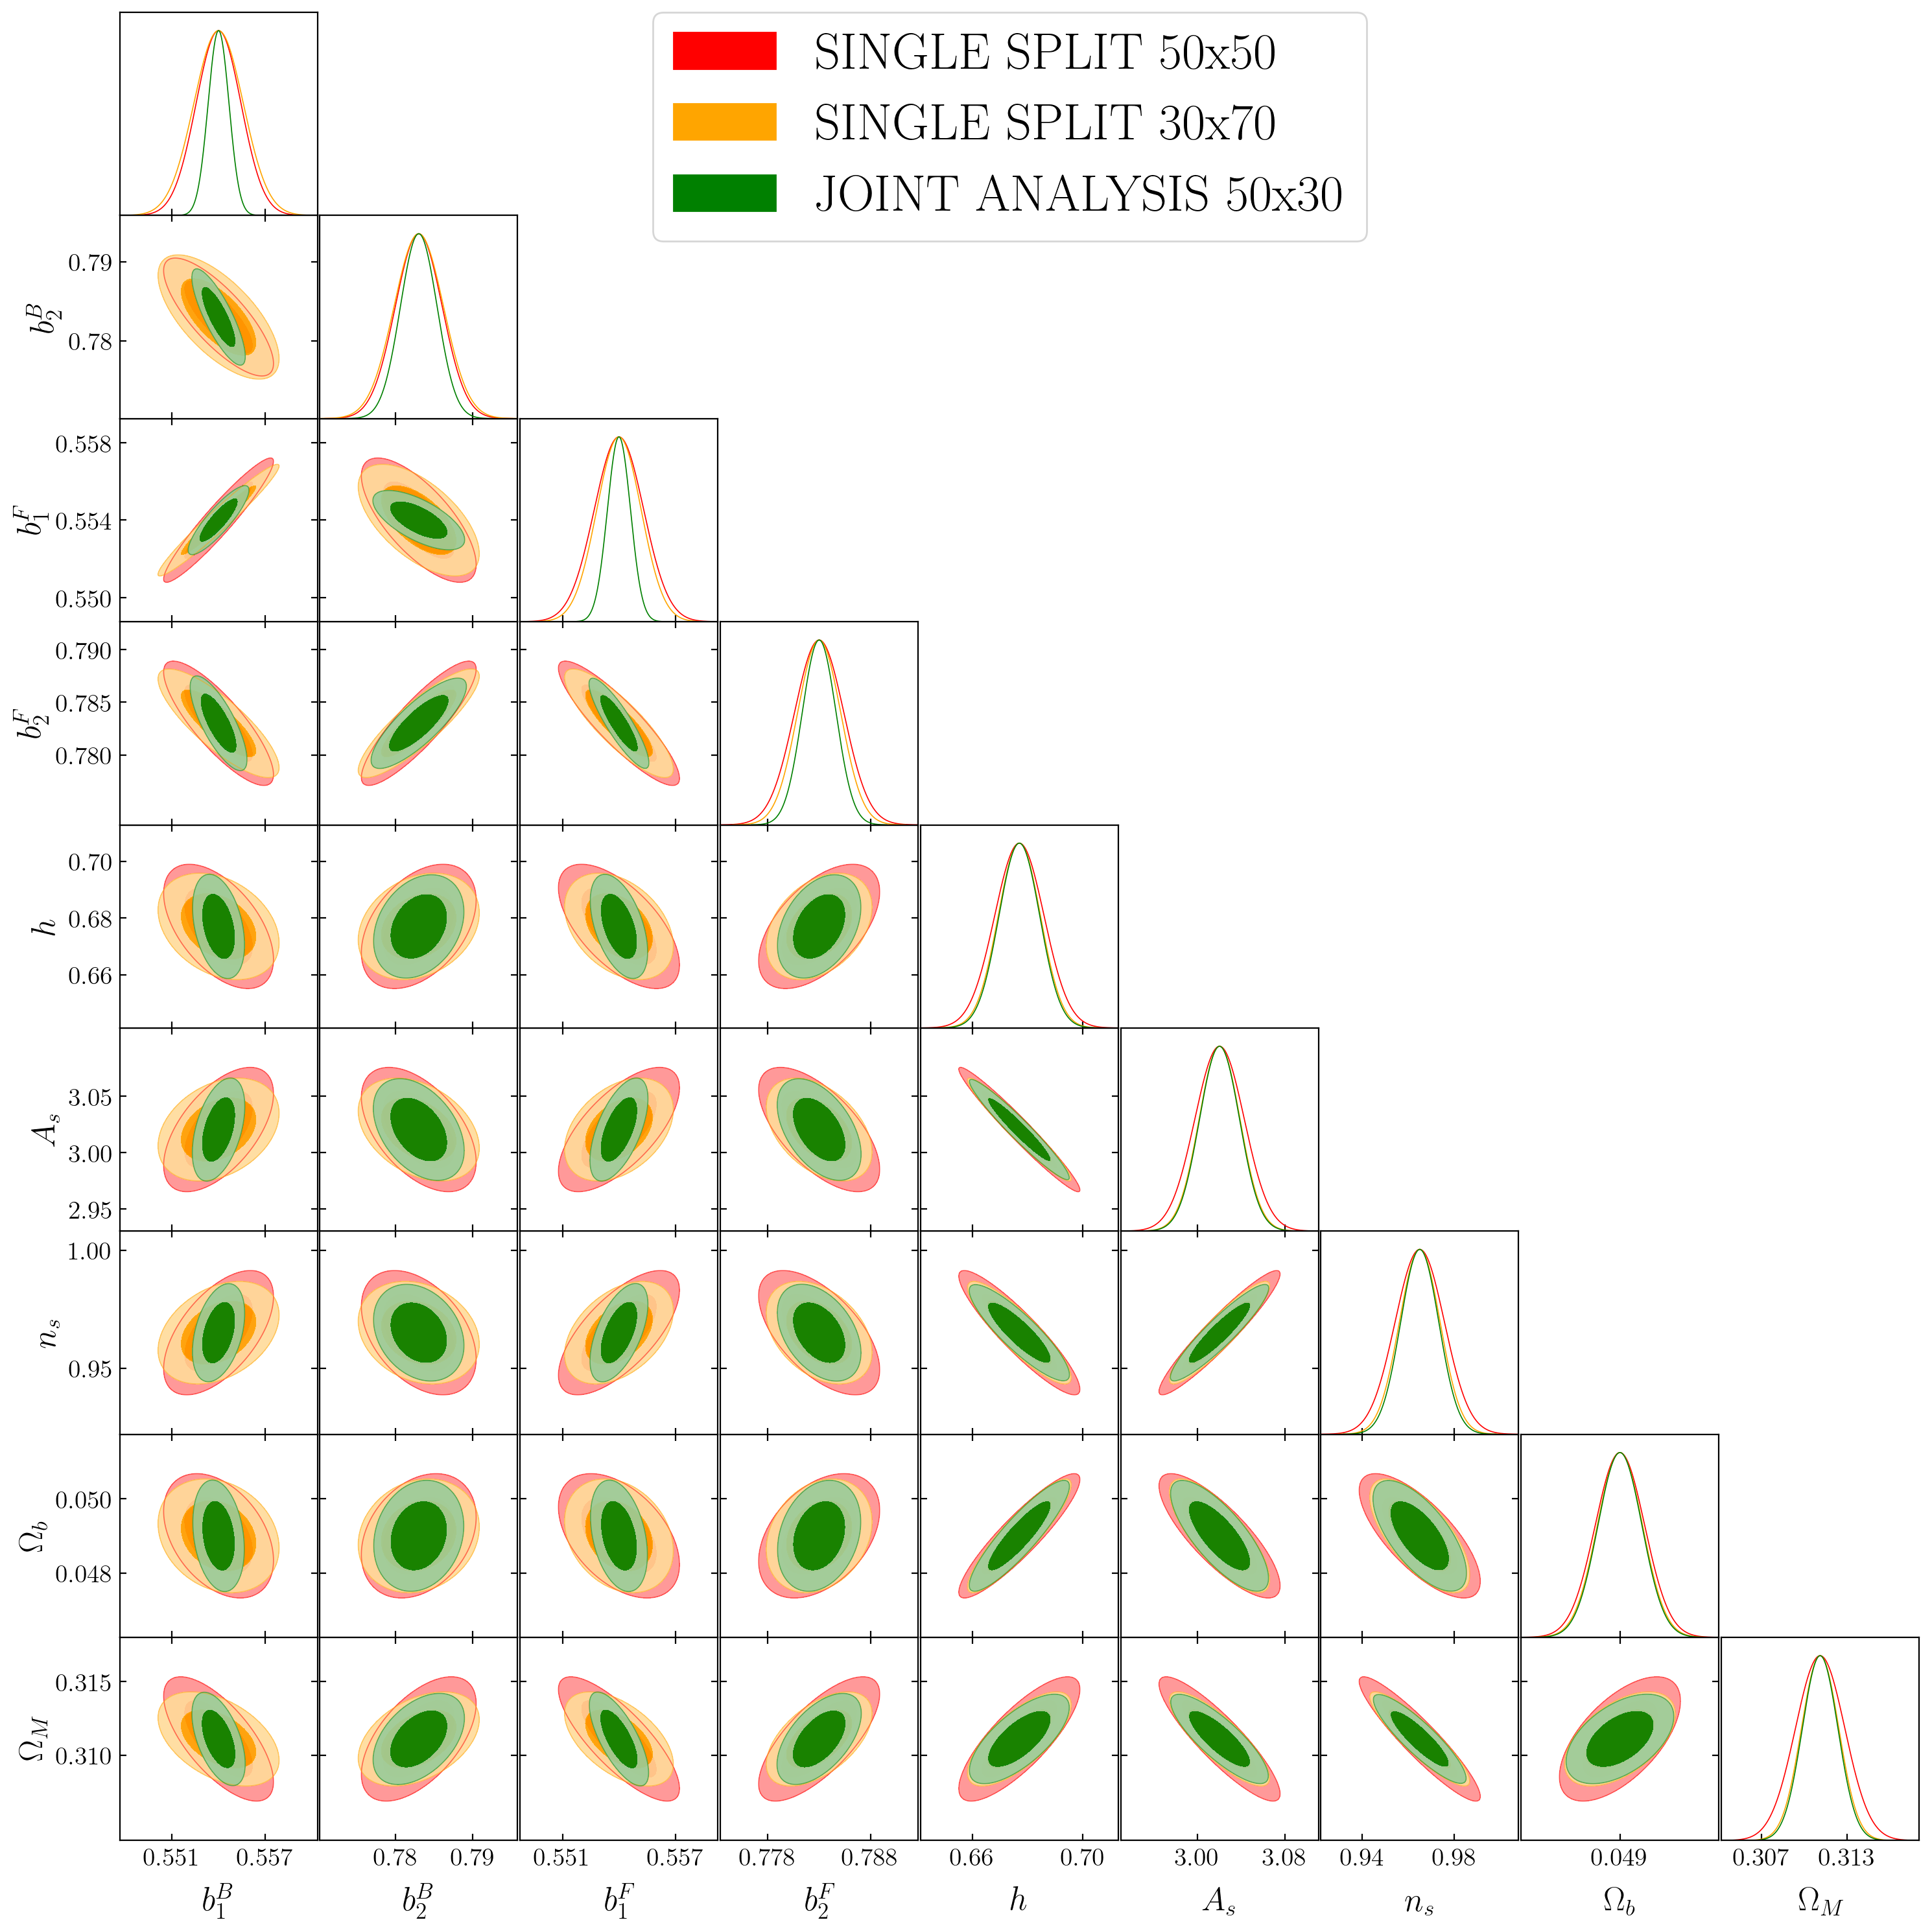

In [167]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}', r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# Predictions from the JOINT ANALYSIS

## Magnification bias

In [168]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

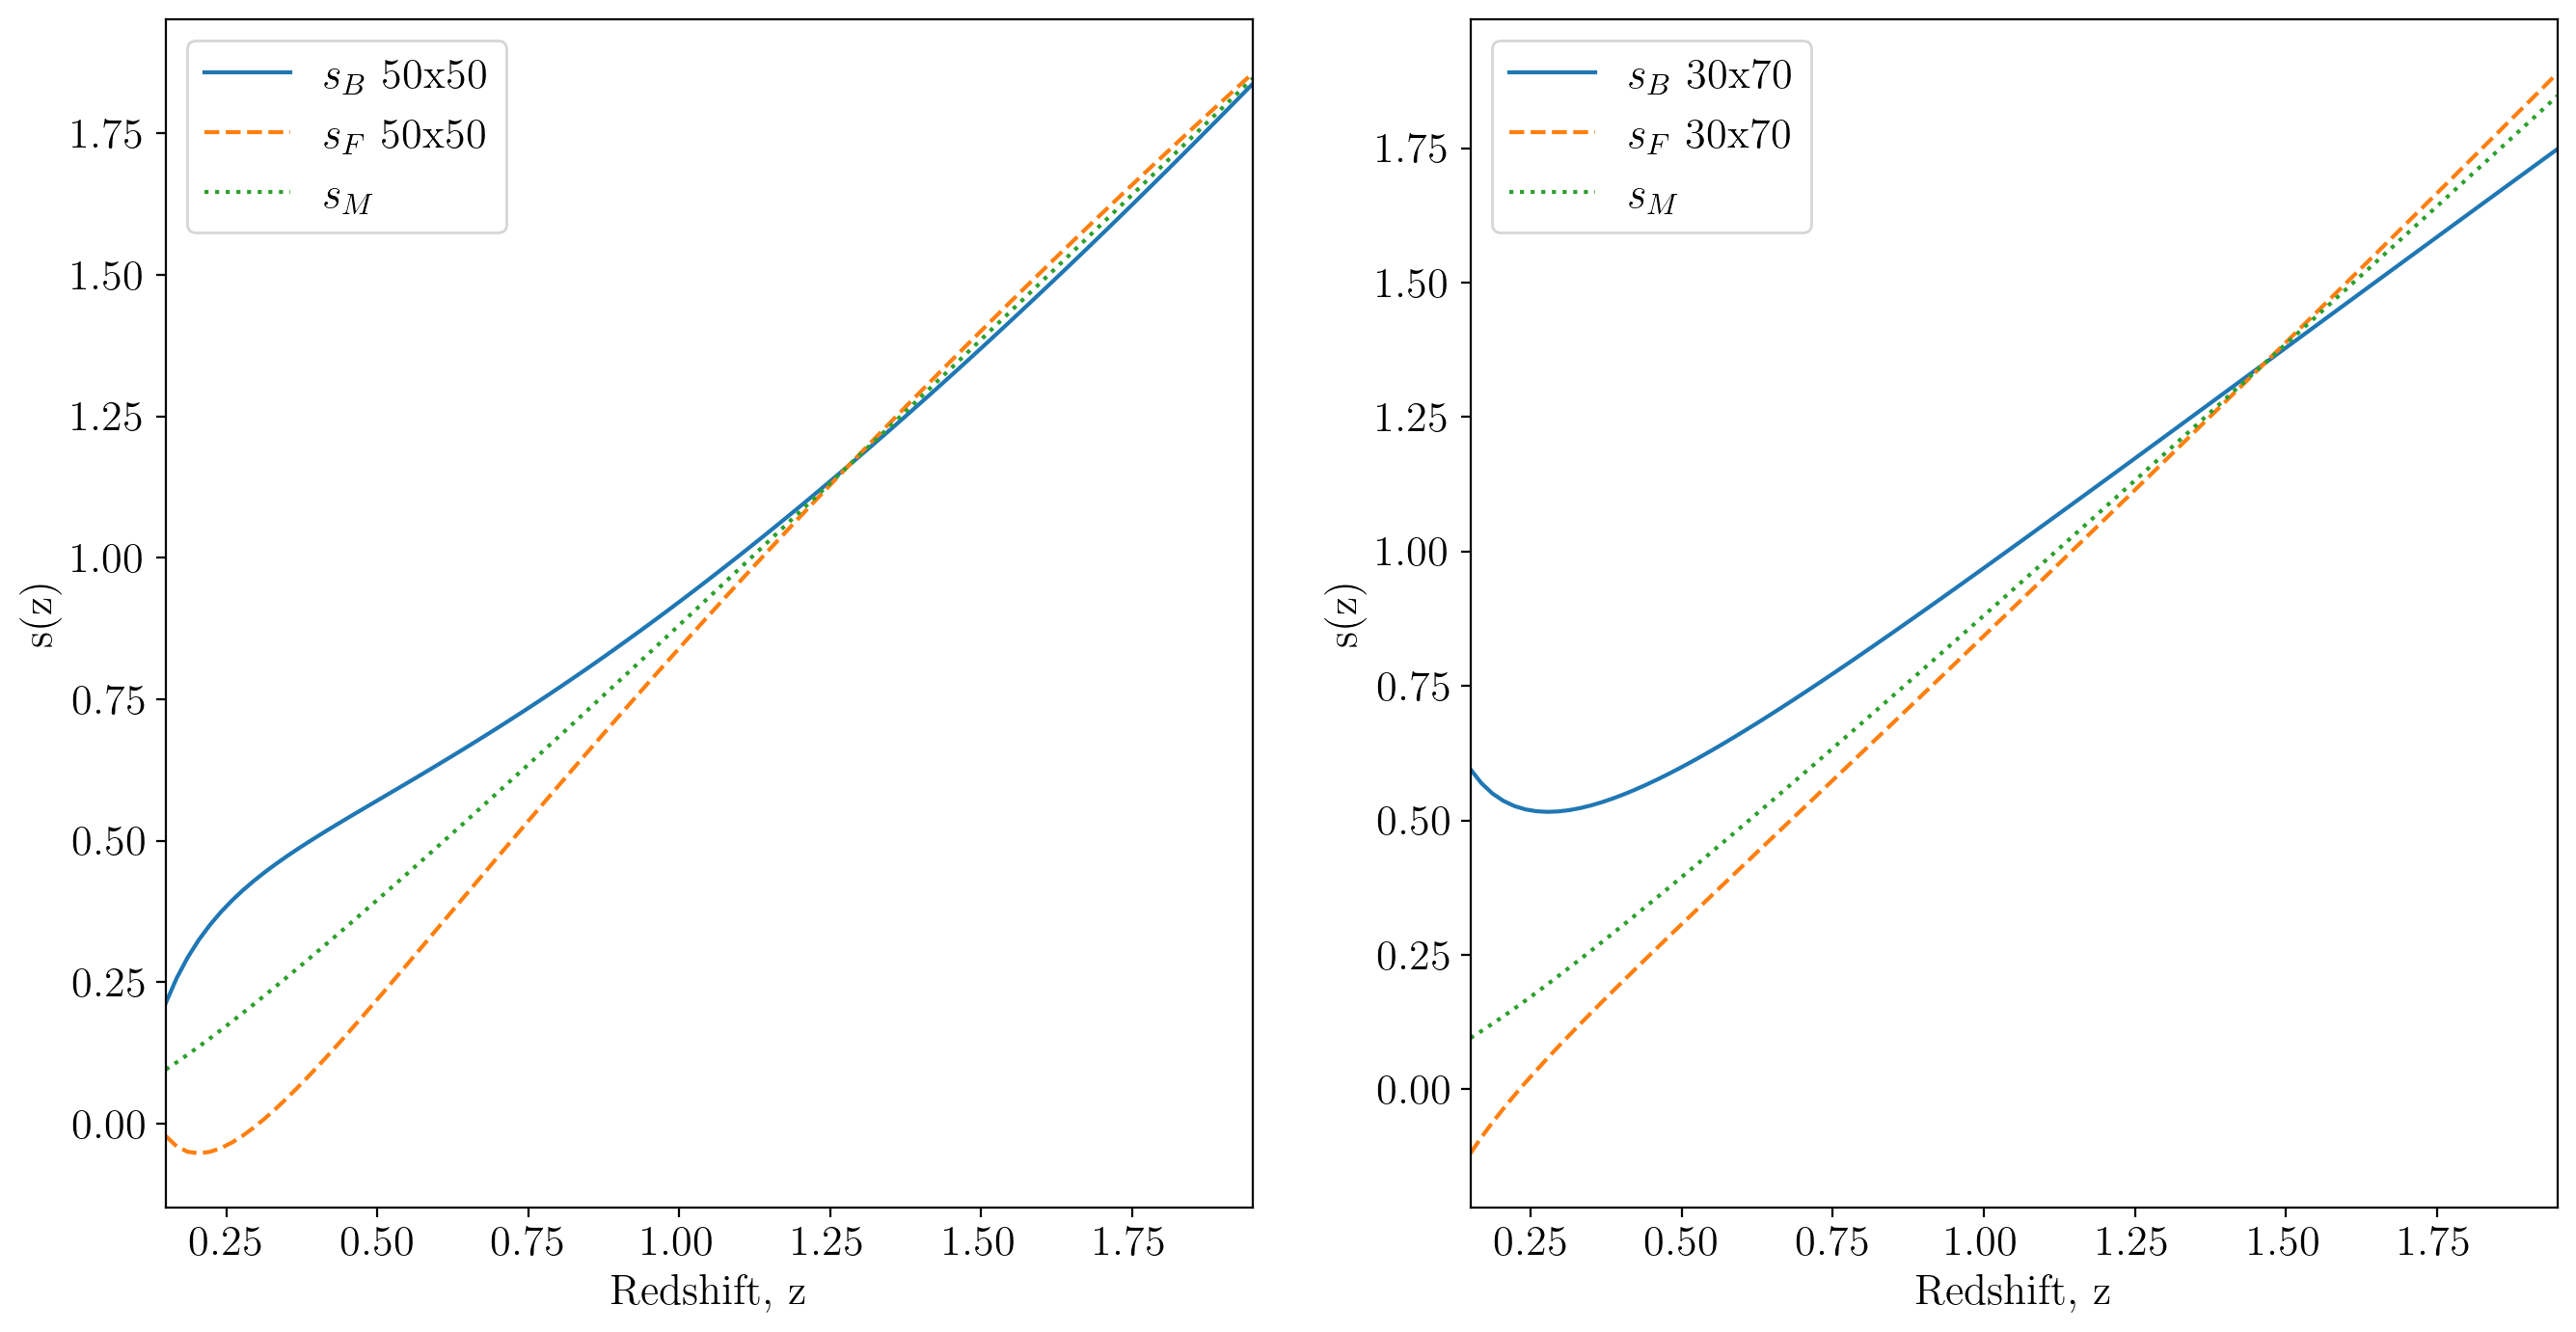

In [169]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [170]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


###### Compare the two observables

In [171]:
Sigma_Matrix_Joint50x30[:4, :4]

array([[ 0.05174147, -0.0432519 ,  0.04543503,  0.01159858],
       [-0.04325192,  0.06747404, -0.03521433, -0.00938083],
       [ 0.04543505, -0.03521434,  0.04399524,  0.0120683 ],
       [ 0.01159858, -0.00938084,  0.0120683 ,  0.00354591]])

In [172]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_Joint_50 = Sigma_Matrix_Joint50x30[:4, :4]
cov_sB_Joint_30 = Sigma_Matrix_Joint50x30[4:8, 4:8]
cov_sM_Joint = Sigma_Matrix_Joint50x30[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_Joint_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_Joint_50, num_samples)
sB_Joint_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_Joint_30, num_samples)
sM_Joint_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_Joint, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_50_pars_samples])
sB_Joint_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_30_pars_samples])
sM_Joint_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_Joint_pars_samples])

# Calculate the 68% confidence interval
sB_Joint_50_lower_bound = np.percentile(sB_Joint_50_samples, 16, axis=0)
sB_Joint_50_upper_bound = np.percentile(sB_Joint_50_samples, 84, axis=0)

sB_Joint_30_lower_bound = np.percentile(sB_Joint_30_samples, 16, axis=0)
sB_Joint_30_upper_bound = np.percentile(sB_Joint_30_samples, 84, axis=0)

sM_Joint_lower_bound = np.percentile(sM_Joint_samples, 16, axis=0)
sM_Joint_upper_bound = np.percentile(sM_Joint_samples, 84, axis=0)

/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_6172/1626701290.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sB_Joint_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_Joint_50, num_samples)
/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_6172/1626701290.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sB_Joint_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_Joint_30, num_samples)


Predictions for $s_B(z)$ vs Priors

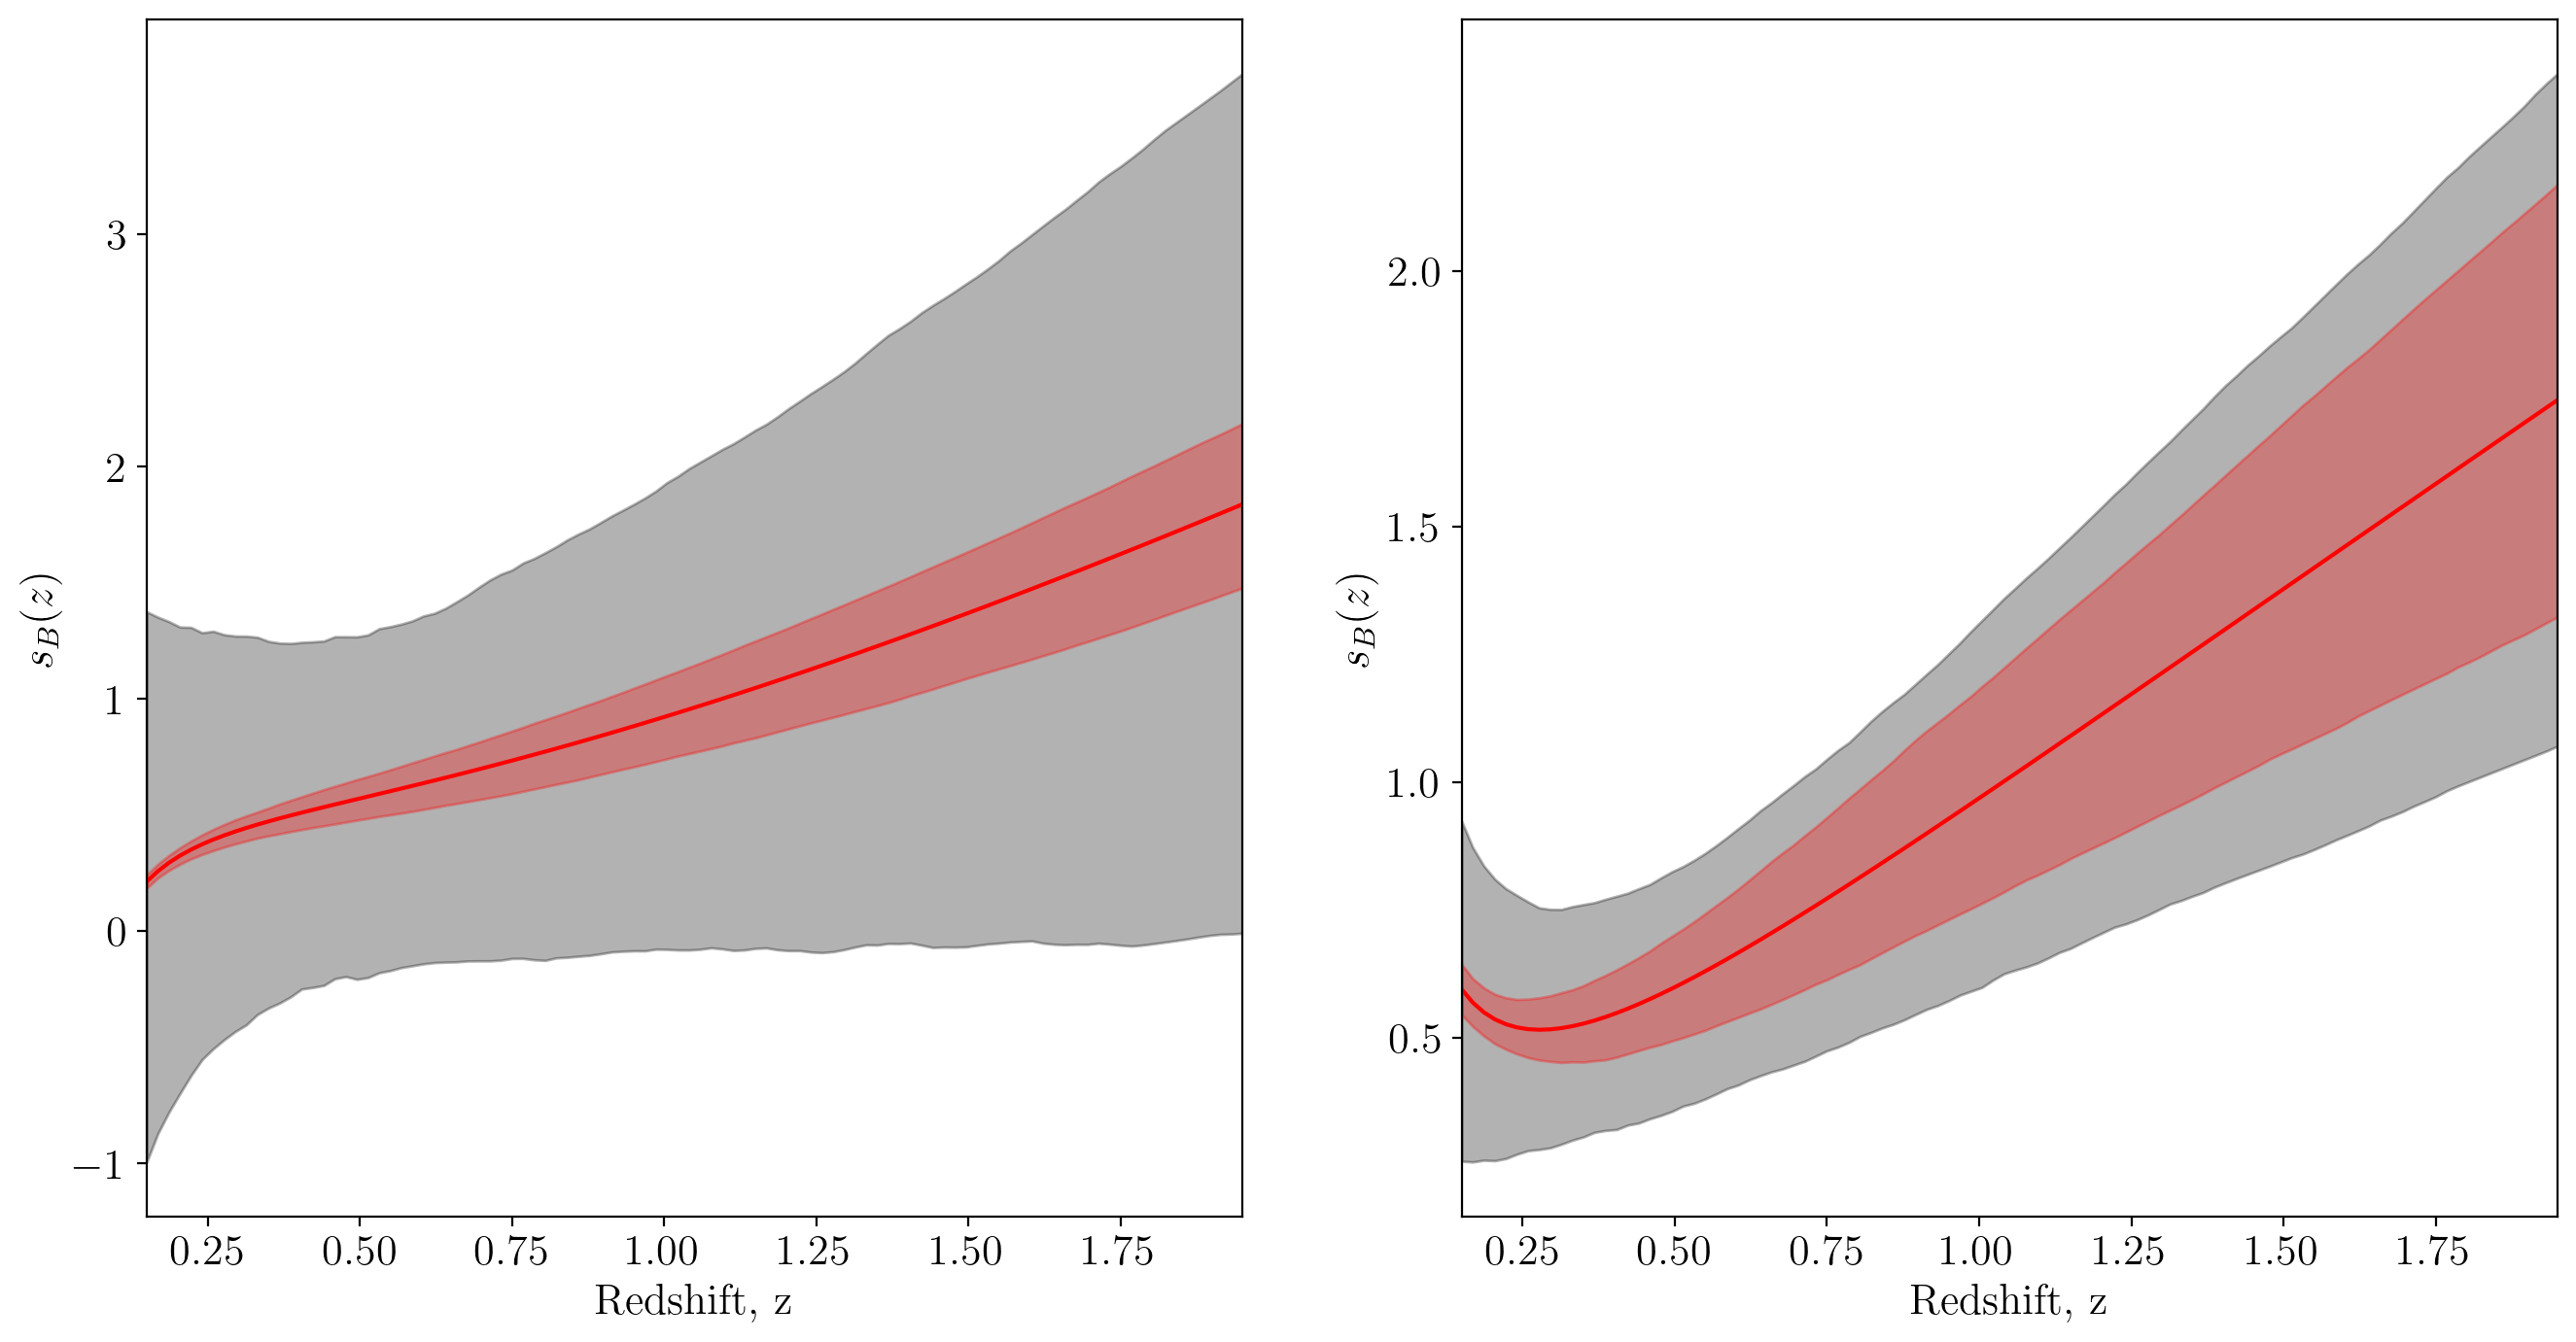

In [173]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3)
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3)

ax[1].plot(z_lin, sB_fid_30, 'r-')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

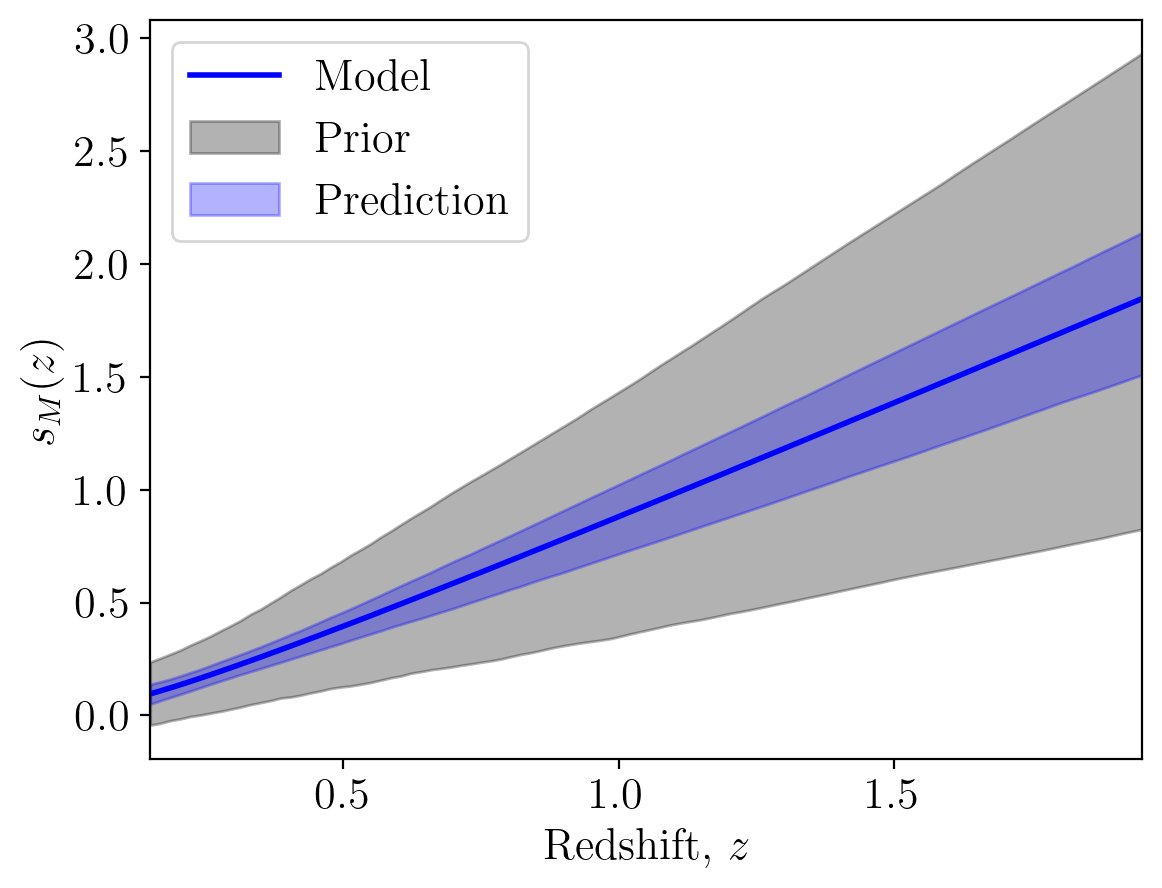

In [174]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
plt.fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.legend(loc='upper left');

### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [175]:
sbias_fid = np.concatenate([sB_4fit50, sB_4fit30, sM_4fit])

np.shape(sbias_fid)

(12,)

In [176]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias = Sigma_Matrix_Joint50x30[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_Joint_pars_samples = np.random.multivariate_normal(sbias_fid, cov_sbias, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_Joint_pars_samples])
sB_Joint_30_samples_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_Joint_pars_samples])
sM_Joint_samples_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_Joint_pars_samples])

# Compute the sF for each sample
sF_50_samples_ = sM_Joint_samples_*m_50/(m_50-1) - sB_Joint_50_samples_/(m_50-1)
sF_30_samples_ = sM_Joint_samples_*m_30/(m_30-1) - sB_Joint_30_samples_/(m_30-1)


# Calculate the 68% confidence interval
sF_50_Joint_lower_bound_ = np.percentile(sF_50_samples_, 16, axis=0)
sF_50_Joint_upper_bound_ = np.percentile(sF_50_samples_, 84, axis=0)

sF_30_Joint_lower_bound_ = np.percentile(sF_30_samples_, 16, axis=0)
sF_30_Joint_upper_bound_ = np.percentile(sF_30_samples_, 84, axis=0)

/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_6172/4032778912.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sbias_Joint_pars_samples = np.random.multivariate_normal(sbias_fid, cov_sbias, num_samples)


Compare with priors

In [177]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors_ = Cov_prior_all[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_pars_samples_priors_ = np.random.multivariate_normal(sbias_fid, cov_sbias_priors_, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples_priors_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors_])
sB_30_samples_priors_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors_])
sM_samples_priors_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_pars_samples_priors_])

# Compute the sF for each sample
sF_50_samples_priors_ = sM_samples_priors_*m_50/(m_50-1) - sB_50_samples_priors_/(m_50-1)
sF_30_samples_priors_ = sM_samples_priors_*m_30/(m_30-1) - sB_30_samples_priors_/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors_ = np.percentile(sF_50_samples_priors_, 16, axis=0)
sF_50_upper_bound_priors_ = np.percentile(sF_50_samples_priors_, 84, axis=0)

sF_30_lower_bound_priors_ = np.percentile(sF_30_samples_priors_, 16, axis=0)
sF_30_upper_bound_priors_ = np.percentile(sF_30_samples_priors_, 84, axis=0)

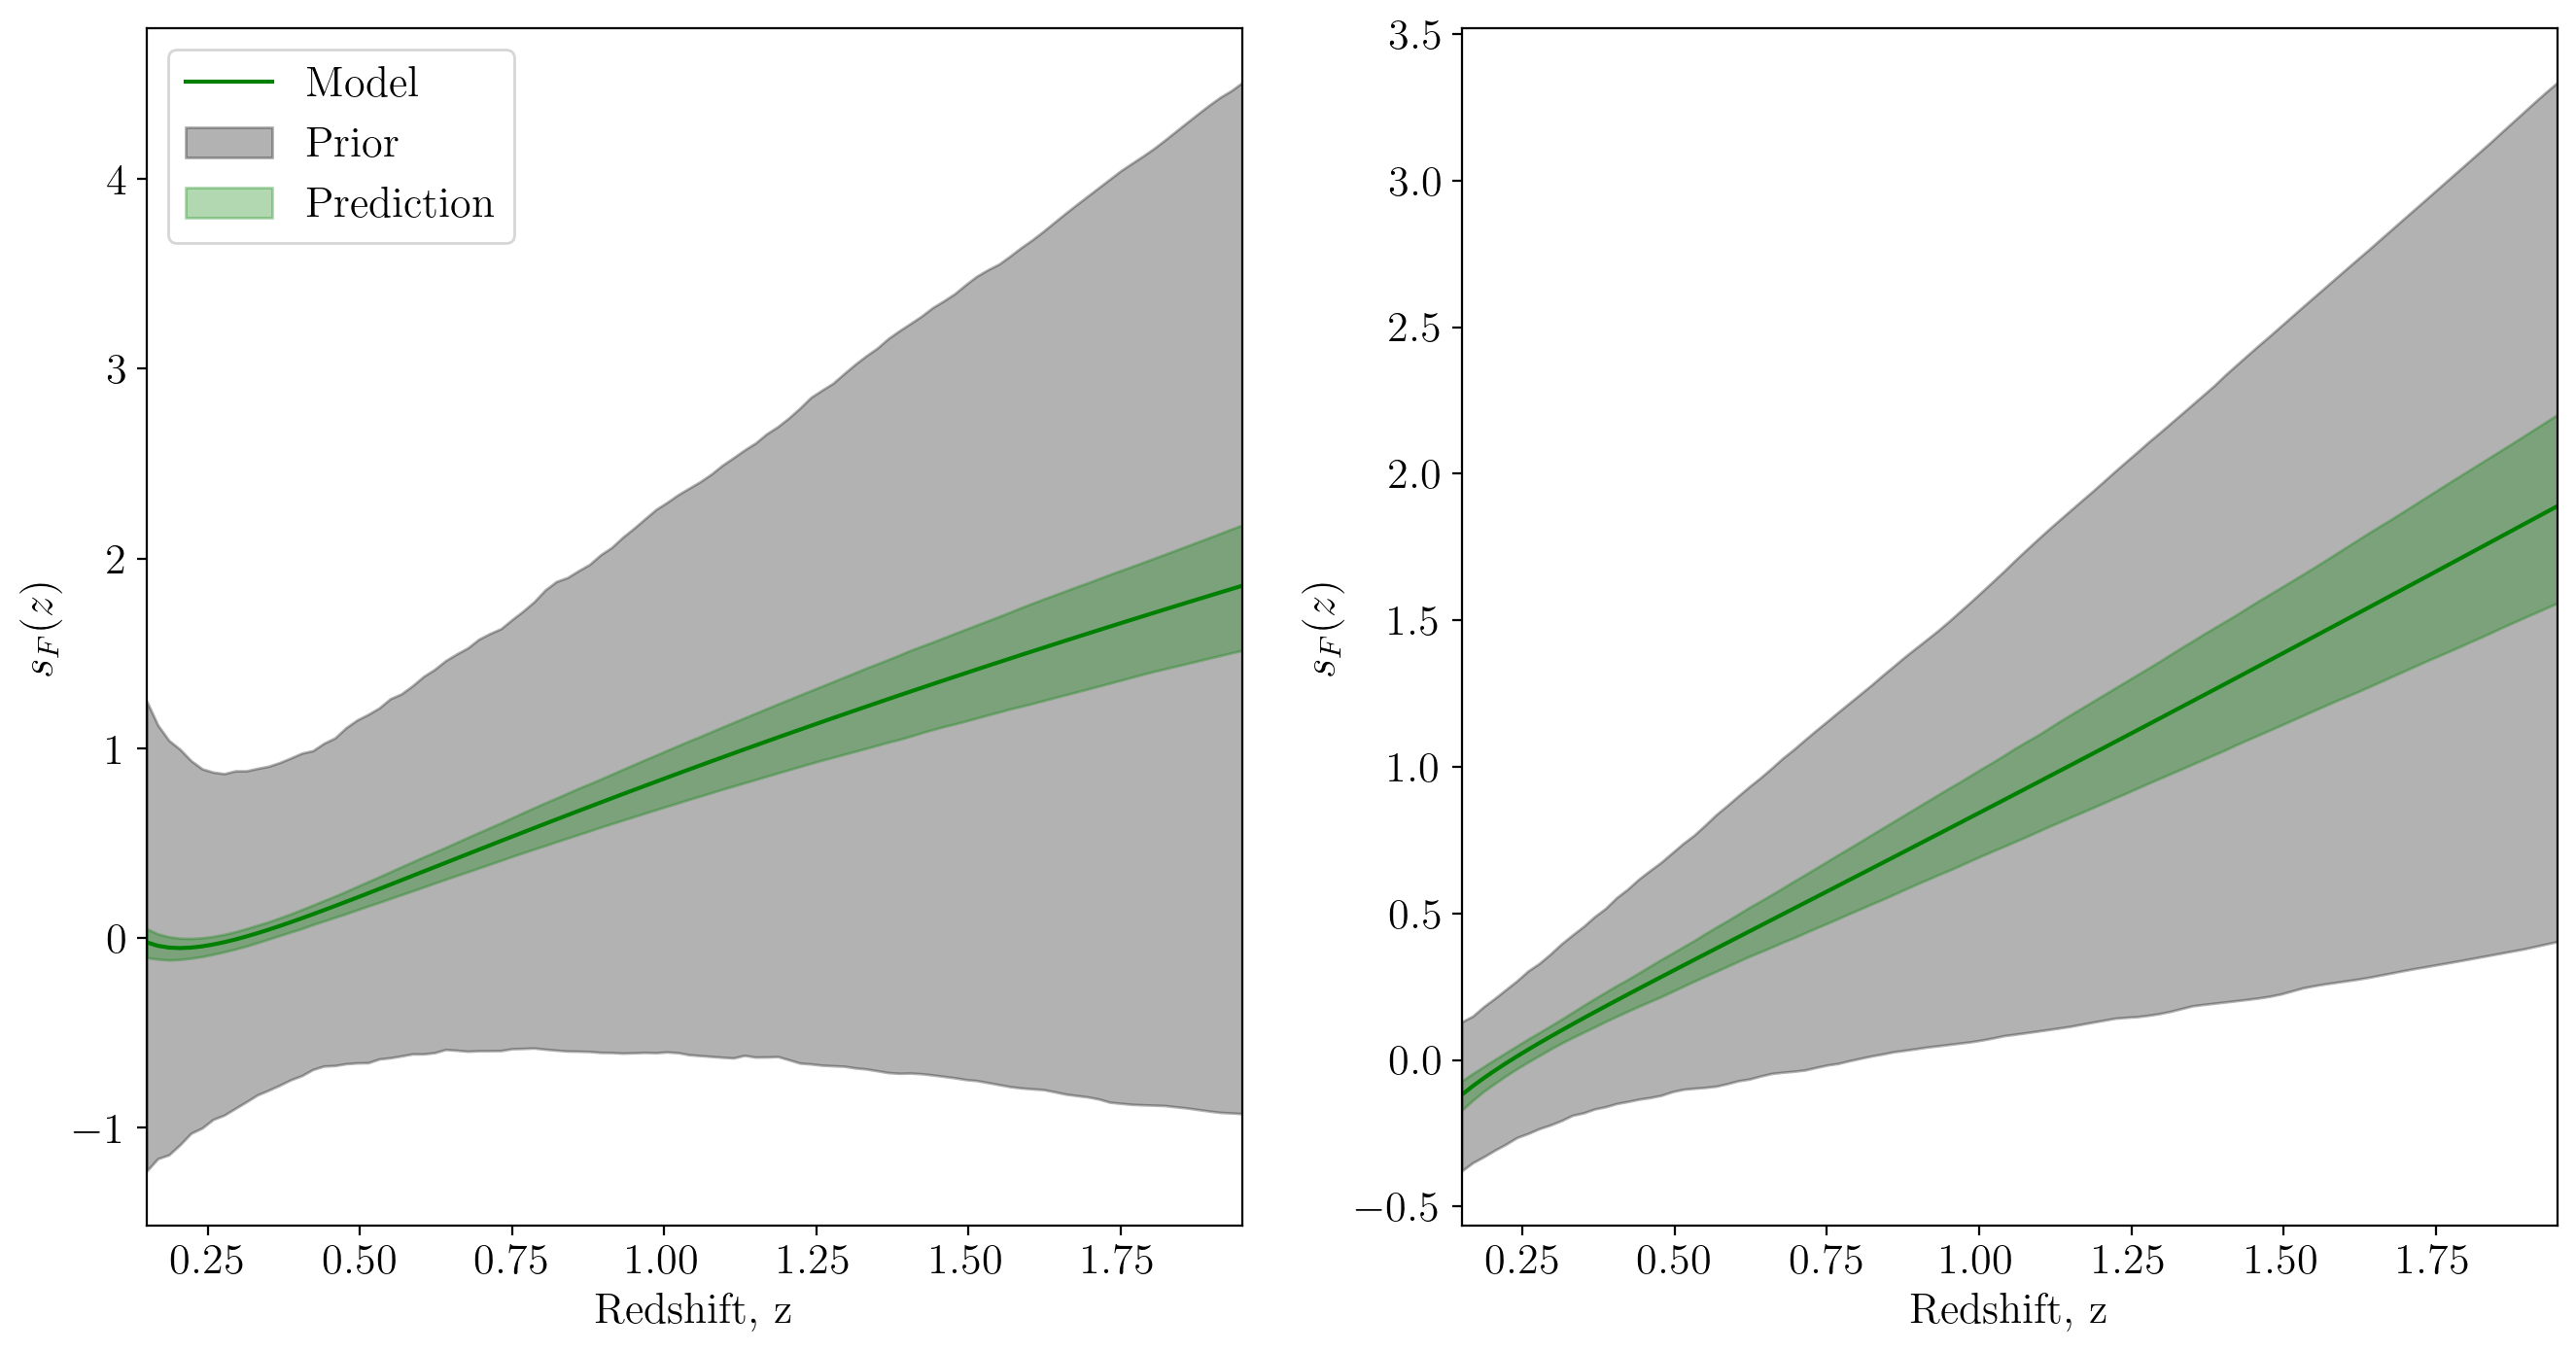

In [178]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'green', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'green')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3)

ax[0].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')

## Number evolution

In [179]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

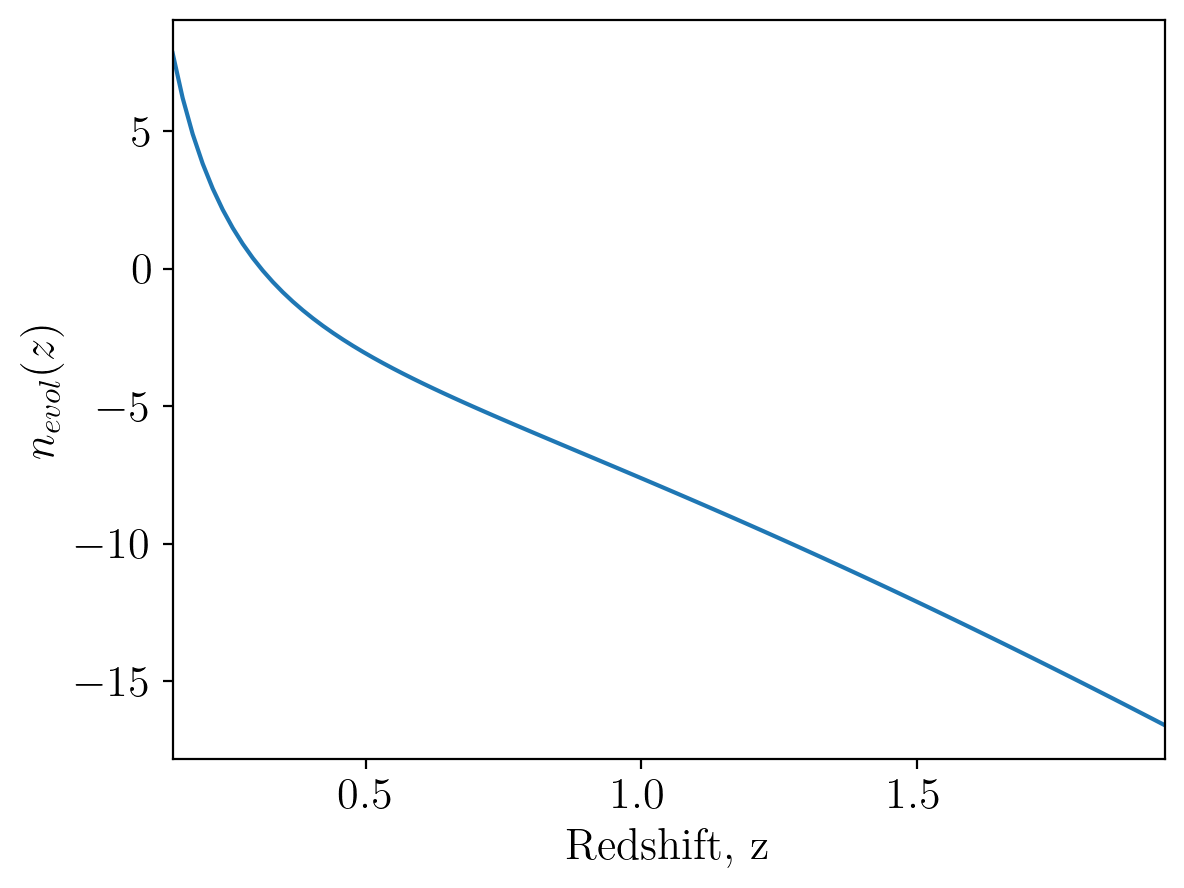

In [180]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [181]:
# Select the marginalized covariance matrix for the number evolution
cov_Joint_numevol = Sigma_Matrix_Joint50x30[12:16, 12:16]
cov_numevol_priors = Cov_prior_all[12:16, 12:16]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_Joint_pars_samples = np.random.multivariate_normal(num_fit, cov_Joint_numevol, num_samples)
nevol_samples_priors = np.random.multivariate_normal(num_fit, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_Joint_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_Joint_pars_samples])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_Joint_lower_bound = np.percentile(nevol_Joint_samples, 16, axis=0)
nevol_Joint_upper_bound = np.percentile(nevol_Joint_samples, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_6172/651912434.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  nevol_Joint_pars_samples = np.random.multivariate_normal(num_fit, cov_Joint_numevol, num_samples)


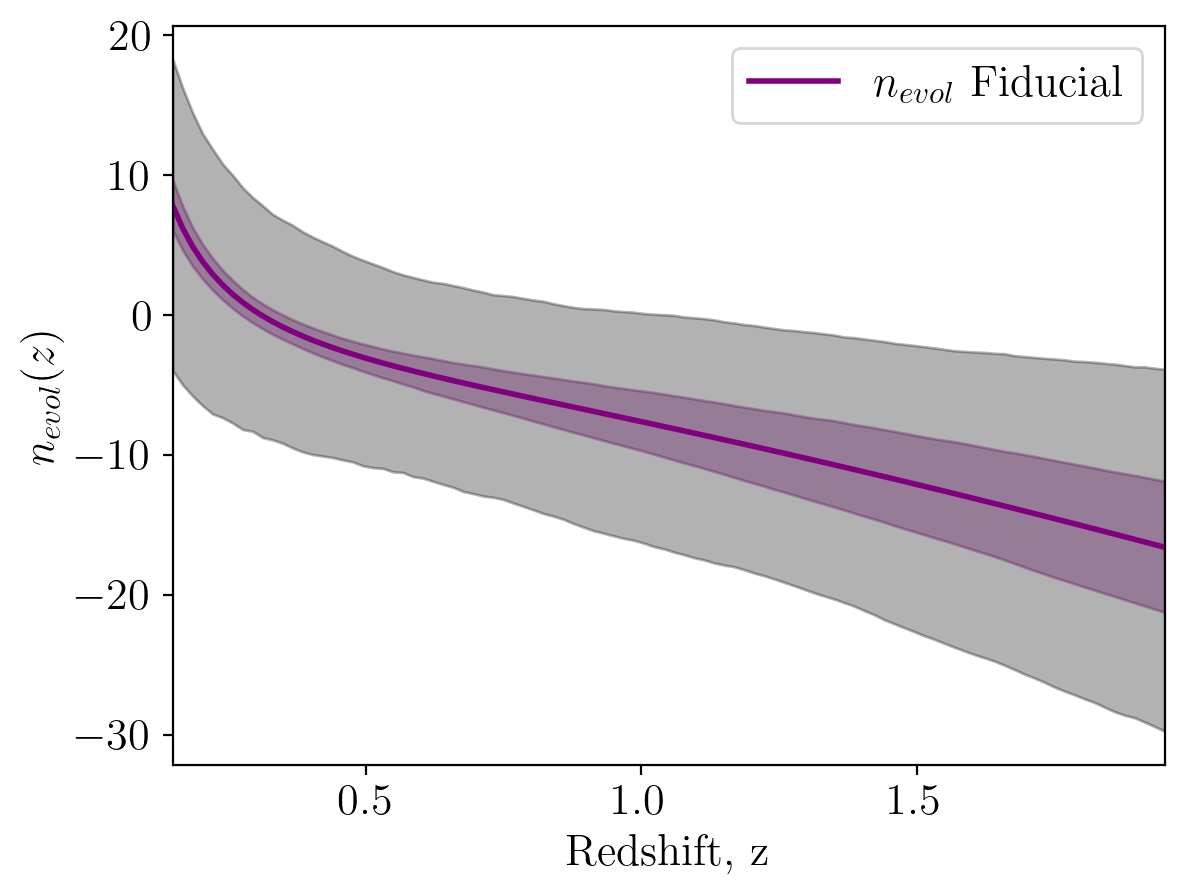

In [182]:
plt.plot(z_lin, num_evol_fid, '-', color='purple', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='purple', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [183]:
from biasmodels import EvolutionBias

In [184]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [185]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [186]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

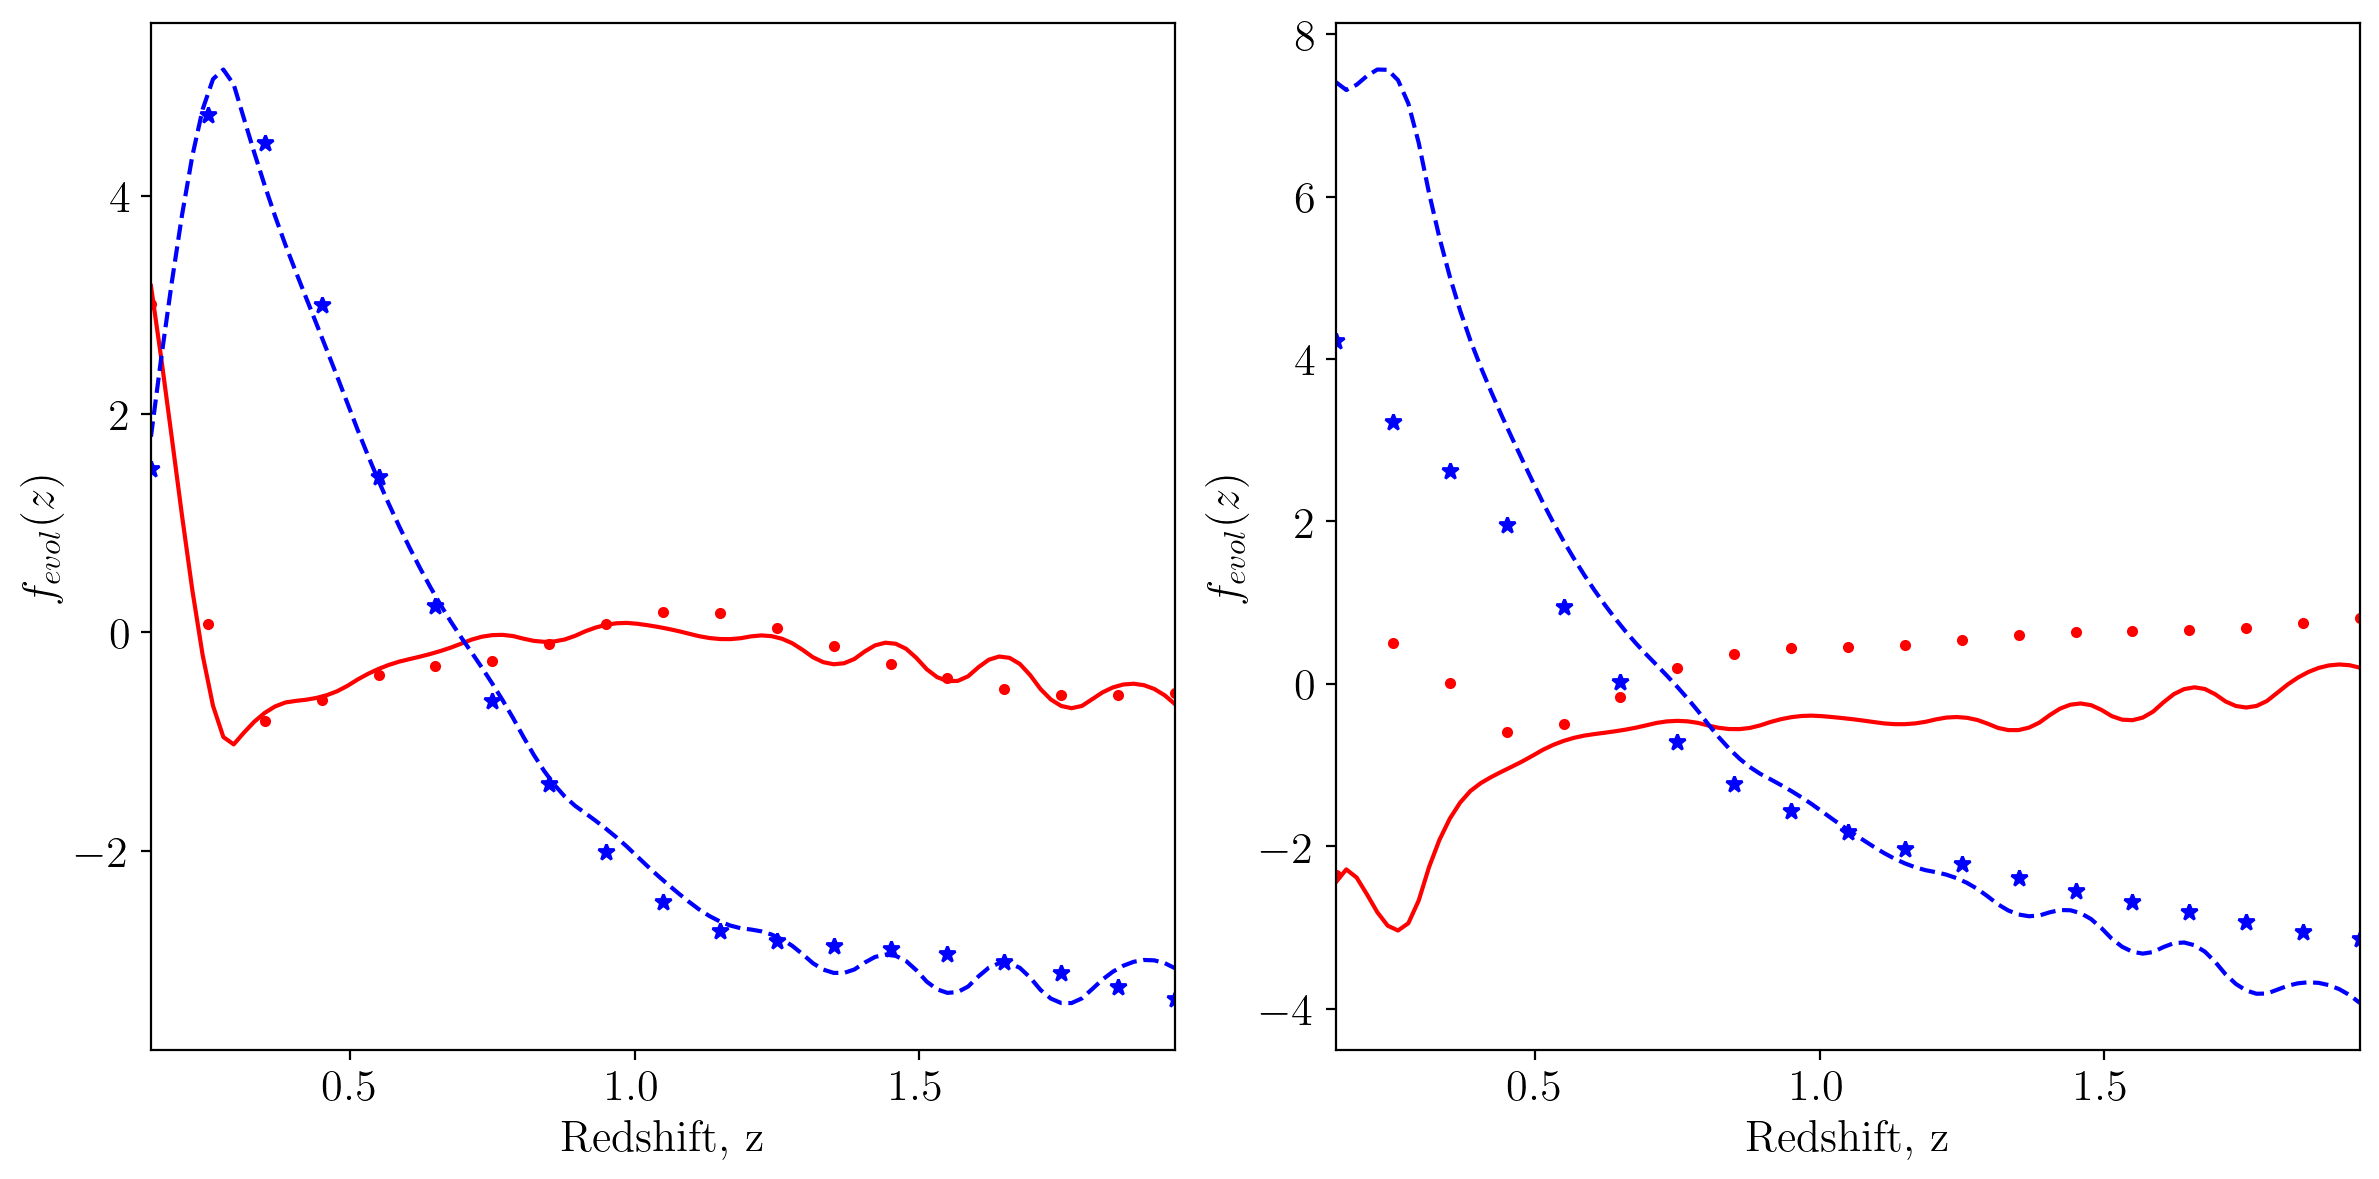

In [187]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [188]:
list(range(4,8))

[4, 5, 6, 7]

In [189]:
# Select the marginalized covariance matrix for the parameters

cov_Joint_all = Sigma_Matrix_Joint50x30[:16, :16]
cov_all_priors = Cov_prior_all[:16, :16]

all_fid = np.concatenate([sbias_fid, num_fit])

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_Joint_pars_samples = np.random.multivariate_normal(all_fid, cov_Joint_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

nind_50 = list(range(4,8))

all_Joint_50_pars_samples = all_Joint_pars_samples
all_Joint_50_pars_samples = np.delete(all_Joint_50_pars_samples, nind_50, axis=1)
all_50_pars_samples_priors = all_pars_samples_priors
all_50_pars_samples_priors = np.delete(all_50_pars_samples_priors, nind_50, axis=1)

nind_30 = list(range(0,4))

all_Joint_30_pars_samples = all_Joint_pars_samples
all_Joint_30_pars_samples = np.delete(all_Joint_30_pars_samples, nind_30, axis=1)
all_30_pars_samples_priors = all_pars_samples_priors
all_30_pars_samples_priors = np.delete(all_30_pars_samples_priors, nind_30, axis=1)

/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_6172/3731048342.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  all_Joint_pars_samples = np.random.multivariate_normal(all_fid, cov_Joint_all, num_samples)


In [190]:
# Evaluate fitting function for each parameter sample

fevol_Joint_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])
fevol_Joint_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])

fevol_Joint_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])
fevol_Joint_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound = np.percentile(fevol_Joint_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound = np.percentile(fevol_Joint_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 16, axis=0)
fevol_B_50_upper_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 84, axis=0)

fevol_F_50_lower_bound = np.percentile(fevol_Joint_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound = np.percentile(fevol_Joint_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 16, axis=0)
fevol_F_50_upper_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 84, axis=0)

fevol_B_30_lower_bound = np.percentile(fevol_Joint_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound = np.percentile(fevol_Joint_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 16, axis=0)
fevol_B_30_upper_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 84, axis=0)

fevol_F_30_lower_bound = np.percentile(fevol_Joint_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound = np.percentile(fevol_Joint_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 16, axis=0)
fevol_F_30_upper_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 84, axis=0)

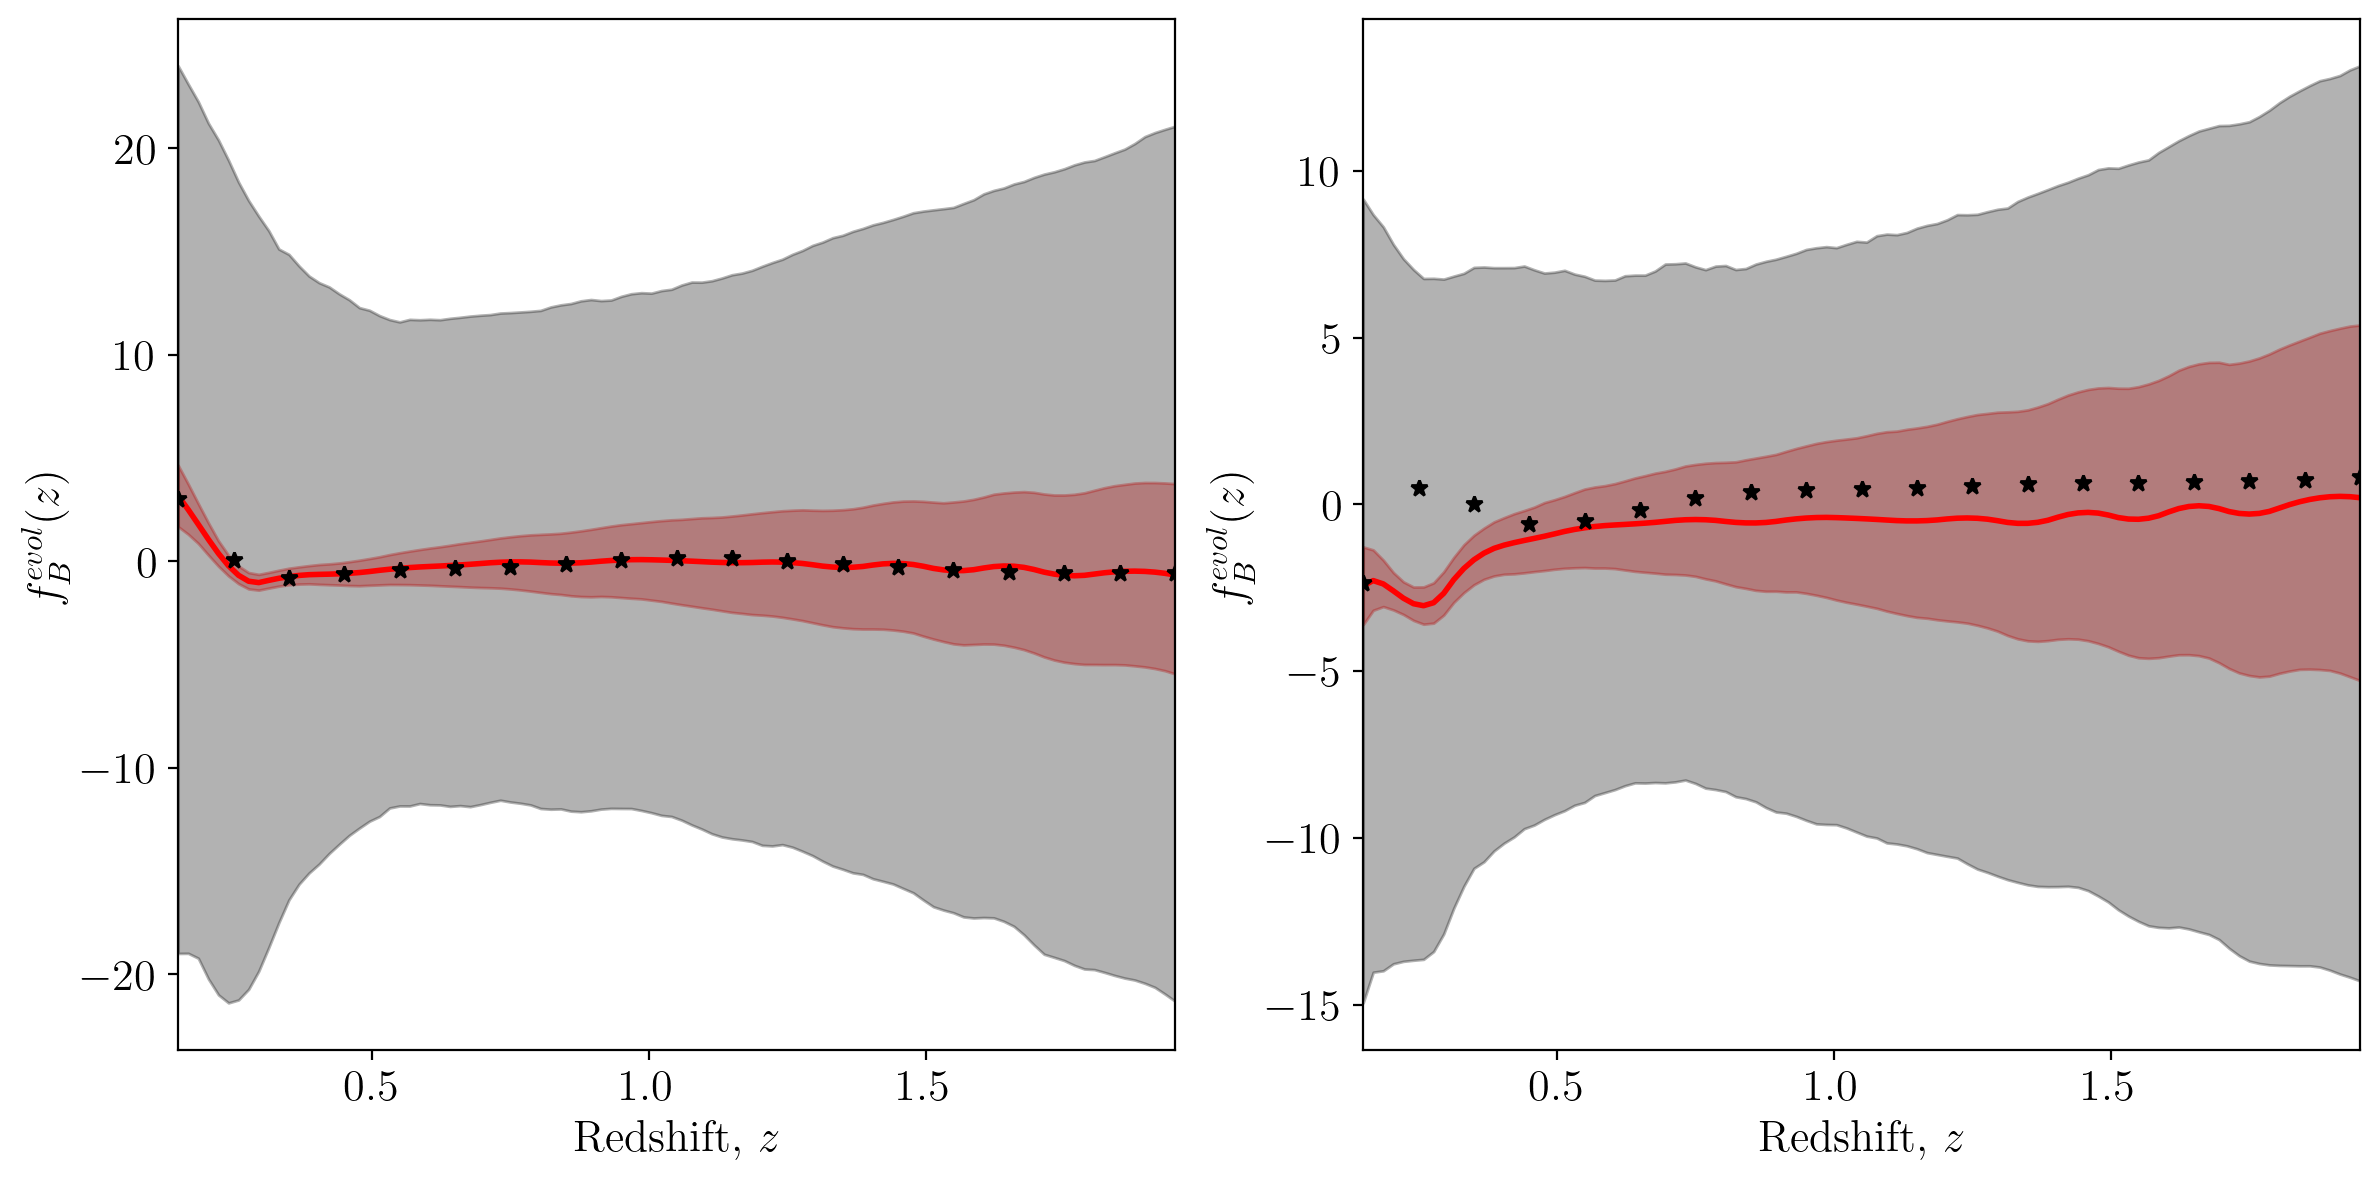

In [191]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

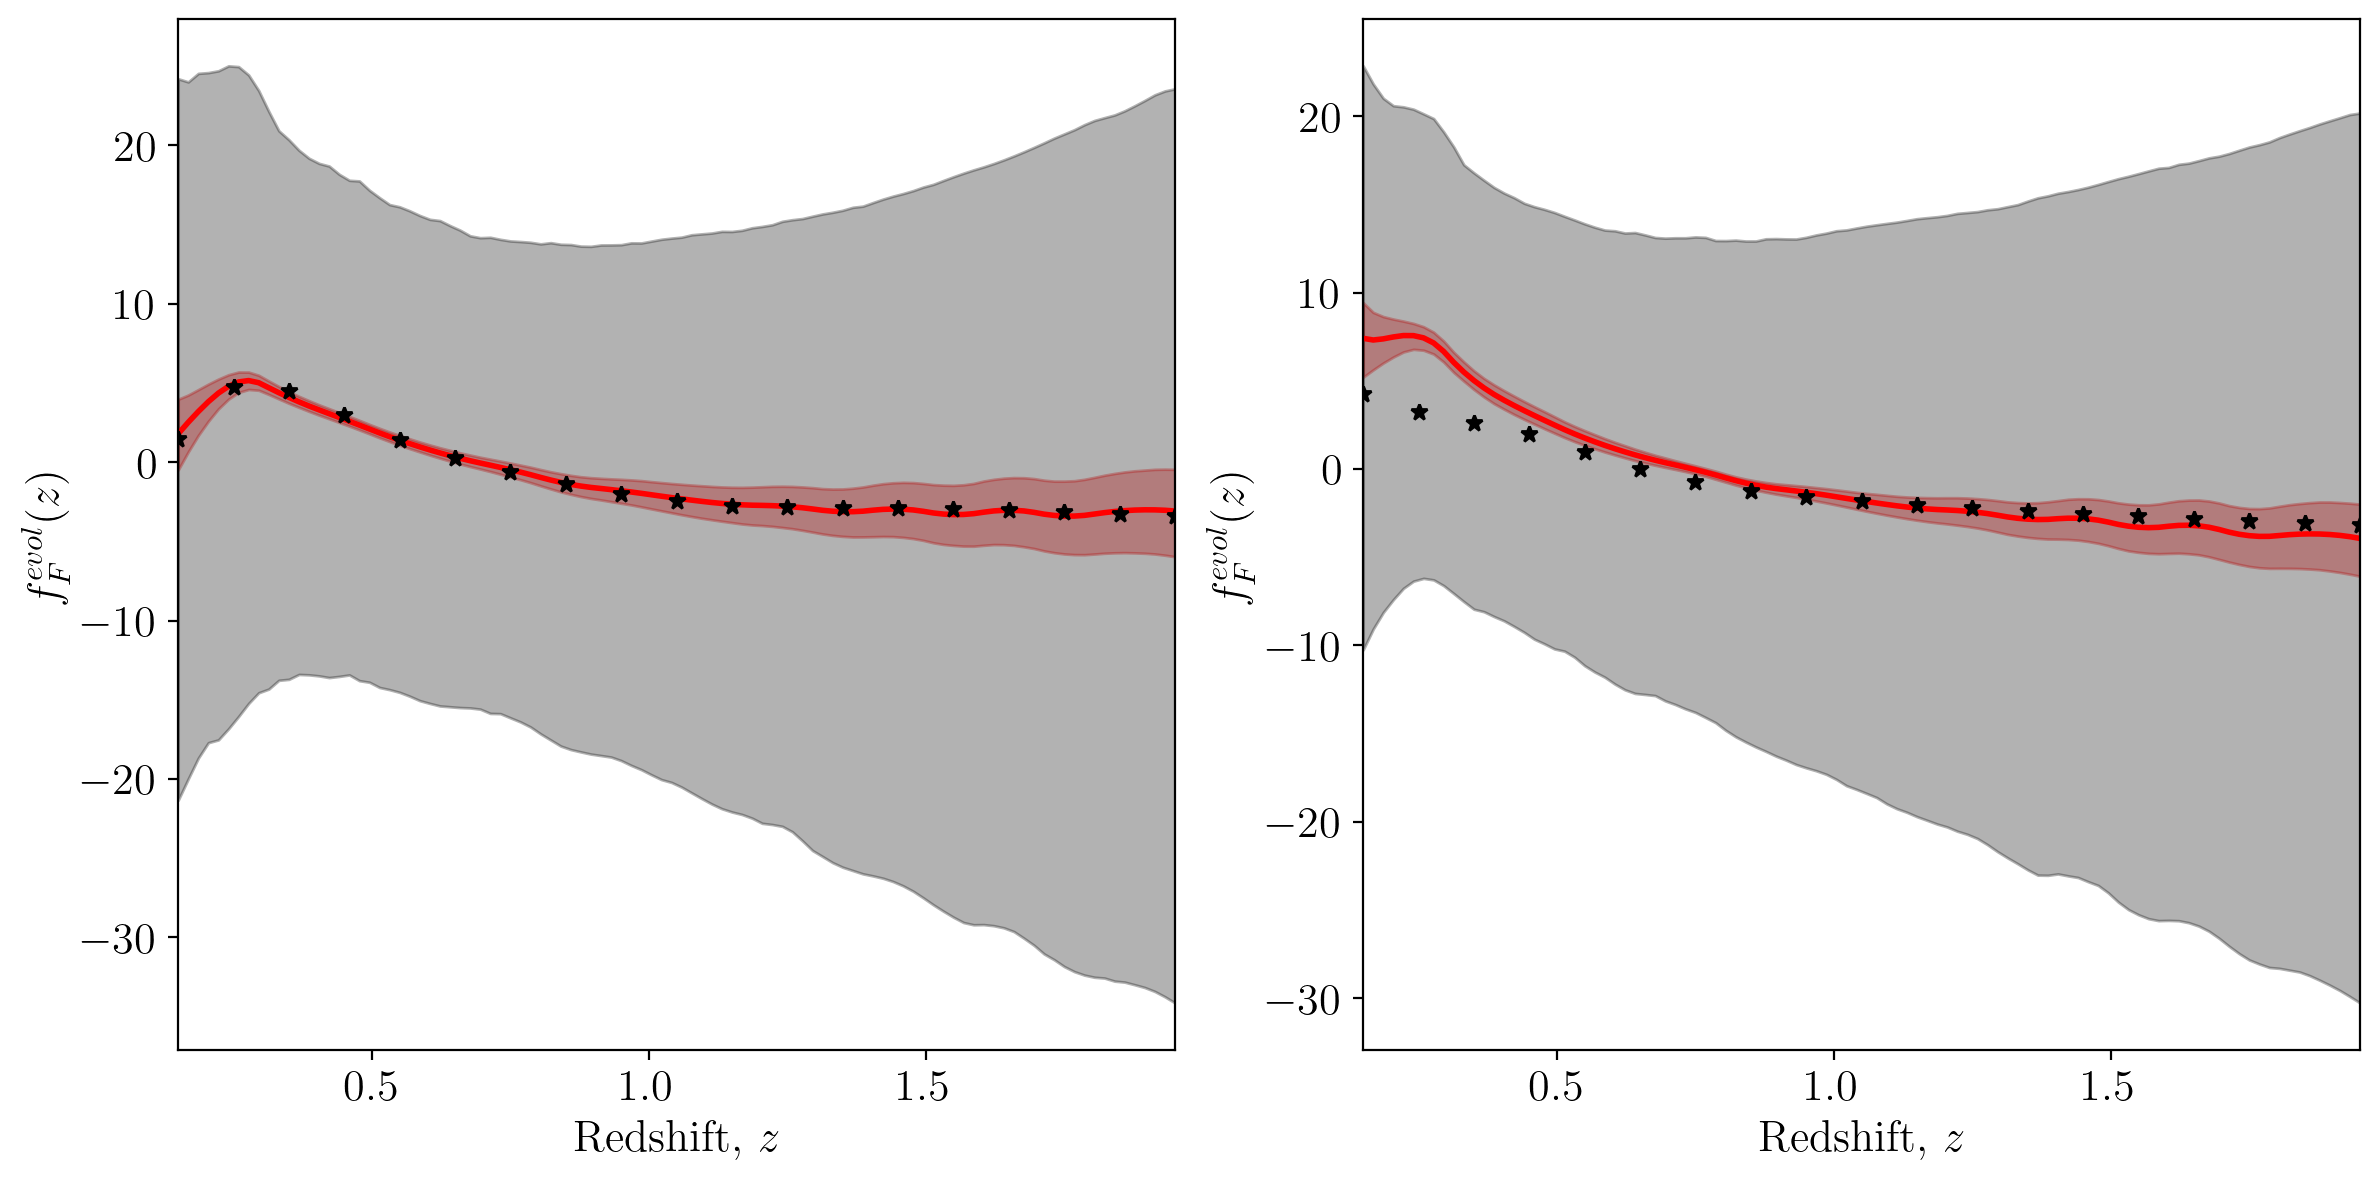

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')

# Comparison with Individual Splits

## Magnification bias

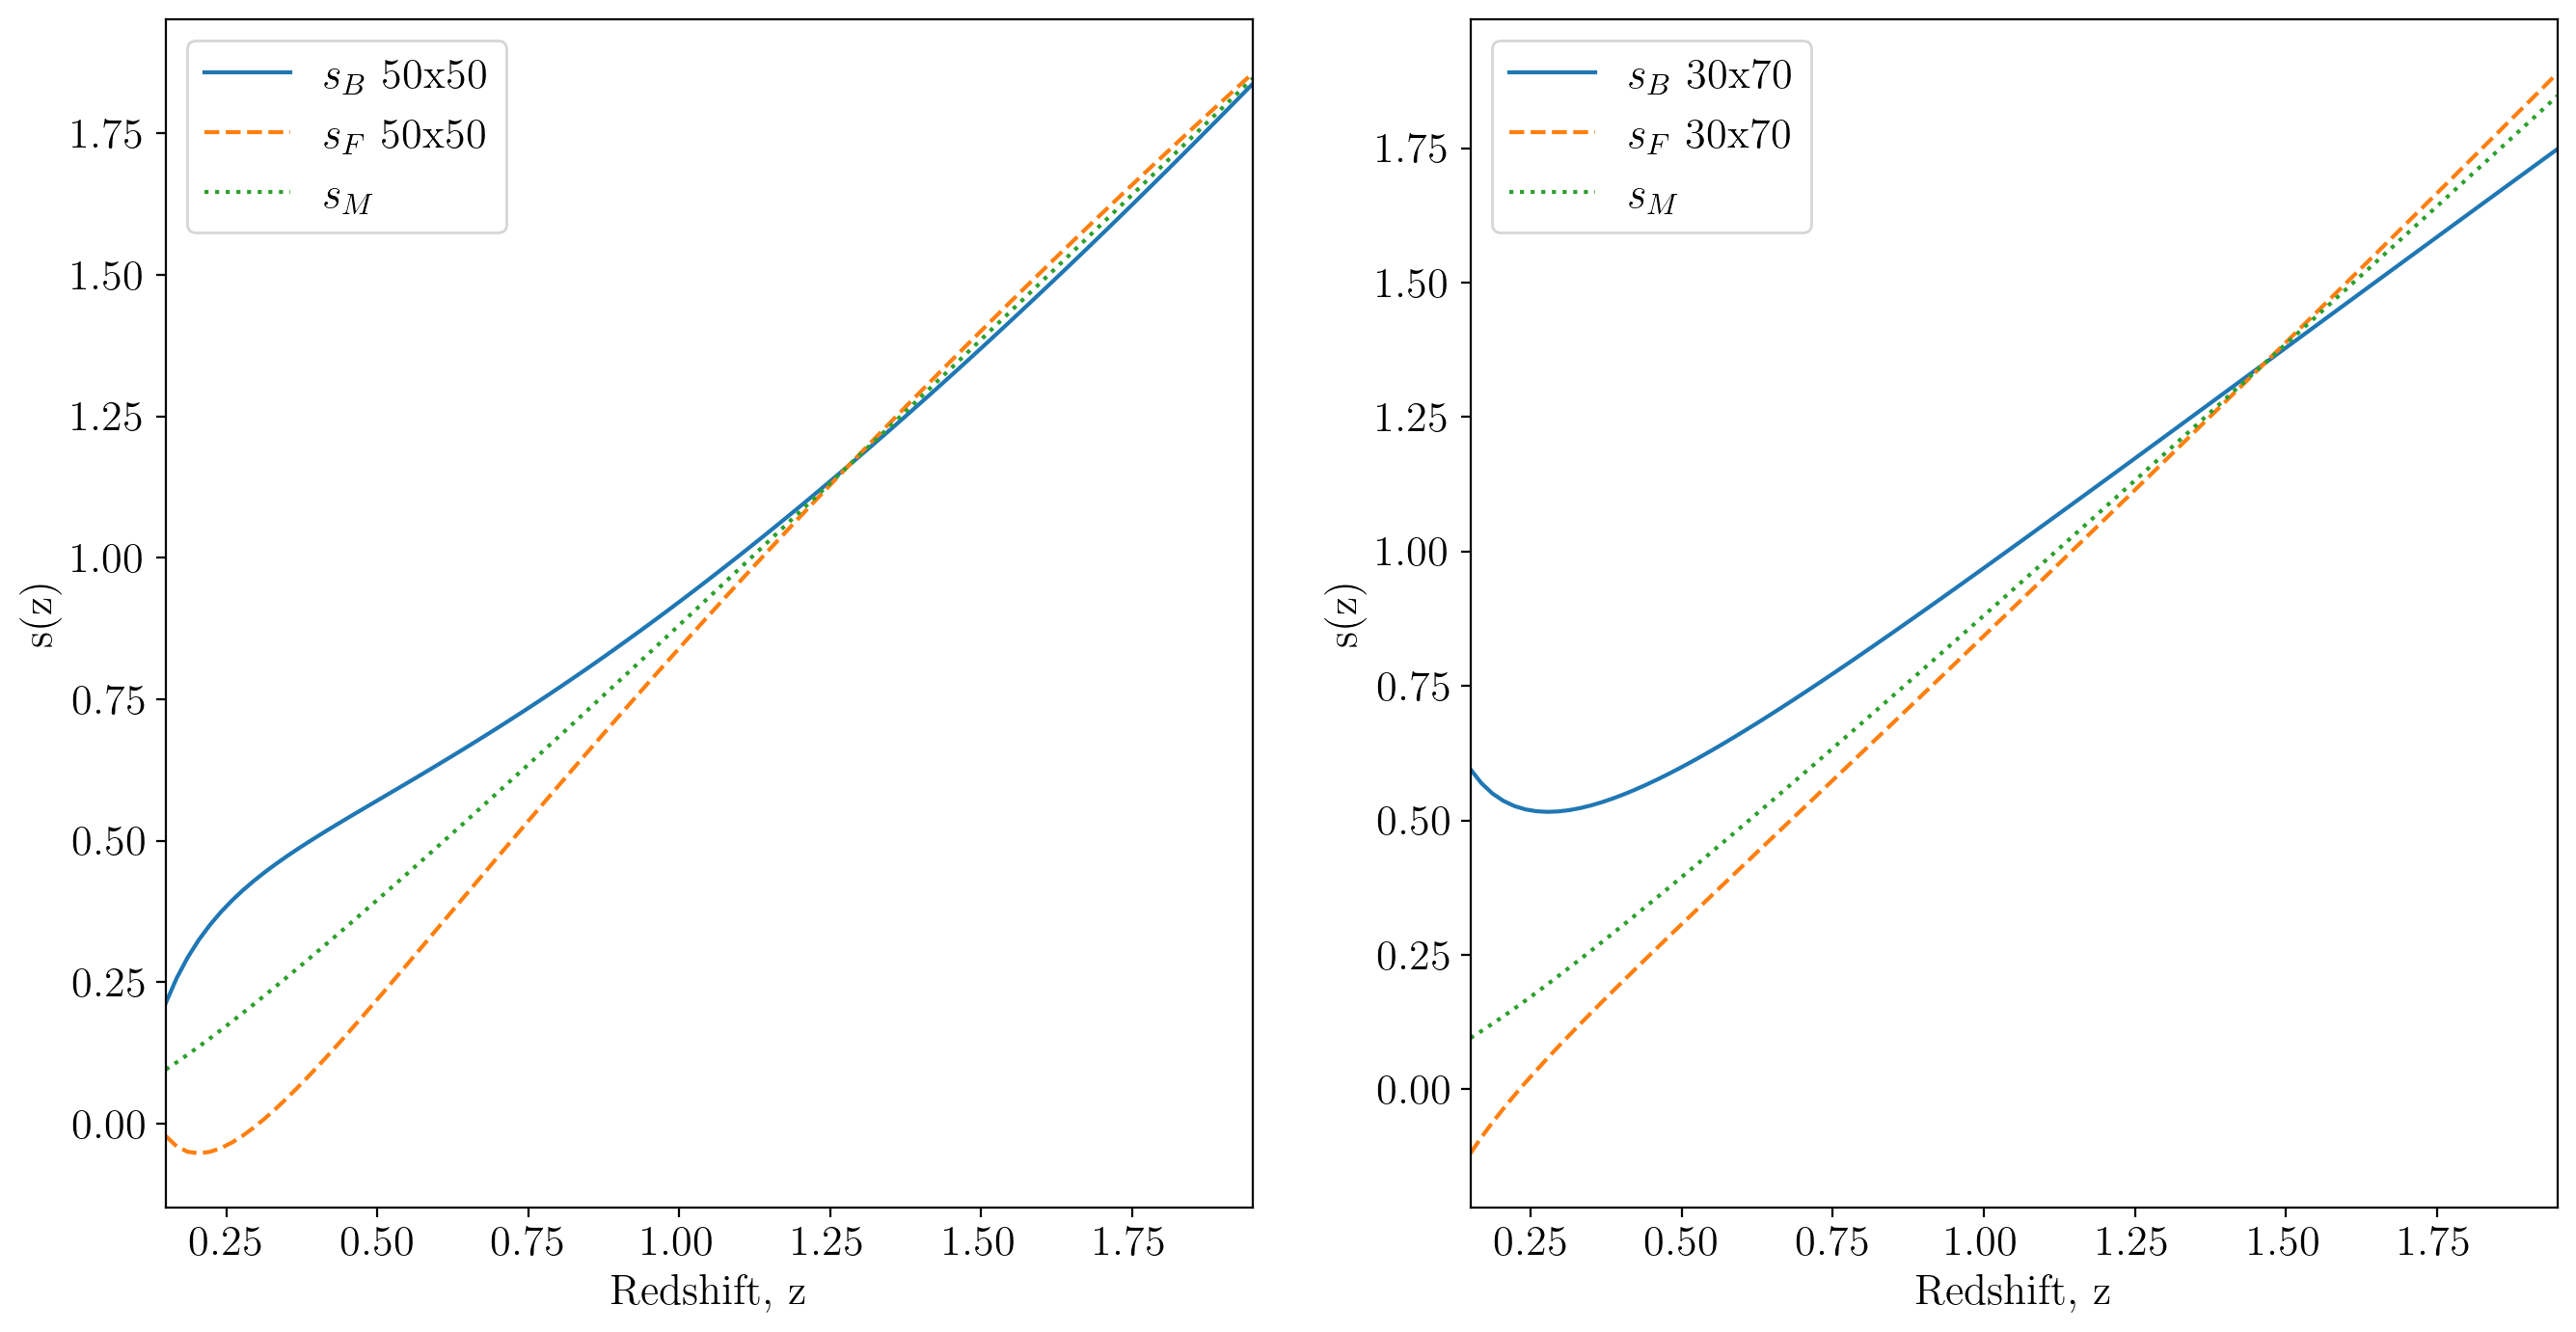

In [193]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [194]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


In [195]:
np.shape(Sigma_Matrix_30)

(21, 21)

In [196]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_50 = Sigma_Matrix_50[:4, :4]
cov_sB_30 = Sigma_Matrix_30[:4, :4]
cov_sM_50 = Sigma_Matrix_50[4:8, 4:8]
cov_sM_30 = Sigma_Matrix_30[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_50, num_samples)
sB_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_30, num_samples)
sM_50_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_50, num_samples)
sM_30_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_30, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_30_pars_samples])

# Calculate the 68% confidence interval
sB_50_lower_bound = np.percentile(sB_50_samples, 16, axis=0)
sB_50_upper_bound = np.percentile(sB_50_samples, 84, axis=0)

sB_30_lower_bound = np.percentile(sB_30_samples, 16, axis=0)
sB_30_upper_bound = np.percentile(sB_30_samples, 84, axis=0)

sM_50_lower_bound = np.percentile(sM_50_samples, 16, axis=0)
sM_50_upper_bound = np.percentile(sM_50_samples, 84, axis=0)
sM_30_lower_bound = np.percentile(sM_30_samples, 16, axis=0)
sM_30_upper_bound = np.percentile(sM_30_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

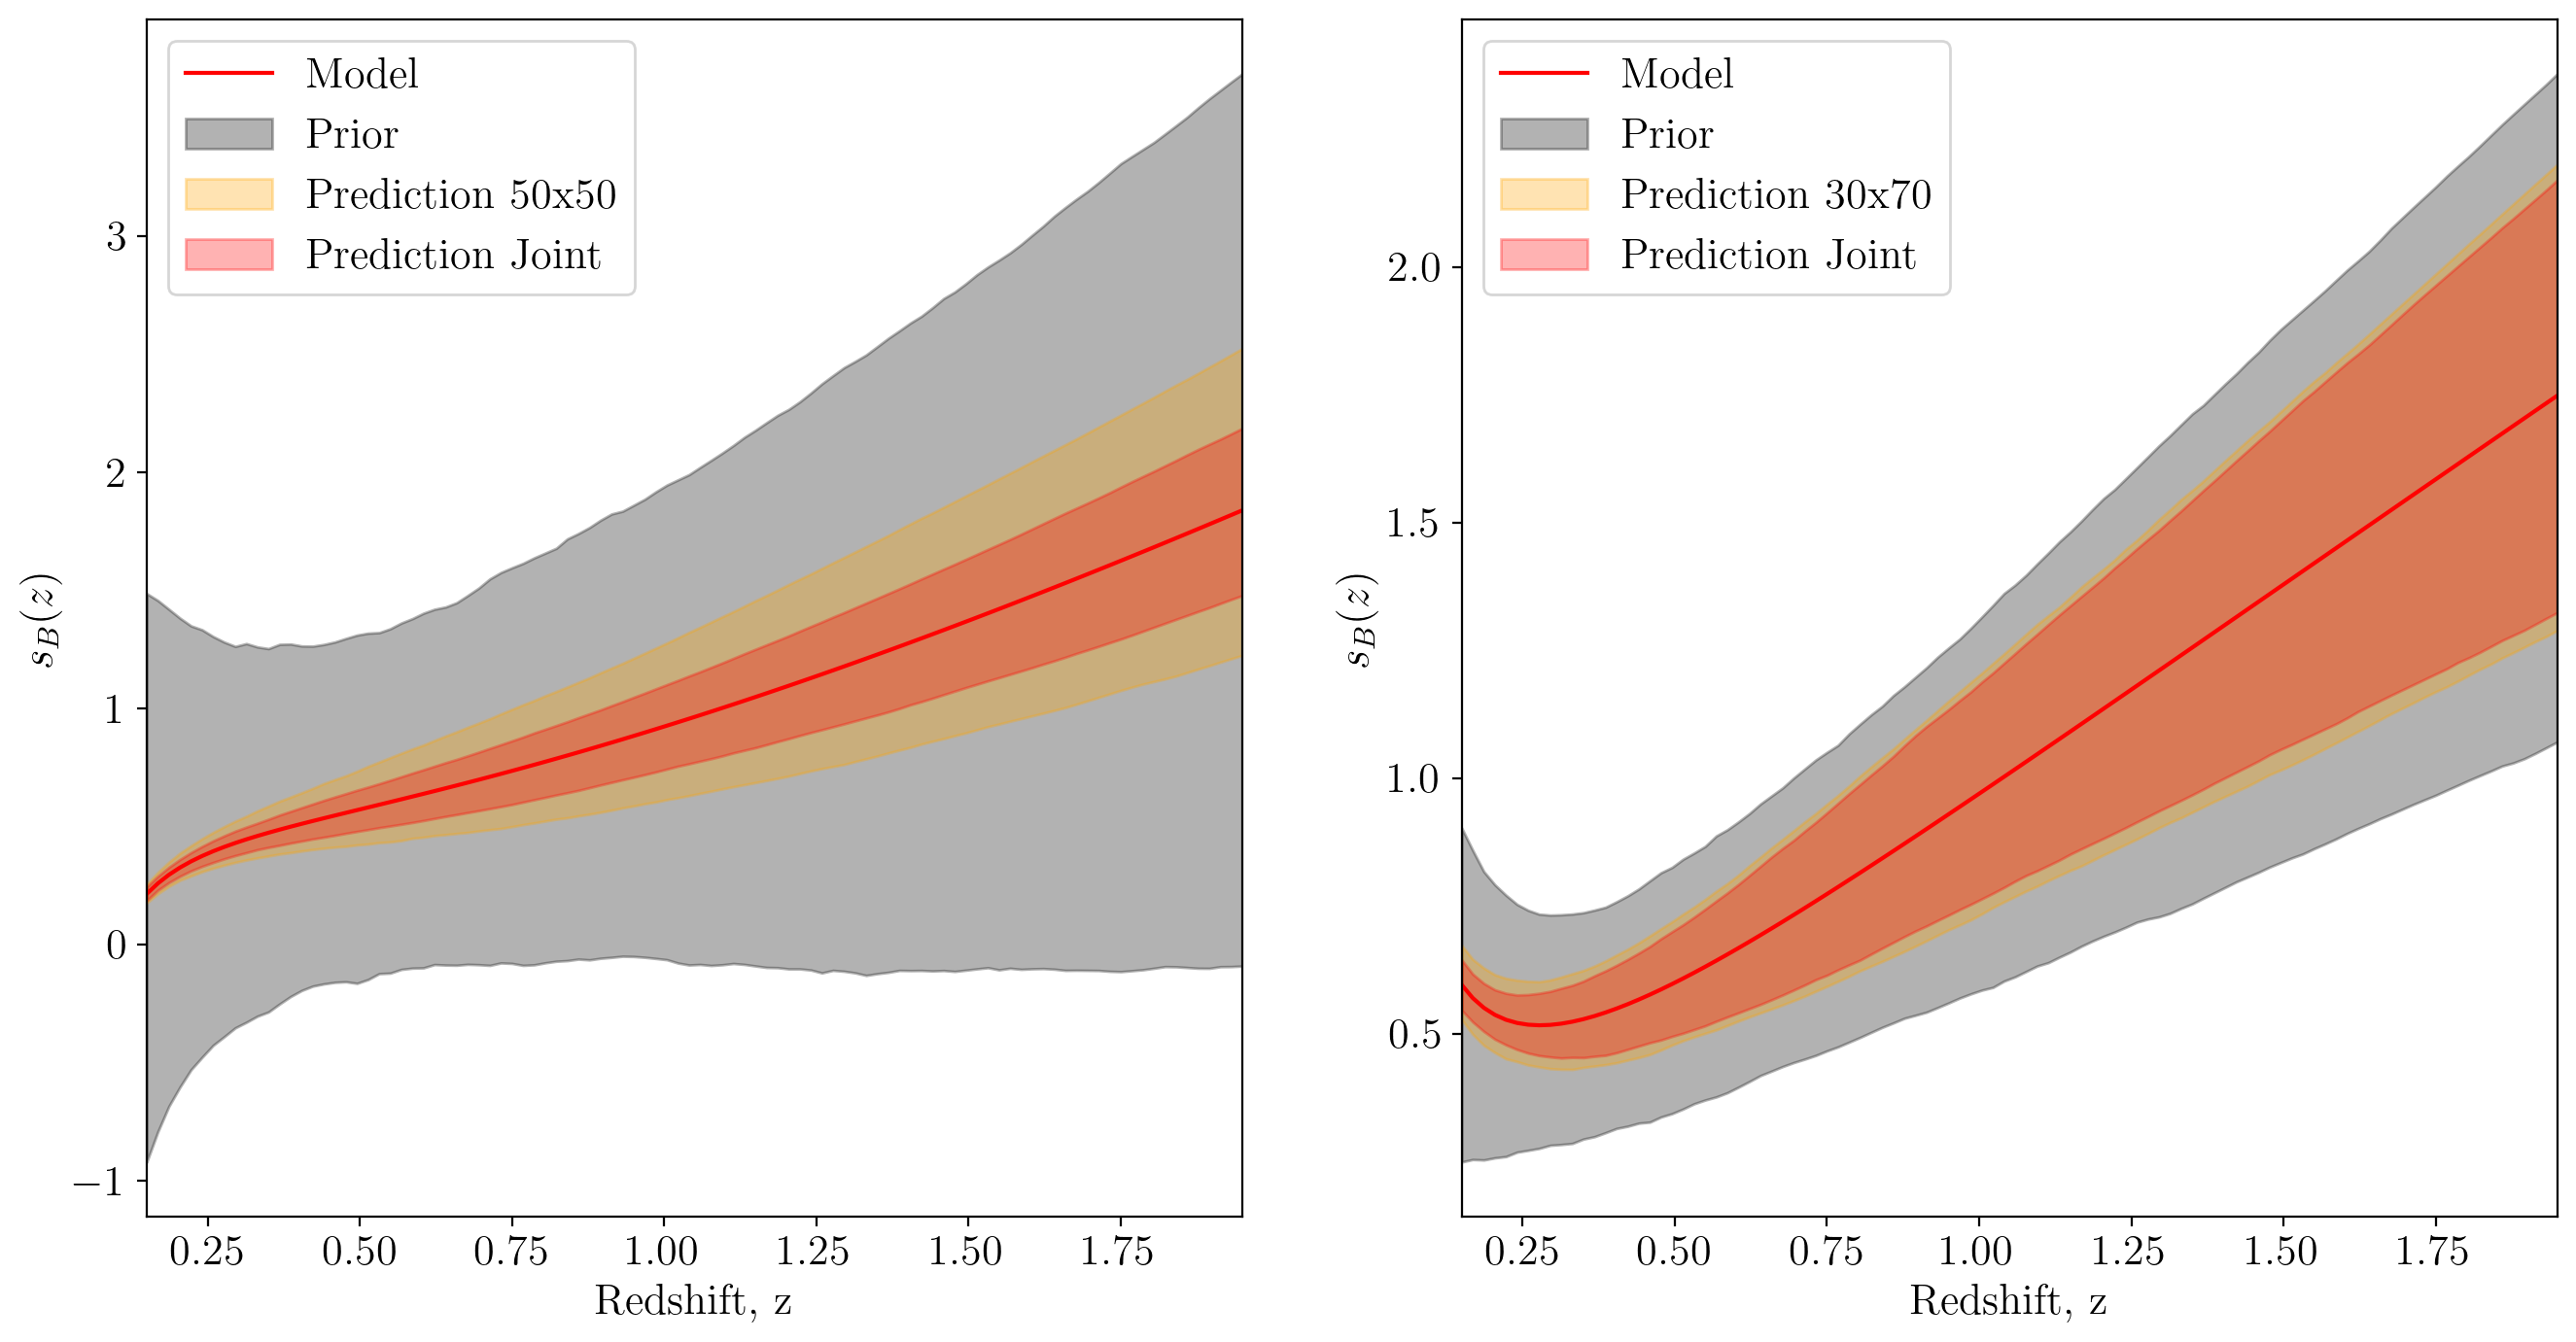

In [197]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-', label = r'Model')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sB_50_lower_bound, sB_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3, label = 'Prediction Joint')
ax[0].legend(loc='upper left')

ax[1].plot(z_lin, sB_fid_30, 'r-', label = r'Model')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sB_30_lower_bound, sB_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3, label = 'Prediction Joint')
ax[1].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

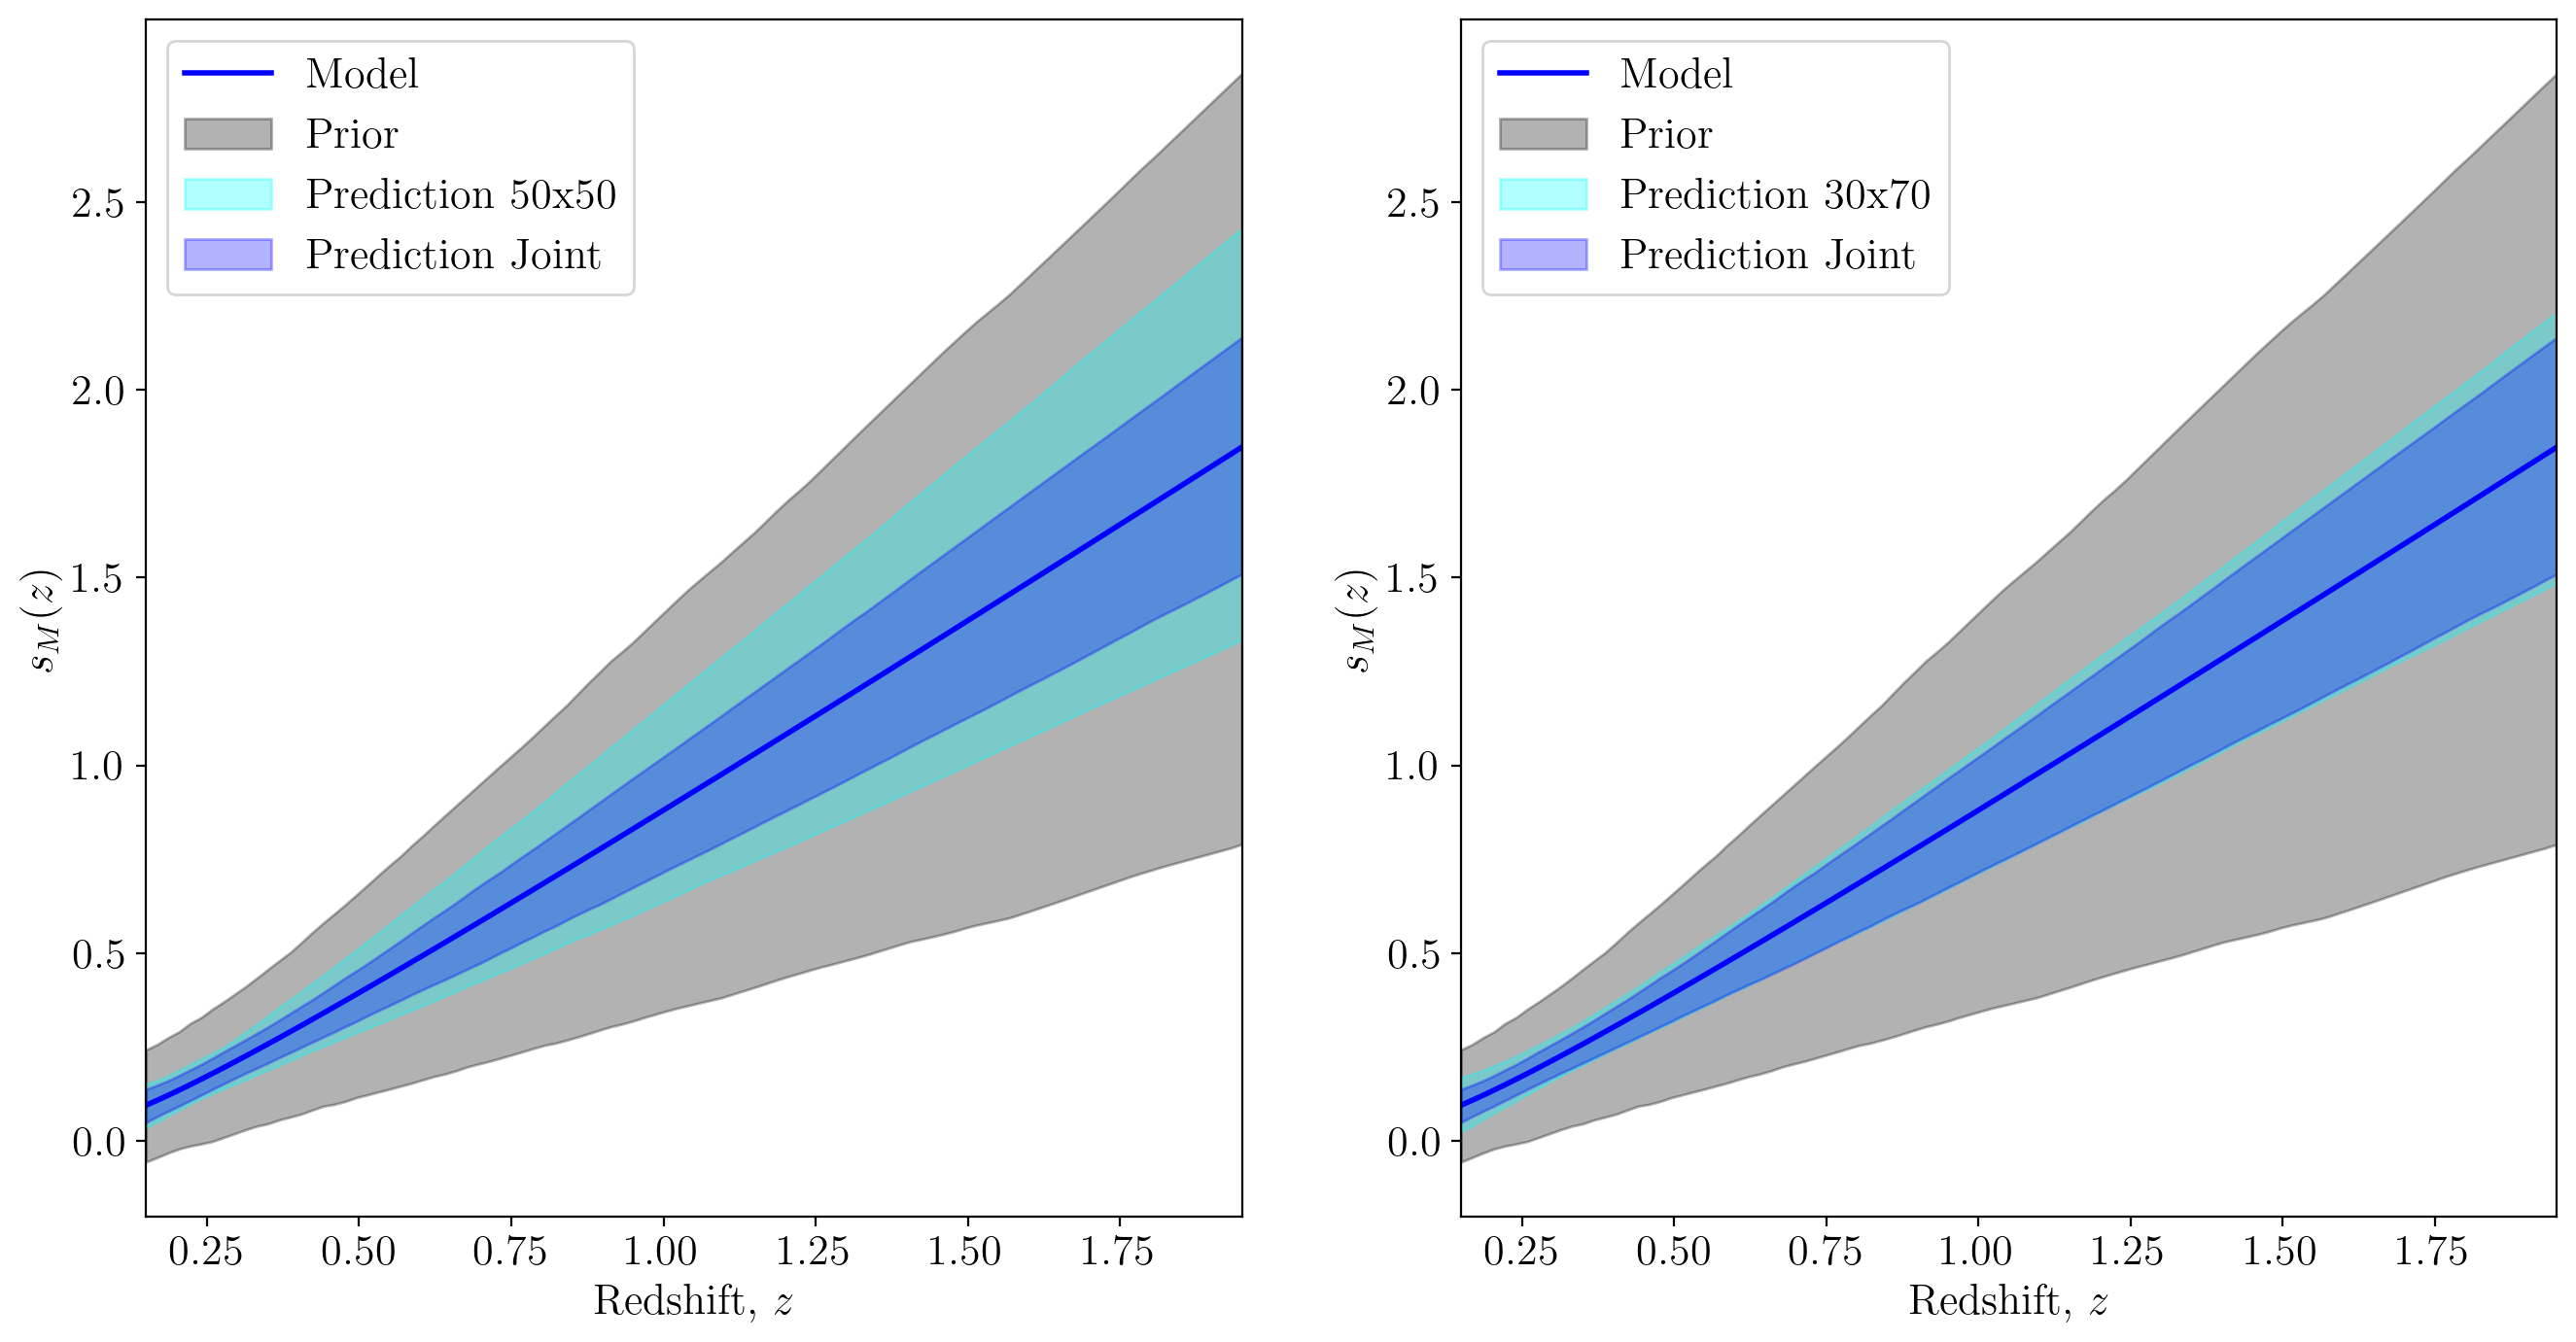

In [198]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

for axi in ax:
    axi.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[0].fill_between(z_lin, sM_50_lower_bound, sM_50_upper_bound, color='cyan', alpha=0.3, label = r'Prediction 50x50')
ax[0].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction Joint')

ax[1].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[1].fill_between(z_lin, sM_30_lower_bound, sM_30_upper_bound, color='cyan', alpha=0.3, label = r'Prediction 30x70')
ax[1].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction Joint')
    
for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, $z$');
    axi.set_ylabel(r'$s_M(z)$');
    axi.legend(loc='upper left');


### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_M$ parameters.

In [199]:
sbias_50_fid = np.concatenate([sB_4fit50, sM_4fit])
sbias_30_fid = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_50_fid), np.shape(sbias_30_fid)

((8,), (8,))

In [200]:
# Select the marginalized covariance matrix for the magnification biases together
cov_50_sbias = Sigma_Matrix_50[:8, :8]
cov_30_sbias = Sigma_Matrix_30[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples = np.random.multivariate_normal(sbias_50_fid, cov_50_sbias, num_samples)
sbias_30_pars_samples = np.random.multivariate_normal(sbias_30_fid, cov_30_sbias, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples])


# Compute the sF for each sample
sF_50_samples = sM_50_samples*m_50/(m_50-1) - sB_50_samples/(m_50-1)
sF_30_samples = sM_30_samples*m_30/(m_30-1) - sB_30_samples/(m_30-1)


# Calculate the 68% confidence interval
sF_50_lower_bound = np.percentile(sF_50_samples, 16, axis=0)
sF_50_upper_bound = np.percentile(sF_50_samples, 84, axis=0)

sF_30_lower_bound = np.percentile(sF_30_samples, 16, axis=0)
sF_30_upper_bound = np.percentile(sF_30_samples, 84, axis=0)

Compare with priors

In [201]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_50_priors = Cov_priors_50[:8, :8]
cov_sbias_30_priors = Cov_priors_30[:8, :8]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples_priors = np.random.multivariate_normal(sbias_50_fid, cov_sbias_50_priors, num_samples)
sbias_30_pars_samples_priors = np.random.multivariate_normal(sbias_30_fid, cov_sbias_30_priors, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples_priors])
sM_50_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples_priors])
sM_30_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples_priors])

# Compute the sF for each sample
sF_50_samples_priors = sM_50_samples_priors*m_50/(m_50-1) - sB_50_samples_priors/(m_50-1)
sF_30_samples_priors = sM_30_samples_priors*m_30/(m_30-1) - sB_30_samples_priors/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors = np.percentile(sF_50_samples_priors, 16, axis=0)
sF_50_upper_bound_priors = np.percentile(sF_50_samples_priors, 84, axis=0)

sF_30_lower_bound_priors = np.percentile(sF_30_samples_priors, 16, axis=0)
sF_30_upper_bound_priors = np.percentile(sF_30_samples_priors, 84, axis=0)

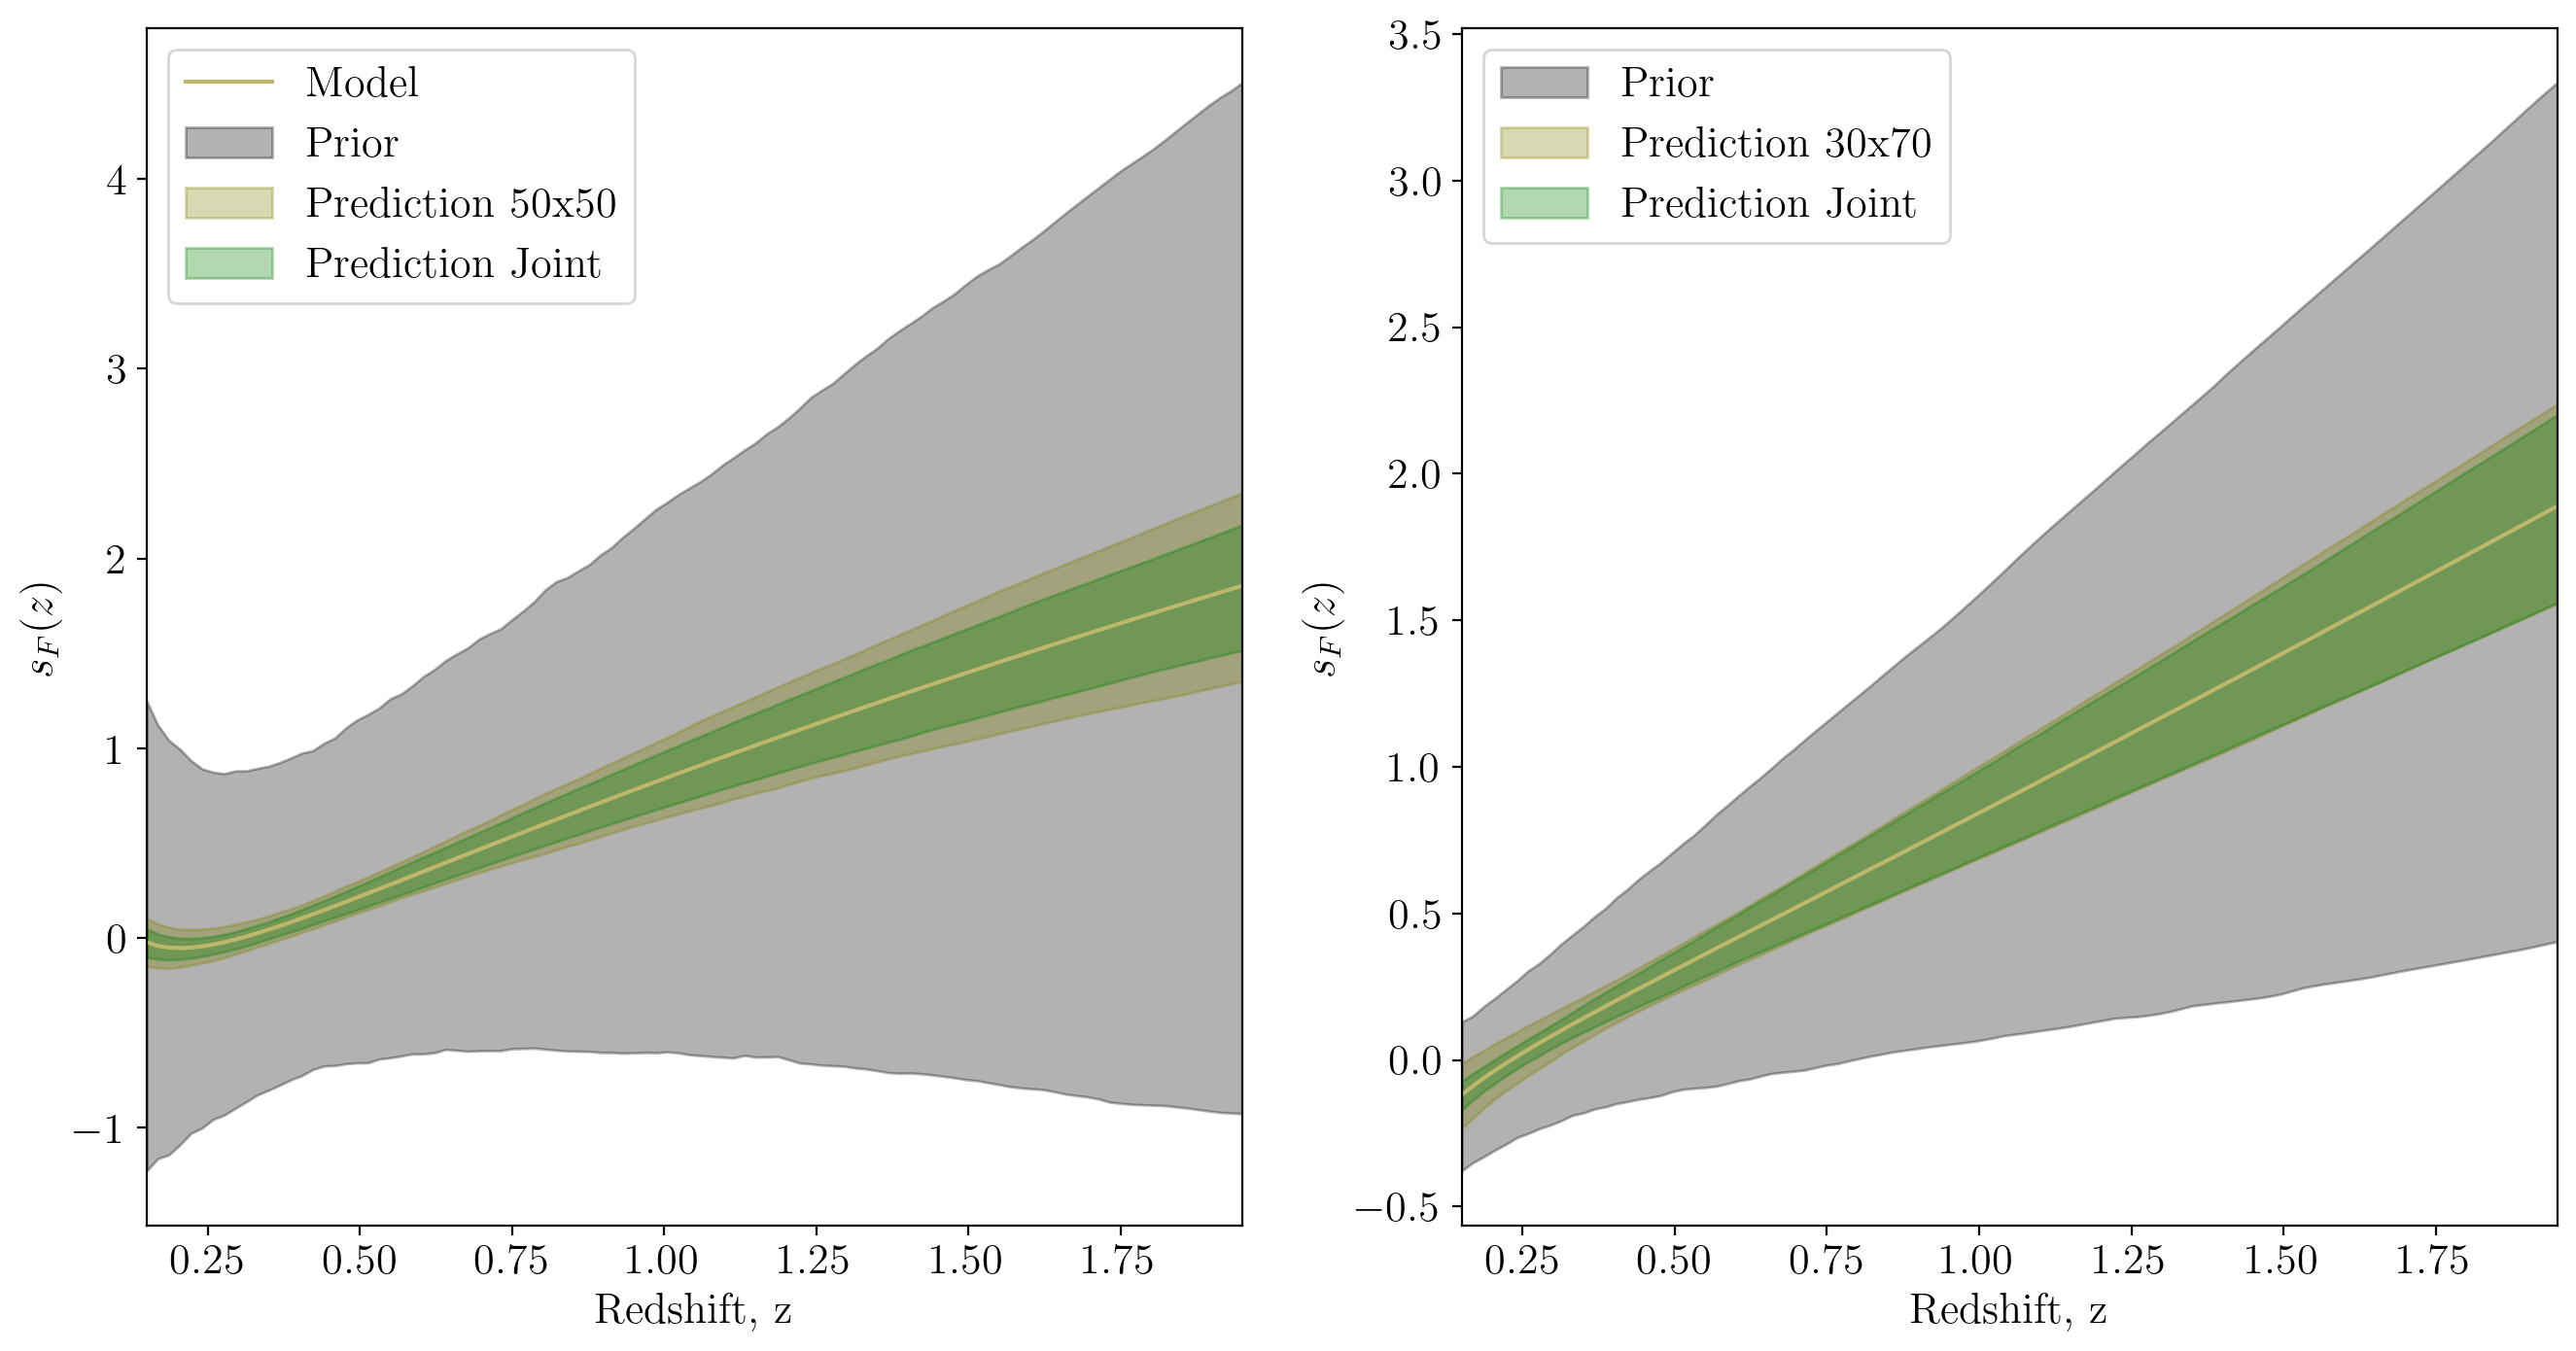

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'darkkhaki', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_lower_bound, sF_50_upper_bound, color='olive', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'darkkhaki')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sF_30_lower_bound, sF_30_upper_bound, color='olive', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')
    axi.legend(loc='upper left')

## Number evolution

In [203]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

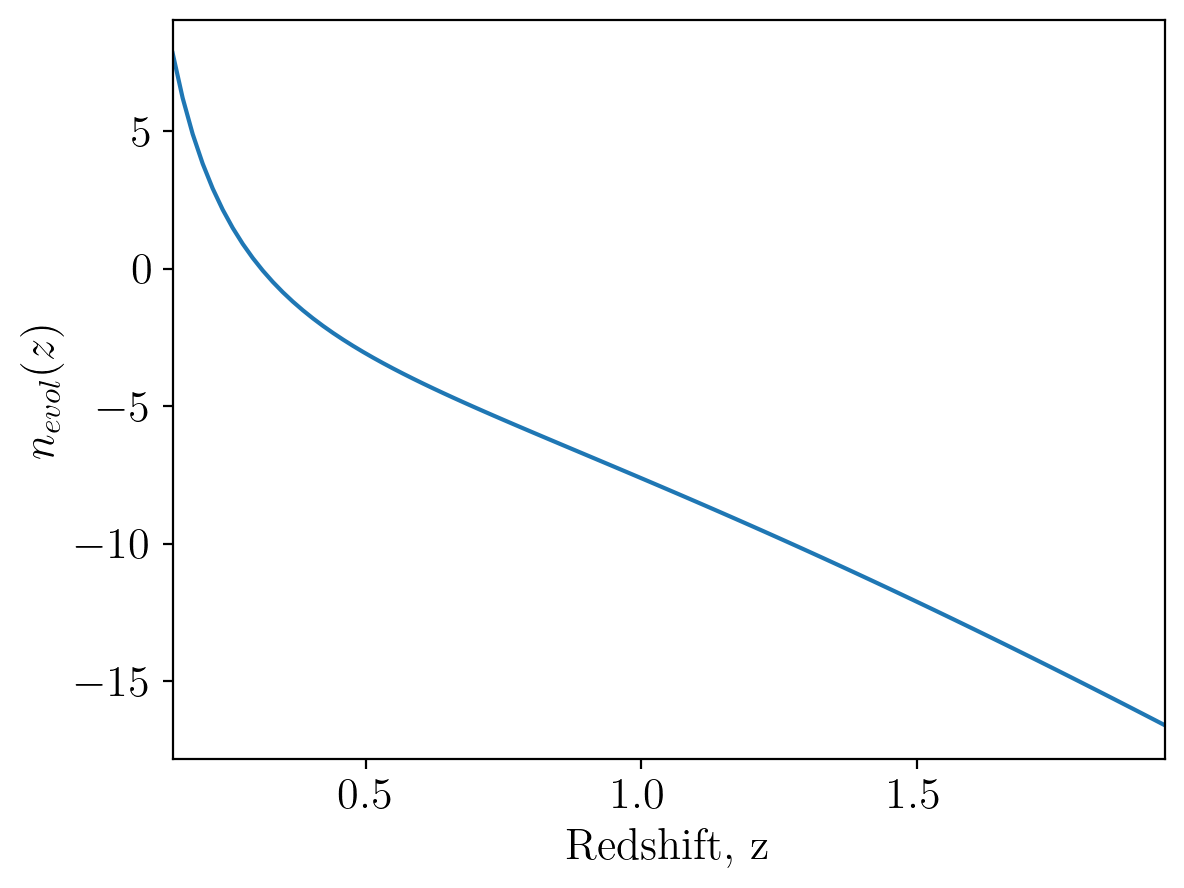

In [204]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [205]:
# Select the marginalized covariance matrix for the number evolution

cov_50_numevol = Sigma_Matrix_50[8:12,8:12]
cov_30_numevol = Sigma_Matrix_30[8:12,8:12]



# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_50_pars_samples = np.random.multivariate_normal(num_fit, cov_50_numevol, num_samples)
nevol_30_pars_samples = np.random.multivariate_normal(num_fit, cov_30_numevol, num_samples)


# Evaluate fitting function for each parameter sample
nevol_50_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_50_pars_samples])
nevol_30_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_30_pars_samples])

# Calculate the 68% confidence interval
nevol_50_lower_bound = np.percentile(nevol_50_samples, 16, axis=0)
nevol_50_upper_bound = np.percentile(nevol_50_samples, 84, axis=0)
nevol_30_lower_bound = np.percentile(nevol_30_samples, 16, axis=0)
nevol_30_upper_bound = np.percentile(nevol_30_samples, 84, axis=0)


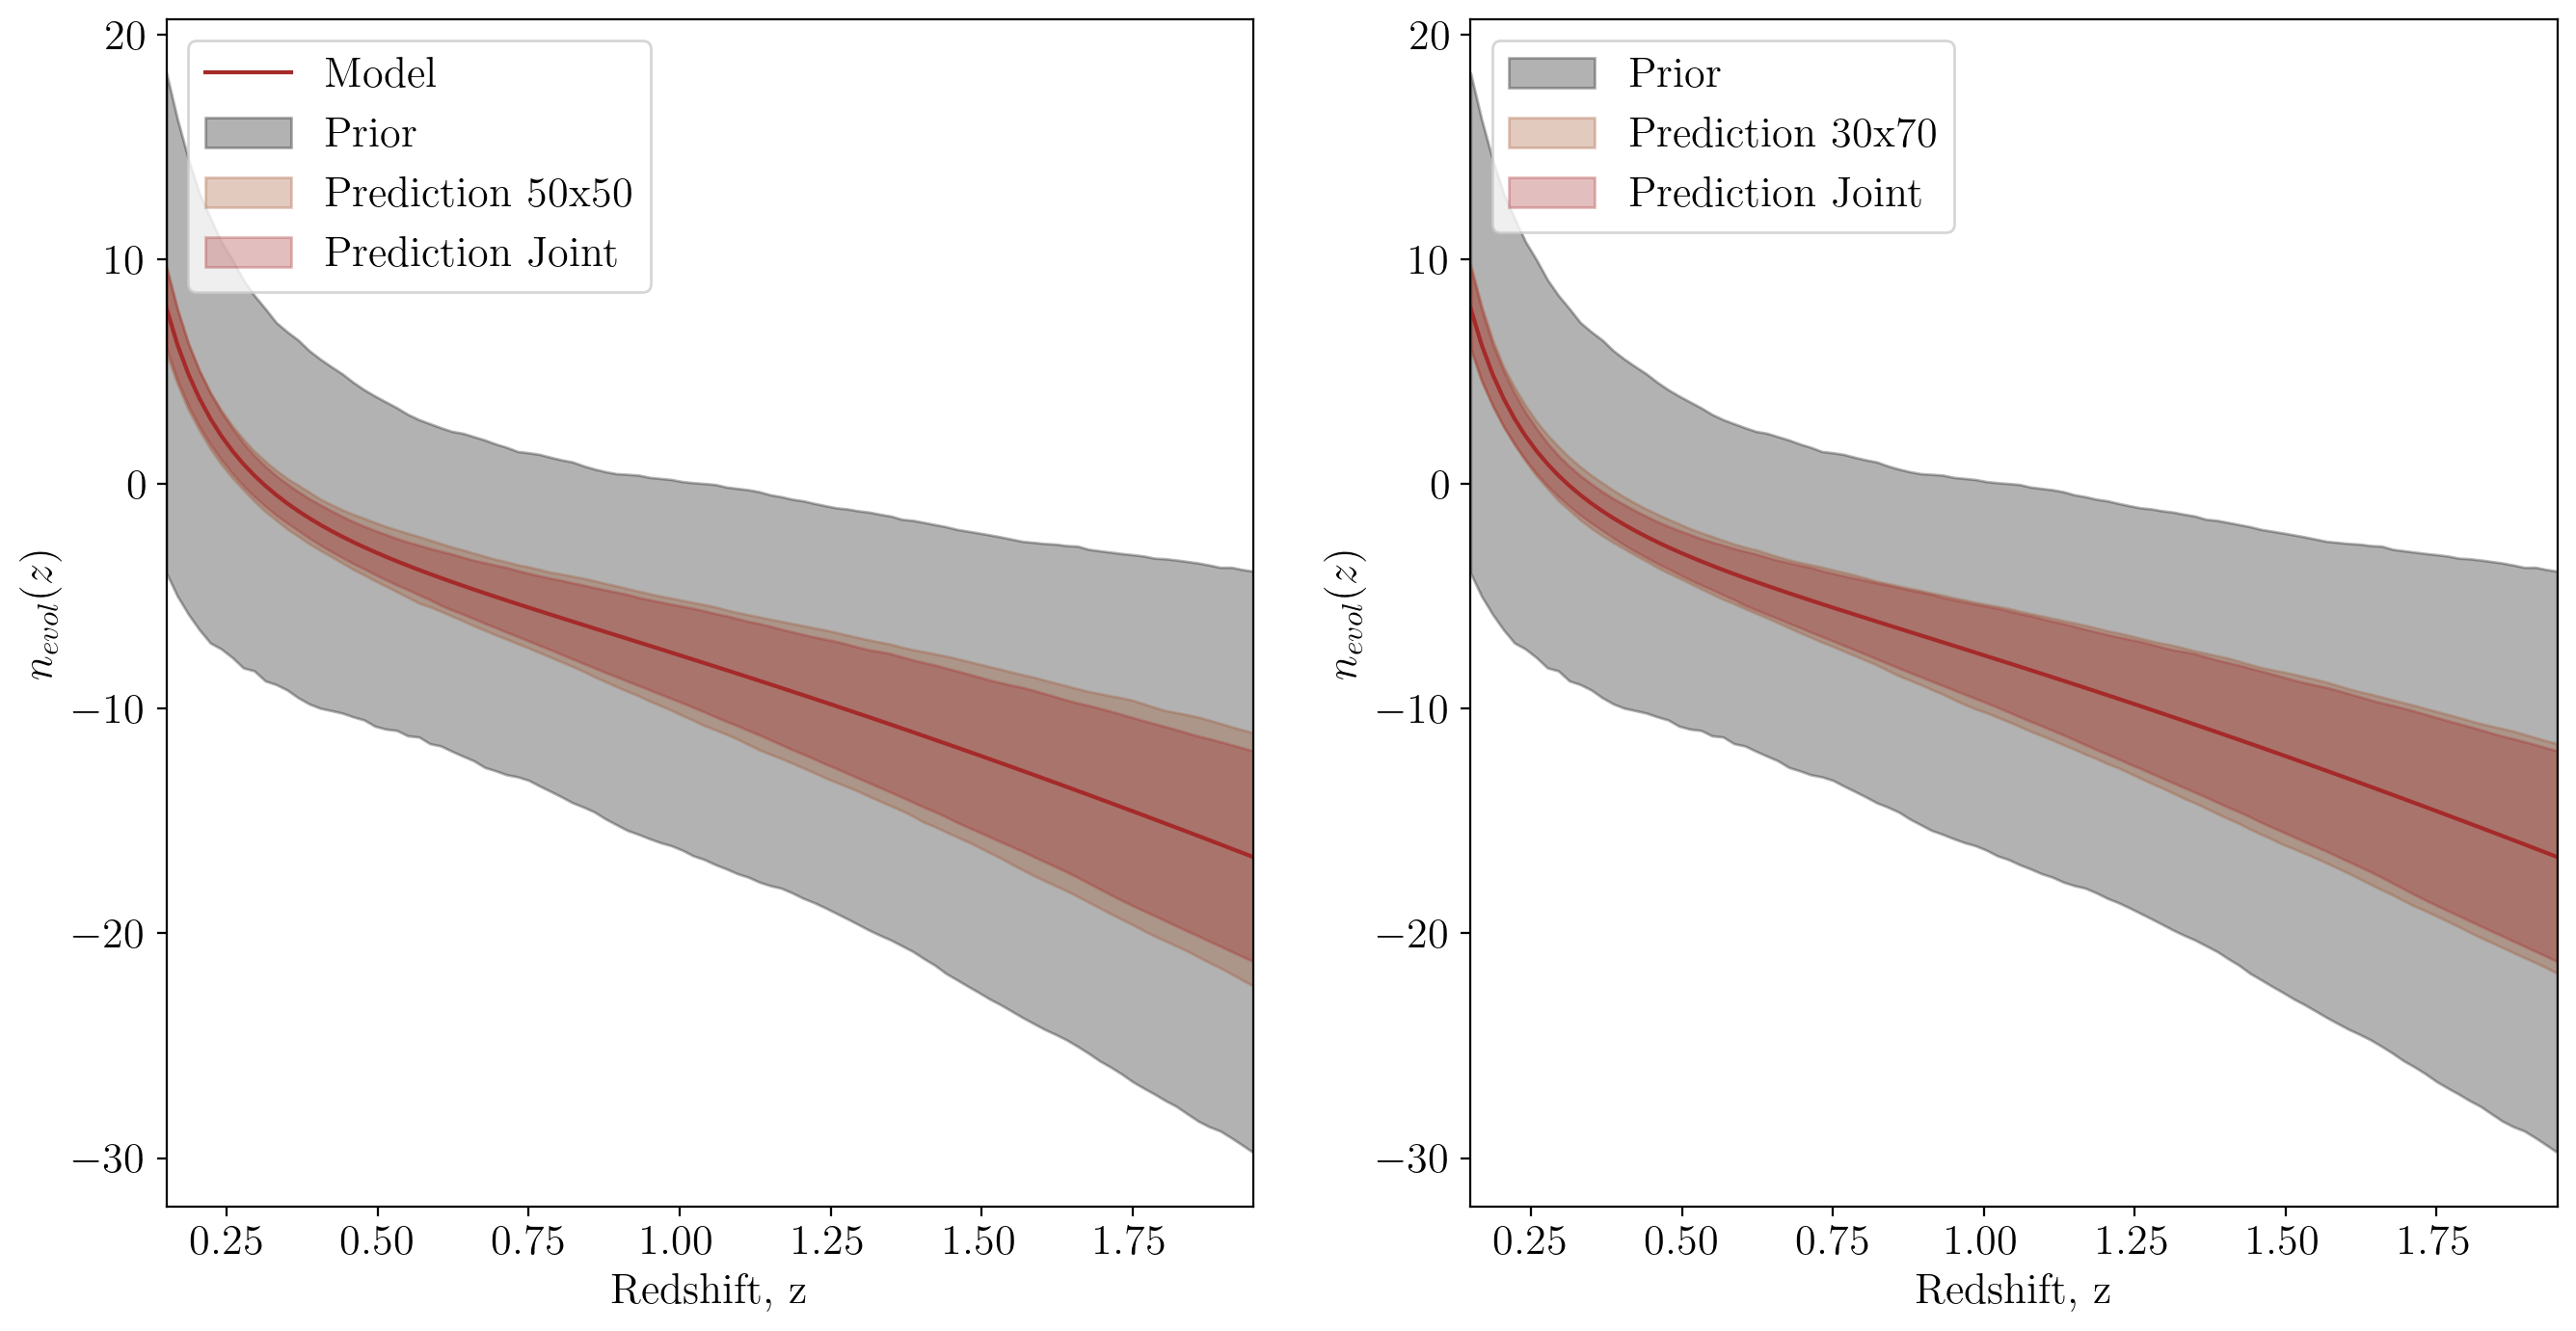

In [206]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, num_evol_fid, '-', color = 'brown', label = 'Model')
ax[0].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, nevol_50_lower_bound, nevol_50_upper_bound, color='sienna', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='brown', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, num_evol_fid, '-', color = 'brown')
ax[1].fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, nevol_30_lower_bound, nevol_30_upper_bound, color='sienna', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='brown', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$n_{evol}(z)$')
    axi.legend(loc='upper left')

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [207]:
from biasmodels import EvolutionBias

In [208]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [209]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [210]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

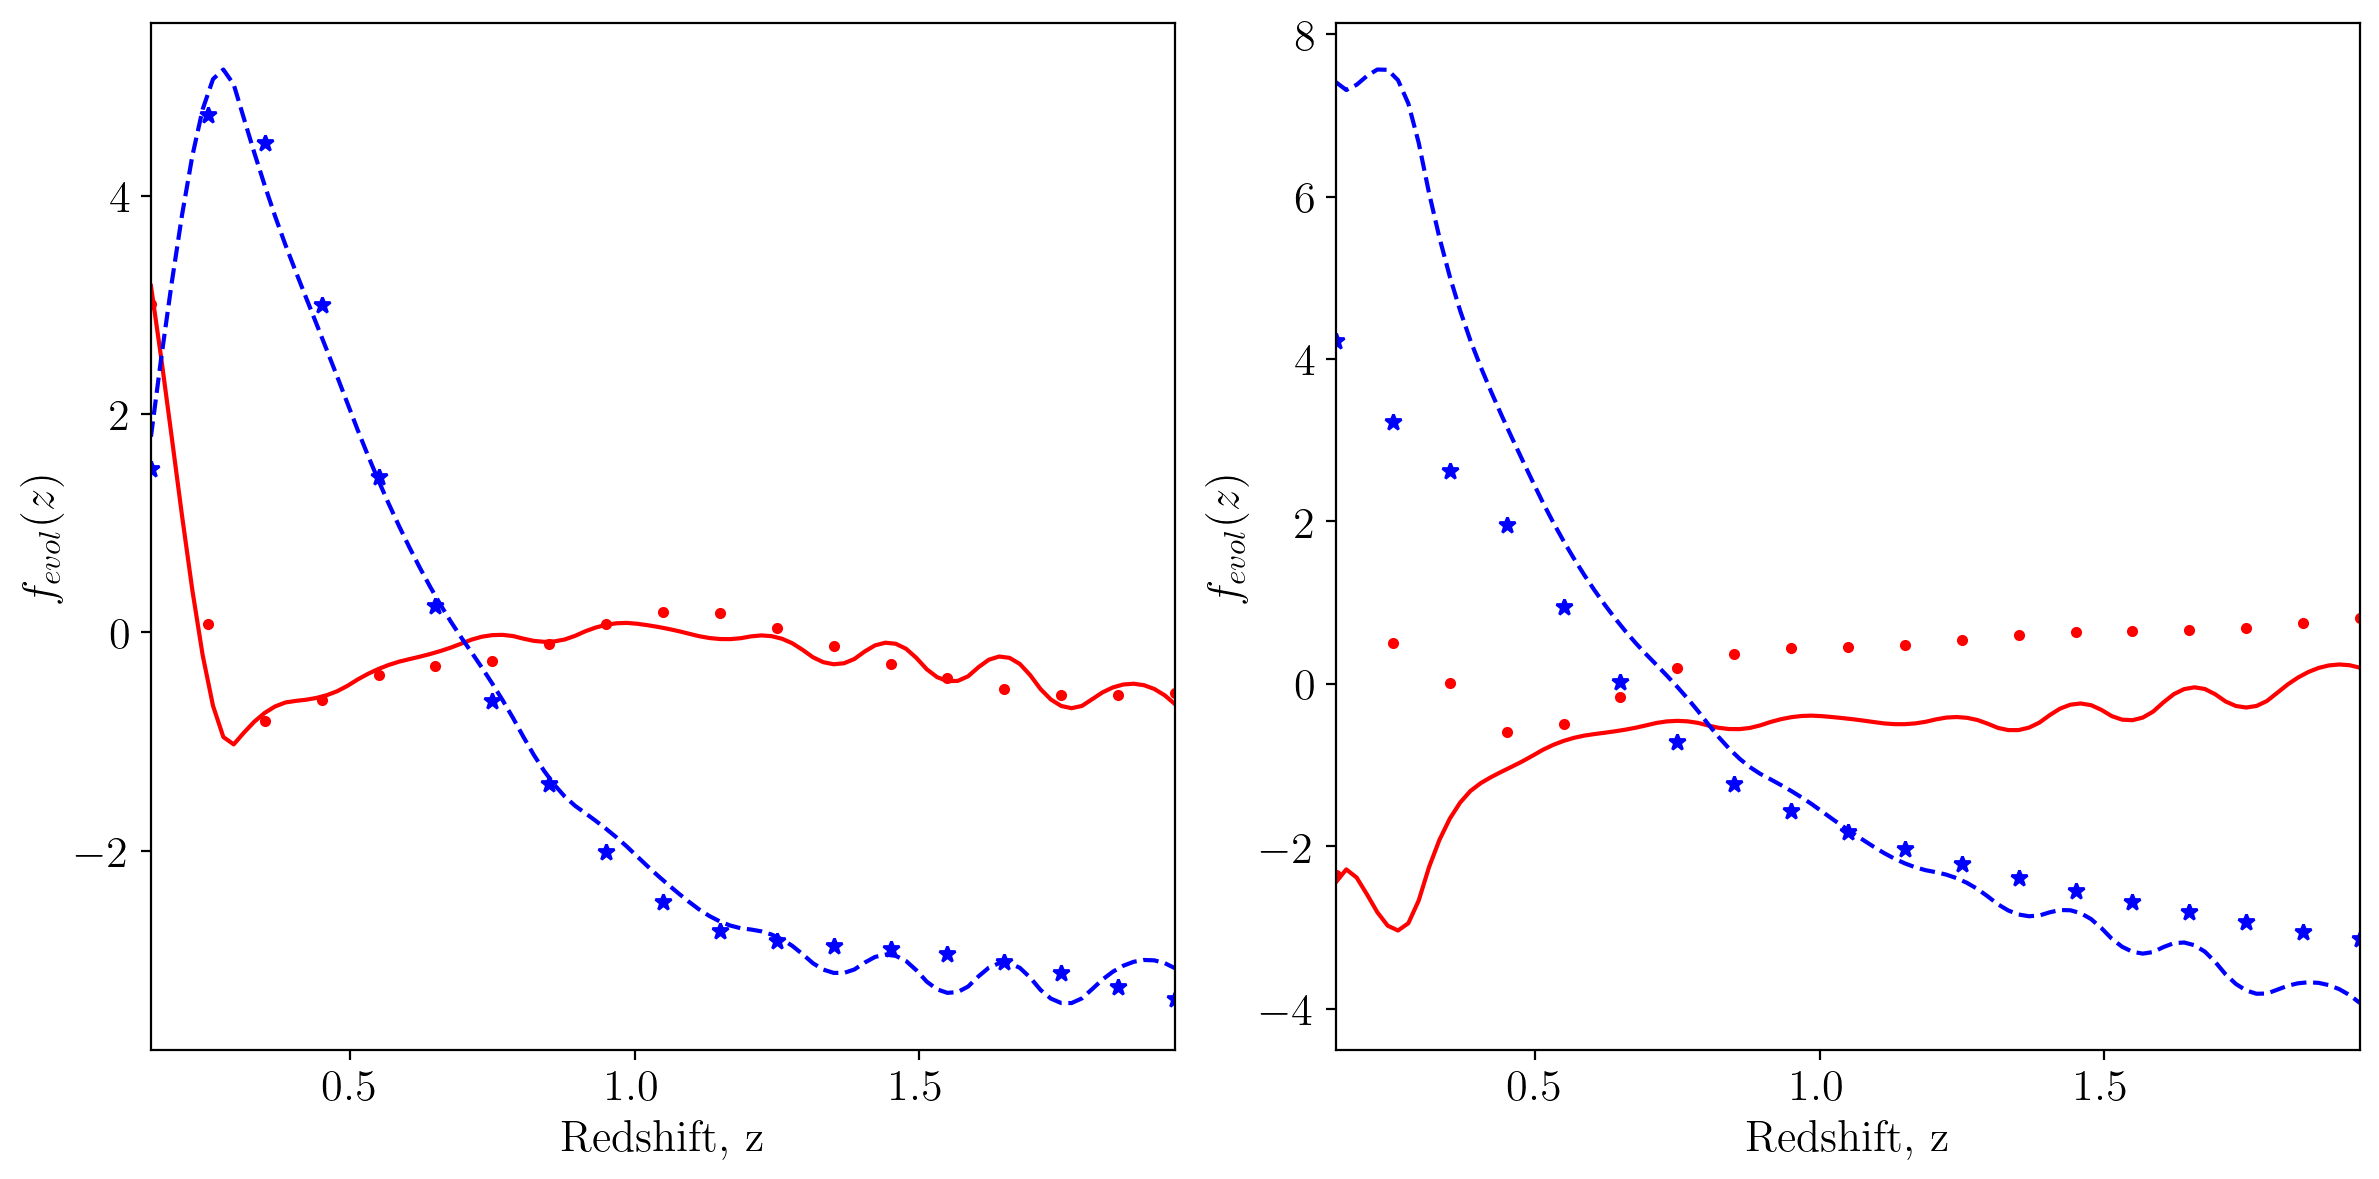

In [211]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [212]:
all_50_fid = np.concatenate([sB_4fit50, sM_4fit, num_fit])
all_30_fid = np.concatenate([sB_4fit30, sM_4fit, num_fit])

np.shape(all_50_fid), np.shape(all_30_fid)

((12,), (12,))

In [213]:
# Select the marginalized covariance matrix for the parameters

cov_50_all = Sigma_Matrix_50[:12, :12]
cov_30_all = Sigma_Matrix_30[:12, :12]
cov_50_priors = Cov_priors_50[:12, :12]
cov_30_priors = Cov_priors_30[:12, :12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_50_pars_samples = np.random.multivariate_normal(all_50_fid, cov_50_all, num_samples)
all_50_pars_samples_priors_ = np.random.multivariate_normal(all_50_fid, cov_50_priors, num_samples)
all_30_pars_samples = np.random.multivariate_normal(all_30_fid, cov_30_all, num_samples)
all_30_pars_samples_priors_ = np.random.multivariate_normal(all_30_fid, cov_30_priors, num_samples)

In [214]:
# Evaluate fitting function for each parameter sample

fevol_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])
fevol_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])

fevol_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])
fevol_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound_ = np.percentile(fevol_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound_ = np.percentile(fevol_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 16, axis=0)
fevol_B_50_upper_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 84, axis=0)

fevol_F_50_lower_bound_ = np.percentile(fevol_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound_ = np.percentile(fevol_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 16, axis=0)
fevol_F_50_upper_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 84, axis=0)

fevol_B_30_lower_bound_ = np.percentile(fevol_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound_ = np.percentile(fevol_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 16, axis=0)
fevol_B_30_upper_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 84, axis=0)

fevol_F_30_lower_bound_ = np.percentile(fevol_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound_ = np.percentile(fevol_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 16, axis=0)
fevol_F_30_upper_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 84, axis=0)

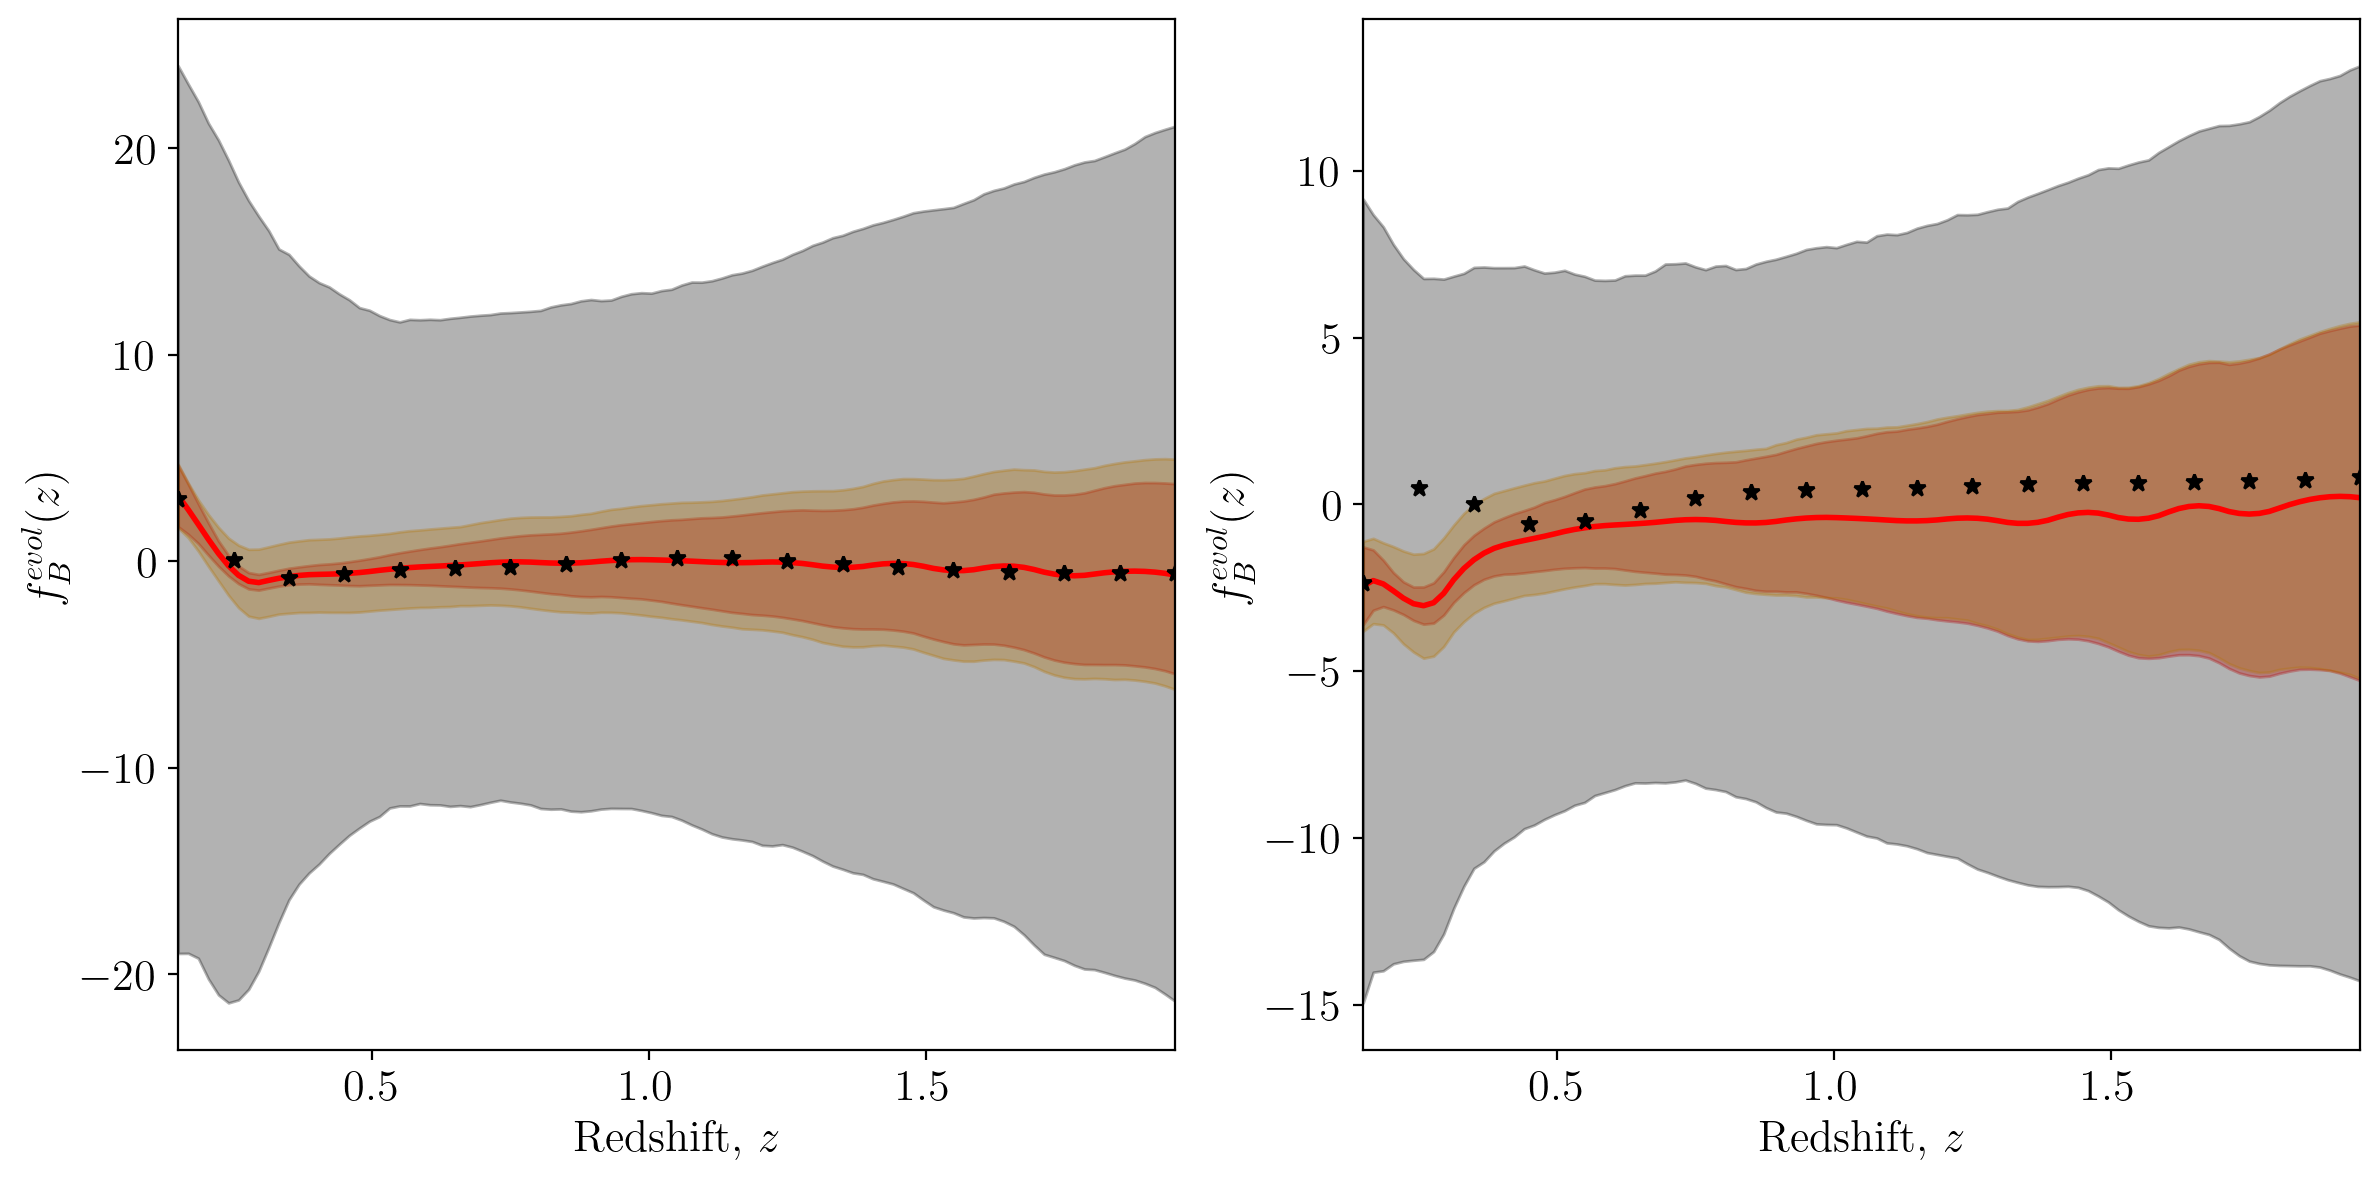

In [215]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_, fevol_B_50_upper_bound_, color='orange', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_, fevol_B_30_upper_bound_, color='orange', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

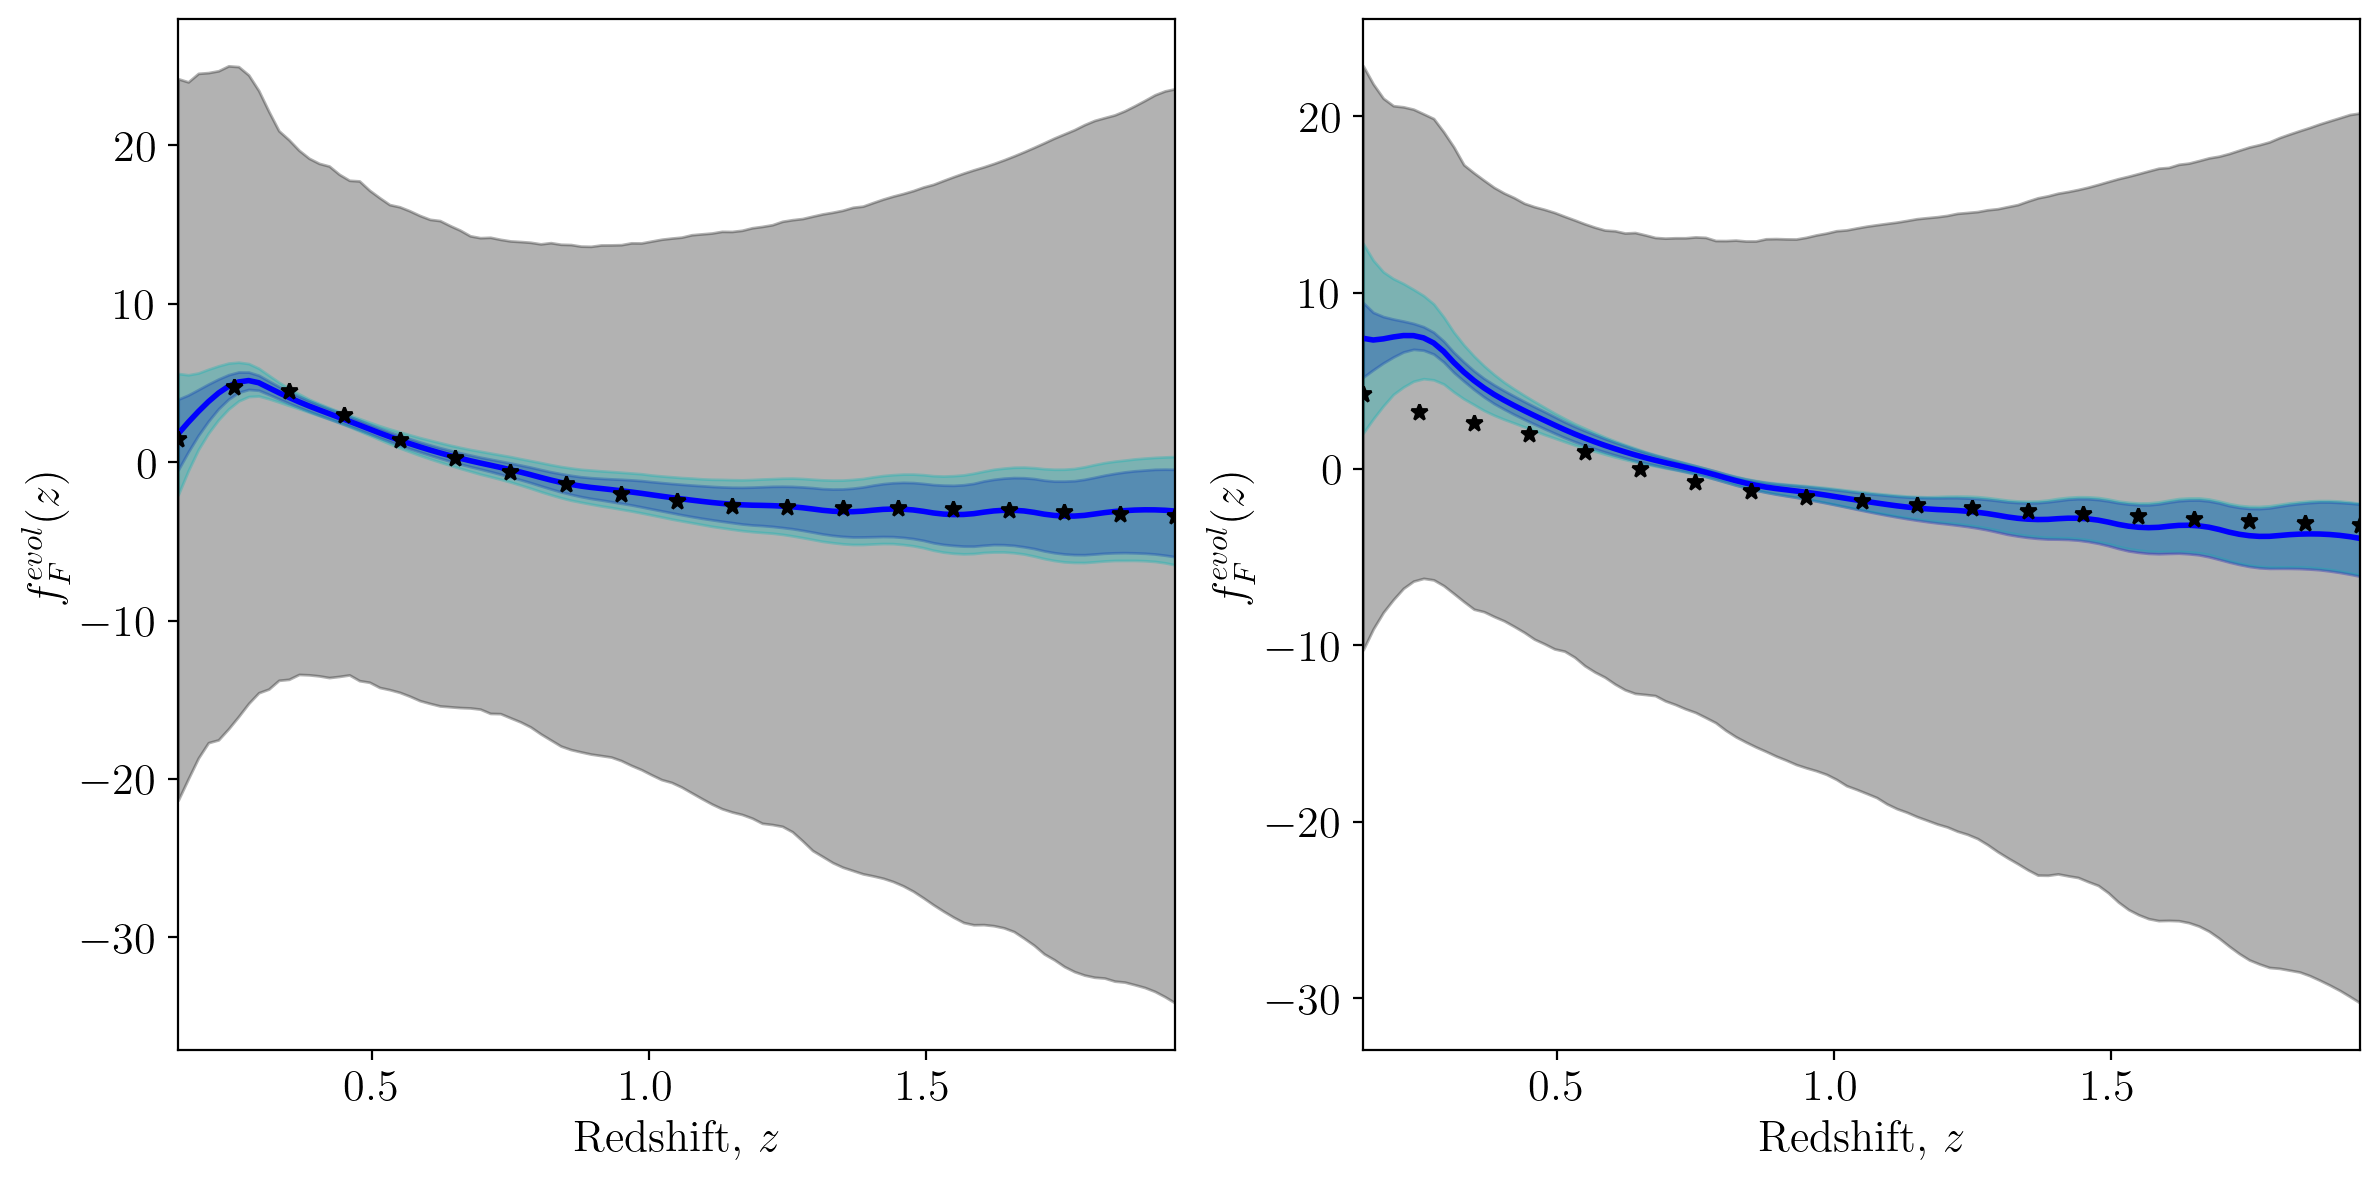

In [216]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='blue', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='blue', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='blue', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_, fevol_F_50_upper_bound_, color='cyan', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='blue', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_, fevol_F_30_upper_bound_, color='cyan', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')